# Project 10: Chapter 8: Advanced Data Analysis
In the last few chapters, we have become comfortable with the idea of building our own functions. These can become quite complex, as we have learned with the construction of the OLS regression in chapter 7. We will continue developing our tool set for working with and managing large sets of data by integrating data from different data sets. We will introduce the multi index to facilitate this process. Among other things, the multi index is useful for including identifiers across time and region or principality. We will also use the multi index to perform a panel regression that controls for level effects between different countries.

## Using a Double Index to Work with Panel Data
In any project, it will not be uncommon for data to be attached to more than one indentifying category. Often, data will be labeled by polity and by date. In the next several examples, we will work with multiple data sets of this sort, working to combine different data sets, investigate the features of the double index, and use this data in a panel regression that can control for effects by polity and by time period.

### Plotting with Double Index
We will be working with two datasets in the next example: the [Fraser Economic Freedom Index](https://www.fraserinstitute.org/economic-freedom/dataset?geozone=world&page=dataset&min-year=2&max-year=0&filter=0&year=2017) and GDP from the [Maddison Project](https://www.rug.nl/ggdc/historicaldevelopment/maddison/releases/maddison-project-database-2018).

Due to the formatting of the Fraser Economic Freedom Index, the first column and the first three rows of data in the sheet titled “EFW Index 2018 Report” are blank. We will account for this when importing the data with pandas. Both should be saved in the same folder as the script below.

First, import the GDP data from Maddison Project:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# import data from fraserdatawithrgdppc file created last project
# index_col = [0,2] will select  countrycode as the primary index and year as 
# the secondary index

data = pd.read_csv("fraserDataWithRGDPPC.csv", 
                     index_col = ["ISO_Code_3","Year"], 
                   parse_dates = True).rename(columns = {"Summary": "EFW"})
data

ISO_Code_2   World Bank Region  \
ISO_Code_3 Year                                        
AGO        1970-01-01         AO  Sub-Saharan Africa   
           1975-01-01         AO  Sub-Saharan Africa   
           1980-01-01         AO  Sub-Saharan Africa   
           1985-01-01         AO  Sub-Saharan Africa   
           1990-01-01         AO  Sub-Saharan Africa   
...                          ...                 ...   
ZWE        2016-01-01         ZW  Sub-Saharan Africa   
           2017-01-01         ZW  Sub-Saharan Africa   
           2018-01-01         ZW  Sub-Saharan Africa   
           2019-01-01         ZW  Sub-Saharan Africa   
           2020-01-01         ZW  Sub-Saharan Africa   

                      World Bank Current Income Classification, 1990-present (L=Low income, LM=Lower middle income, UM=Upper middle income, H=High income)  \
ISO_Code_3 Year                                                                                                                                              
AGO        1970-01-01                                                NaN                                                                                     
           1975-01-01                                                NaN                                                                                     
           1980-01-01                                                NaN                                                                                     
           1985-01-01                                                NaN                                                                                     
           1990-01-01                                                 LM                                                                                     
...                                                                  ...                                                                                     
ZWE        2016-01-01                                                  L                                                                                     
           2017-01-01                                                  L                                                                                     
           2018-01-01                                                 LM                                                                                     
           2019-01-01                                                 LM                                                                                     
           2020-01-01                                                 LM                                                                                     

                      Countries       EFW  Size of Government  \
ISO_Code_3 Year                                                 
AGO        1970-01-01    Angola       NaN                 NaN   
           1975-01-01    Angola       NaN                 NaN   
           1980-01-01    Angola       NaN                 NaN   
           1985-01-01    Angola       NaN                 NaN   
           1990-01-01    Angola       NaN                 NaN   
...                         ...       ...                 ...   
ZWE        2016-01-01  Zimbabwe  6.121996            5.332597   
           2017-01-01  Zimbabwe  5.599886            4.699843   
           2018-01-01  Zimbabwe  5.876298            5.170946   
           2019-01-01  Zimbabwe  4.719465            5.628359   
           2020-01-01  Zimbabwe  4.480000            5.562008   

                       Legal System and Property Rights  Sound Money  \
ISO_Code_3 Year                                                        
AGO        1970-01-01                               NaN          NaN   
           1975-01-01                               NaN          NaN   
           1980-01-01                               NaN          NaN   
           1985-01-01           

In [3]:
# format of data for our indexes
data.index[0]

('AGO', Timestamp('1970-01-01 00:00:00'))

In [4]:
# shows all unique country labels in the data
countries = data.index.get_level_values("ISO_Code_3").unique()
countries

Index(['AGO', 'ALB', 'ARE', 'ARG', 'ARM', 'AUS', 'AUT', 'AZE', 'BDI', 'BEL',
       ...
       'UGA', 'UKR', 'URY', 'USA', 'VEN', 'VNM', 'YEM', 'ZAF', 'ZMB', 'ZWE'],
      dtype='object', name='ISO_Code_3', length=165)

In [5]:
# shows all unique years included in the data. Every 5 years for old data
# note this will skew data towards new data
years = data.index.get_level_values("Year").unique()
years

DatetimeIndex(['1970-01-01', '1975-01-01', '1980-01-01', '1985-01-01',
               '1990-01-01', '1995-01-01', '2000-01-01', '2001-01-01',
               '2002-01-01', '2003-01-01', '2004-01-01', '2005-01-01',
               '2006-01-01', '2007-01-01', '2008-01-01', '2009-01-01',
               '2010-01-01', '2011-01-01', '2012-01-01', '2013-01-01',
               '2014-01-01', '2015-01-01', '2016-01-01', '2017-01-01',
               '2018-01-01', '2019-01-01', '2020-01-01'],
              dtype='datetime64[ns]', name='Year', freq=None)

In [6]:
def create_indicator_variable(data, indicator_name,
                             index_name, target_index_list):
    
    data[indicator_name] = 0
    data[indicator_name][data.index.get_level_values(
        index_name).isin(target_index_list)]=1
    
index_name = data.index.names[0]
indicator_name = "North America"
countries_in_north_america = [
    "BHS", "BRB", "BLZ", "CAN", "CRI", "DOM", "SLV",
    "GTM", "HTI", "HND", "JAM", "MEX", "NIC", "PAN",
    "TTO", "USA"]  
create_indicator_variable(data = data,
                         indicator_name = indicator_name,
                         index_name = index_name,
                          target_index_list = countries_in_north_america)
data.loc["USA"]

C:\Users\Bryce Grabanski\AppData\Local\Temp\ipykernel_13892\360746868.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[indicator_name][data.index.get_level_values(


ISO_Code_2 World Bank Region  \
Year                                      
1970-01-01         US     North America   
1975-01-01         US     North America   
1980-01-01         US     North America   
1985-01-01         US     North America   
1990-01-01         US     North America   
1995-01-01         US     North America   
2000-01-01         US     North America   
2001-01-01         US     North America   
2002-01-01         US     North America   
2003-01-01         US     North America   
2004-01-01         US     North America   
2005-01-01         US     North America   
2006-01-01         US     North America   
2007-01-01         US     North America   
2008-01-01         US     North America   
2009-01-01         US     North America   
2010-01-01         US     North America   
2011-01-01         US     North America   
2012-01-01         US     North America   
2013-01-01         US     North America   
2014-01-01         US     North America   
2015-01-01         US     North America   
2016-01-01         US     North America   
2017-01-01         US     North America   
2018-01-01         US     North America   
2019-01-01         US     North America   
2020-01-01         US     North America   

           World Bank Current Income Classification, 1990-present (L=Low income, LM=Lower middle income, UM=Upper middle income, H=High income)  \
Year                                                                                                                                              
1970-01-01                                                NaN                                                                                     
1975-01-01                                                NaN                                                                                     
1980-01-01                                                NaN                                                                                     
1985-01-01                                                NaN                                                                                     
1990-01-01                                                  H                                                                                     
1995-01-01                                                  H                                                                                     
2000-01-01                                                  H                                                                                     
2001-01-01                                                  H                                                                                     
2002-01-01                                                  H                                                                                     
2003-01-01                                                  H                                                                                     
2004-01-01                                                  H                                                                                     
2005-01-01                                                  H                                                                                     
2006-01-01                                                  H                                                                                     
2007-01-01                                                  H                                                                                     
2008-01-01                                                  H                                                                                     
2009-01-01                                                  H                                                                                     
2010-01-01                                                  H                                                        

# Plotting Indicator Variables in Scatter

C:\Users\Bryce Grabanski\AppData\Local\Temp\ipykernel_13892\1612594606.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize = (20,12))


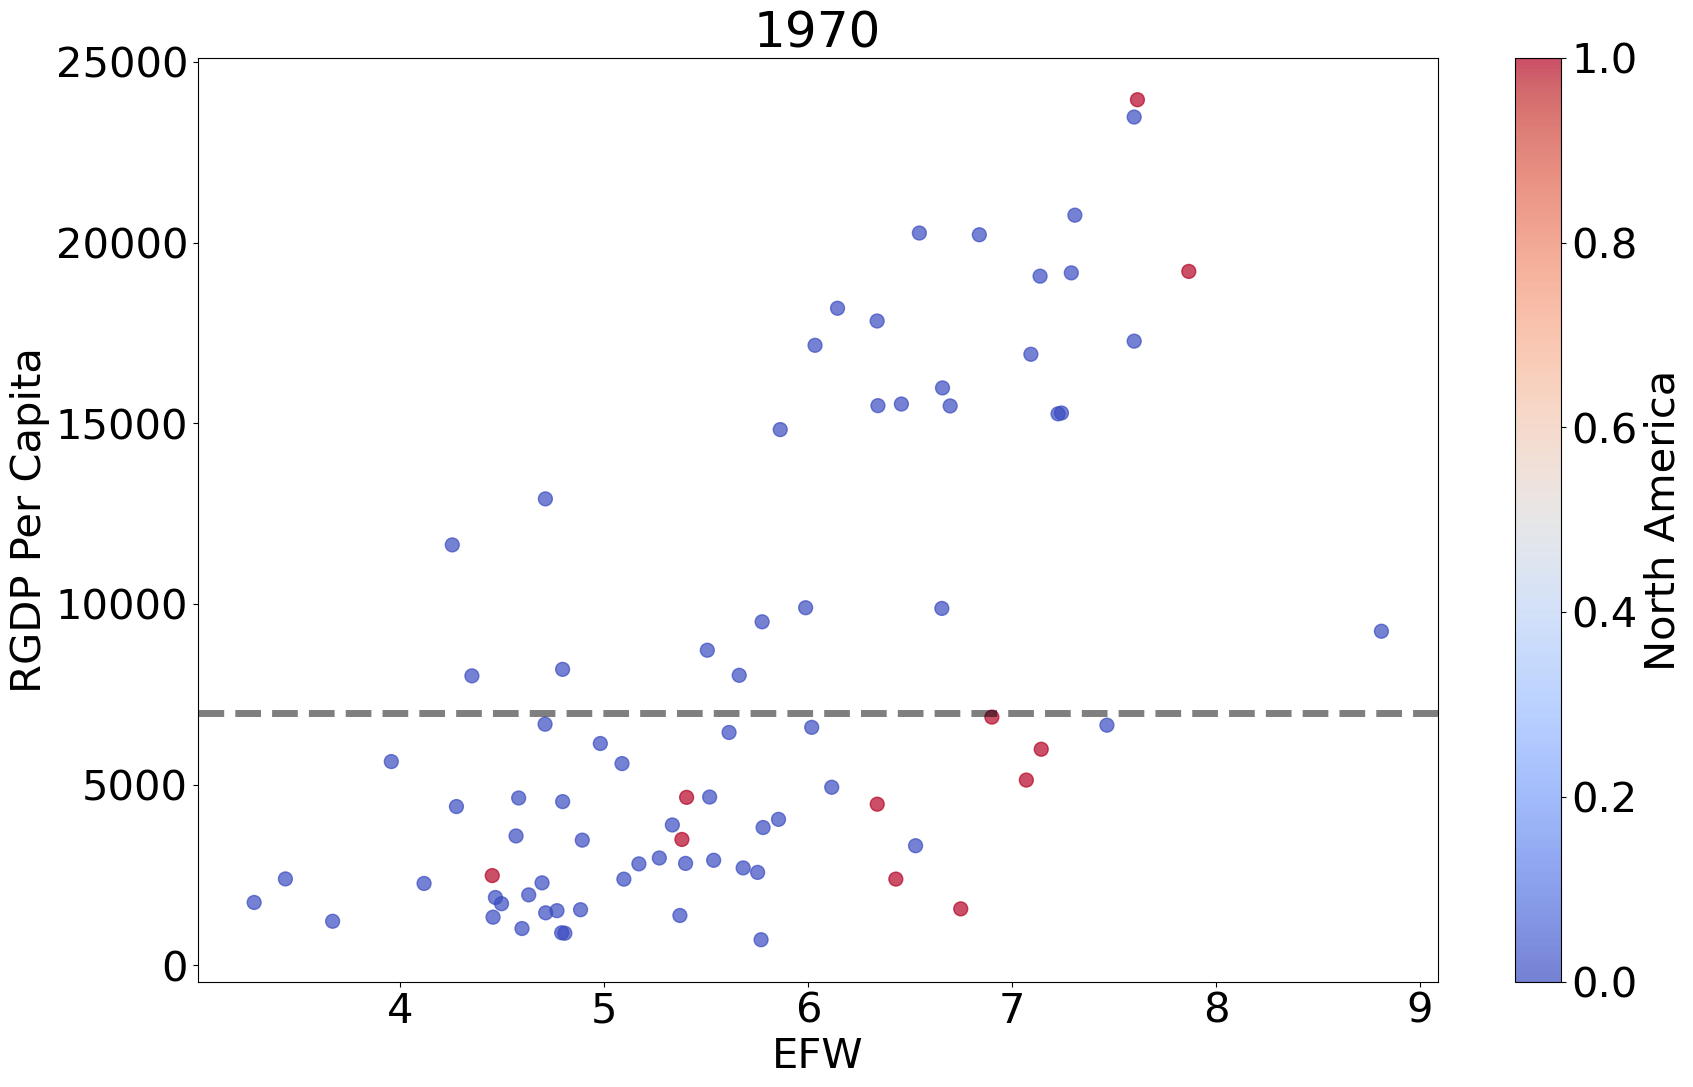

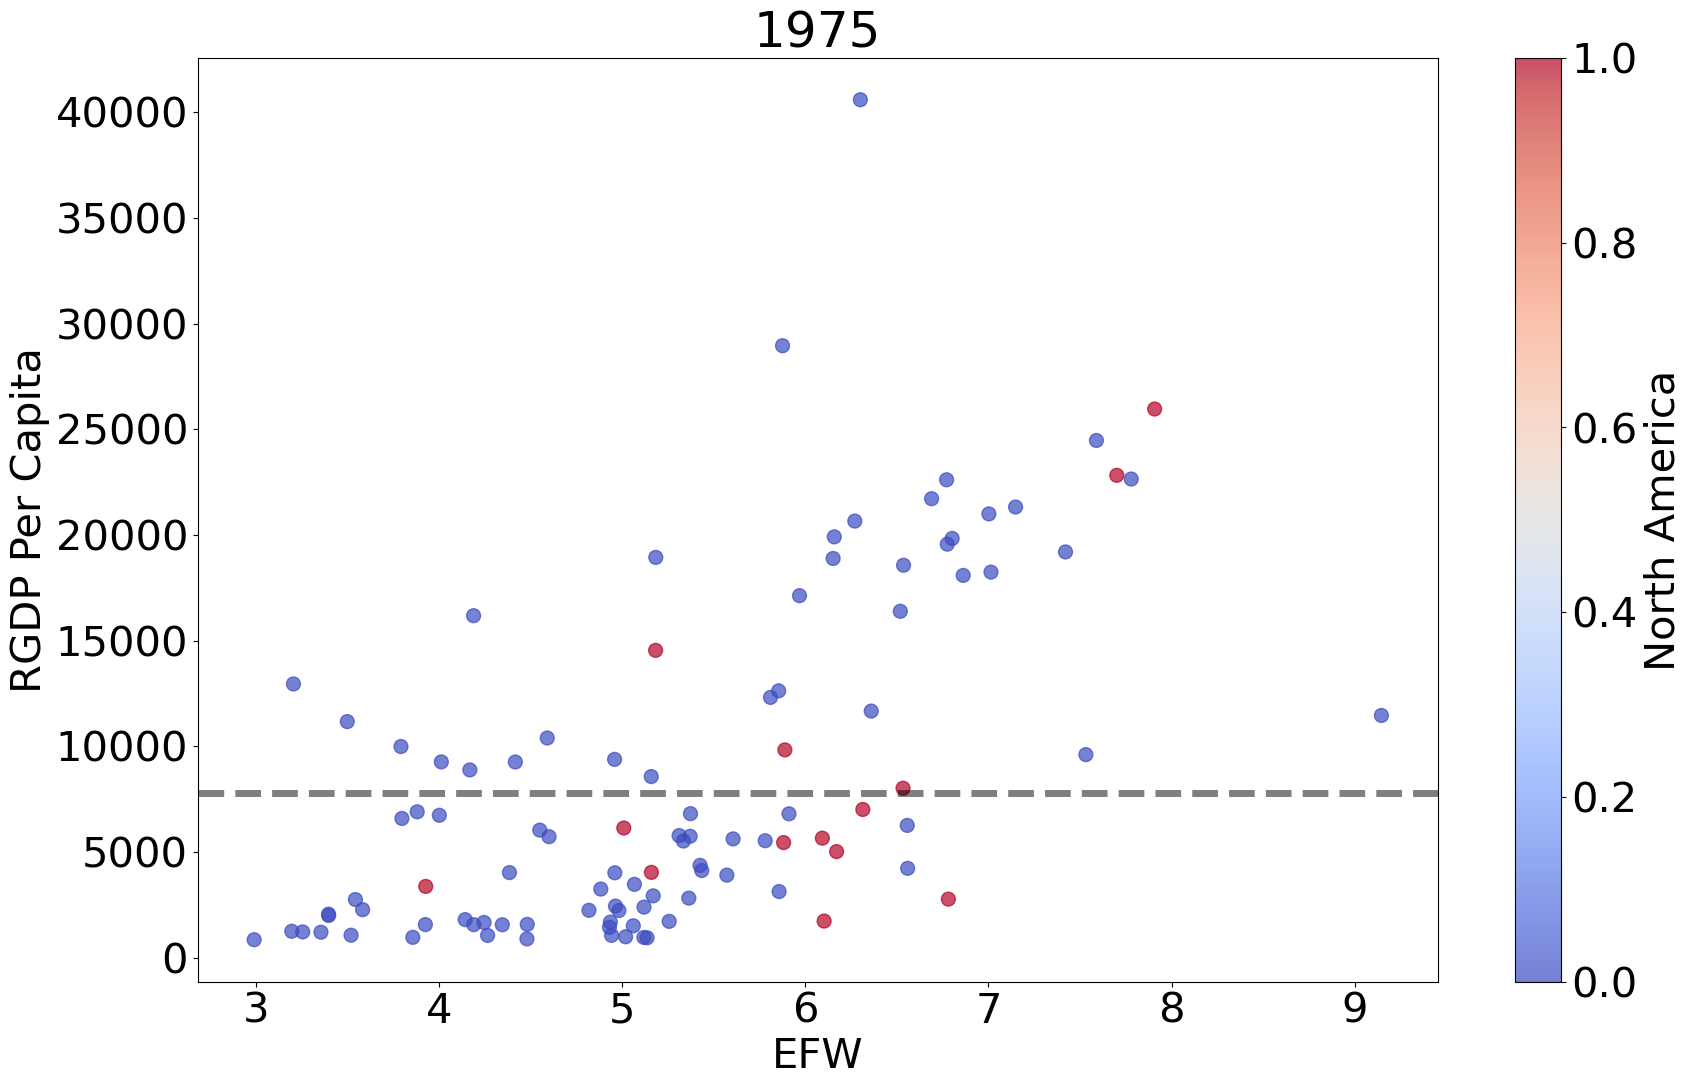

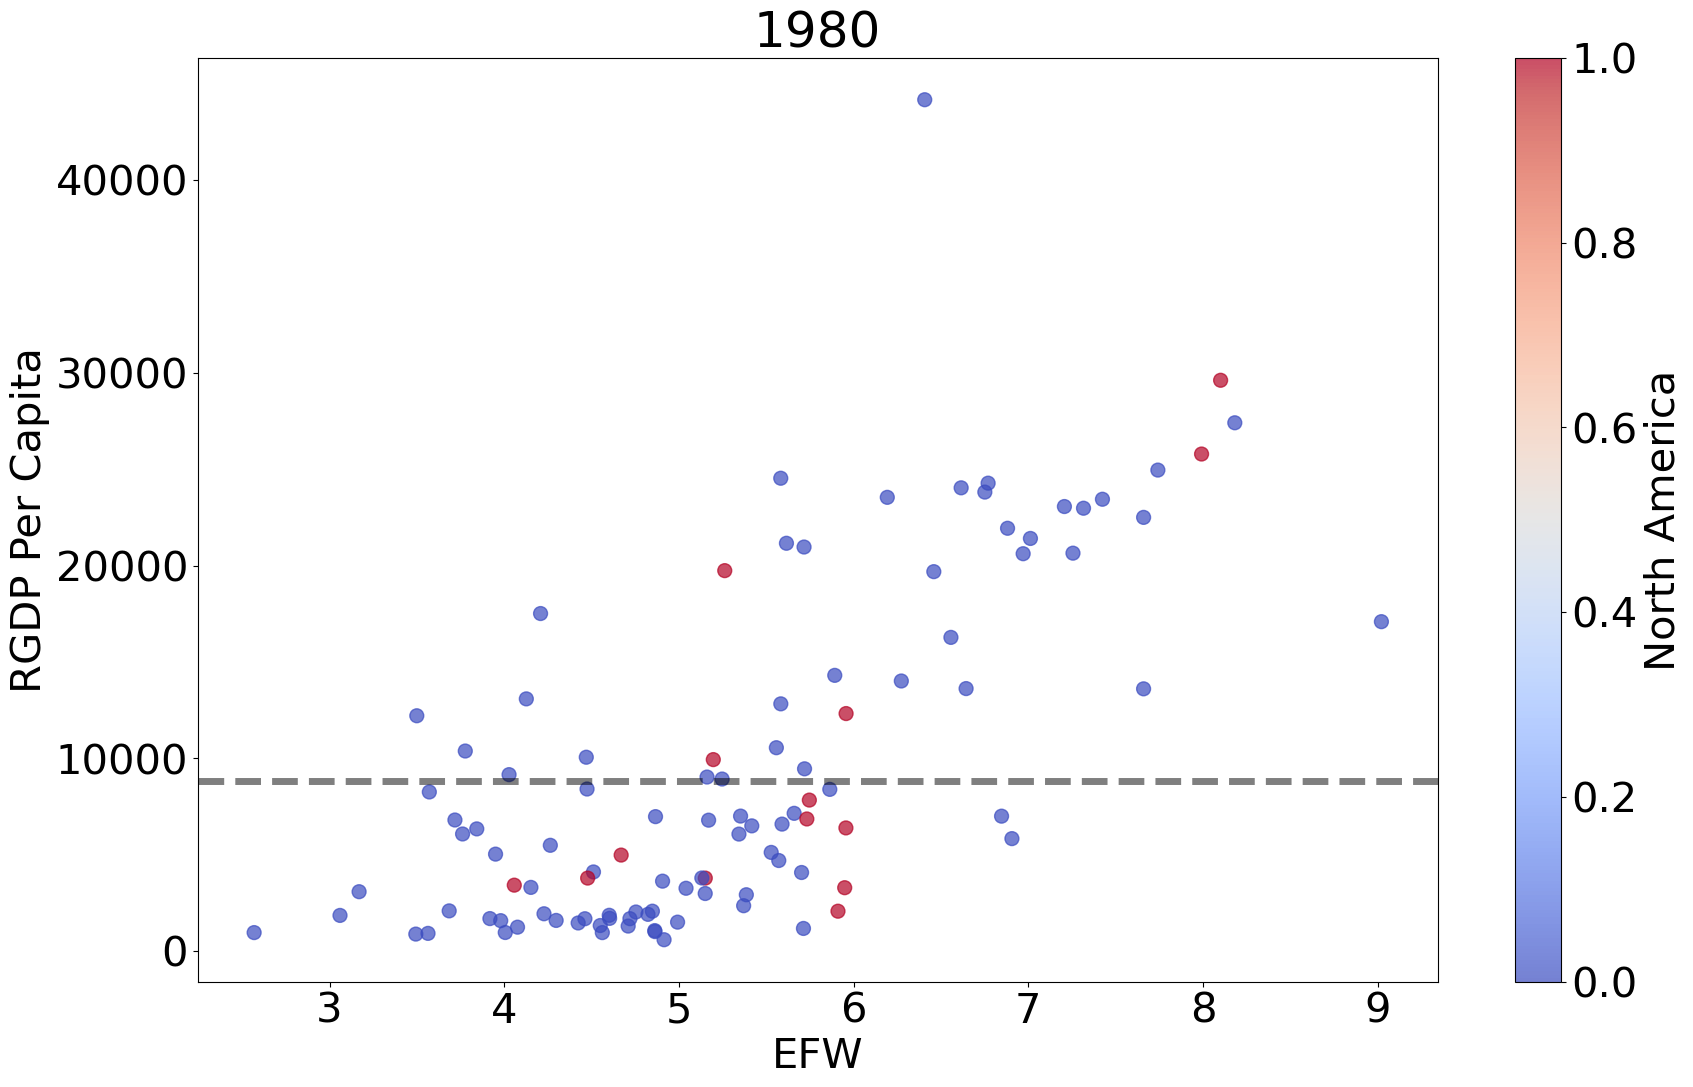

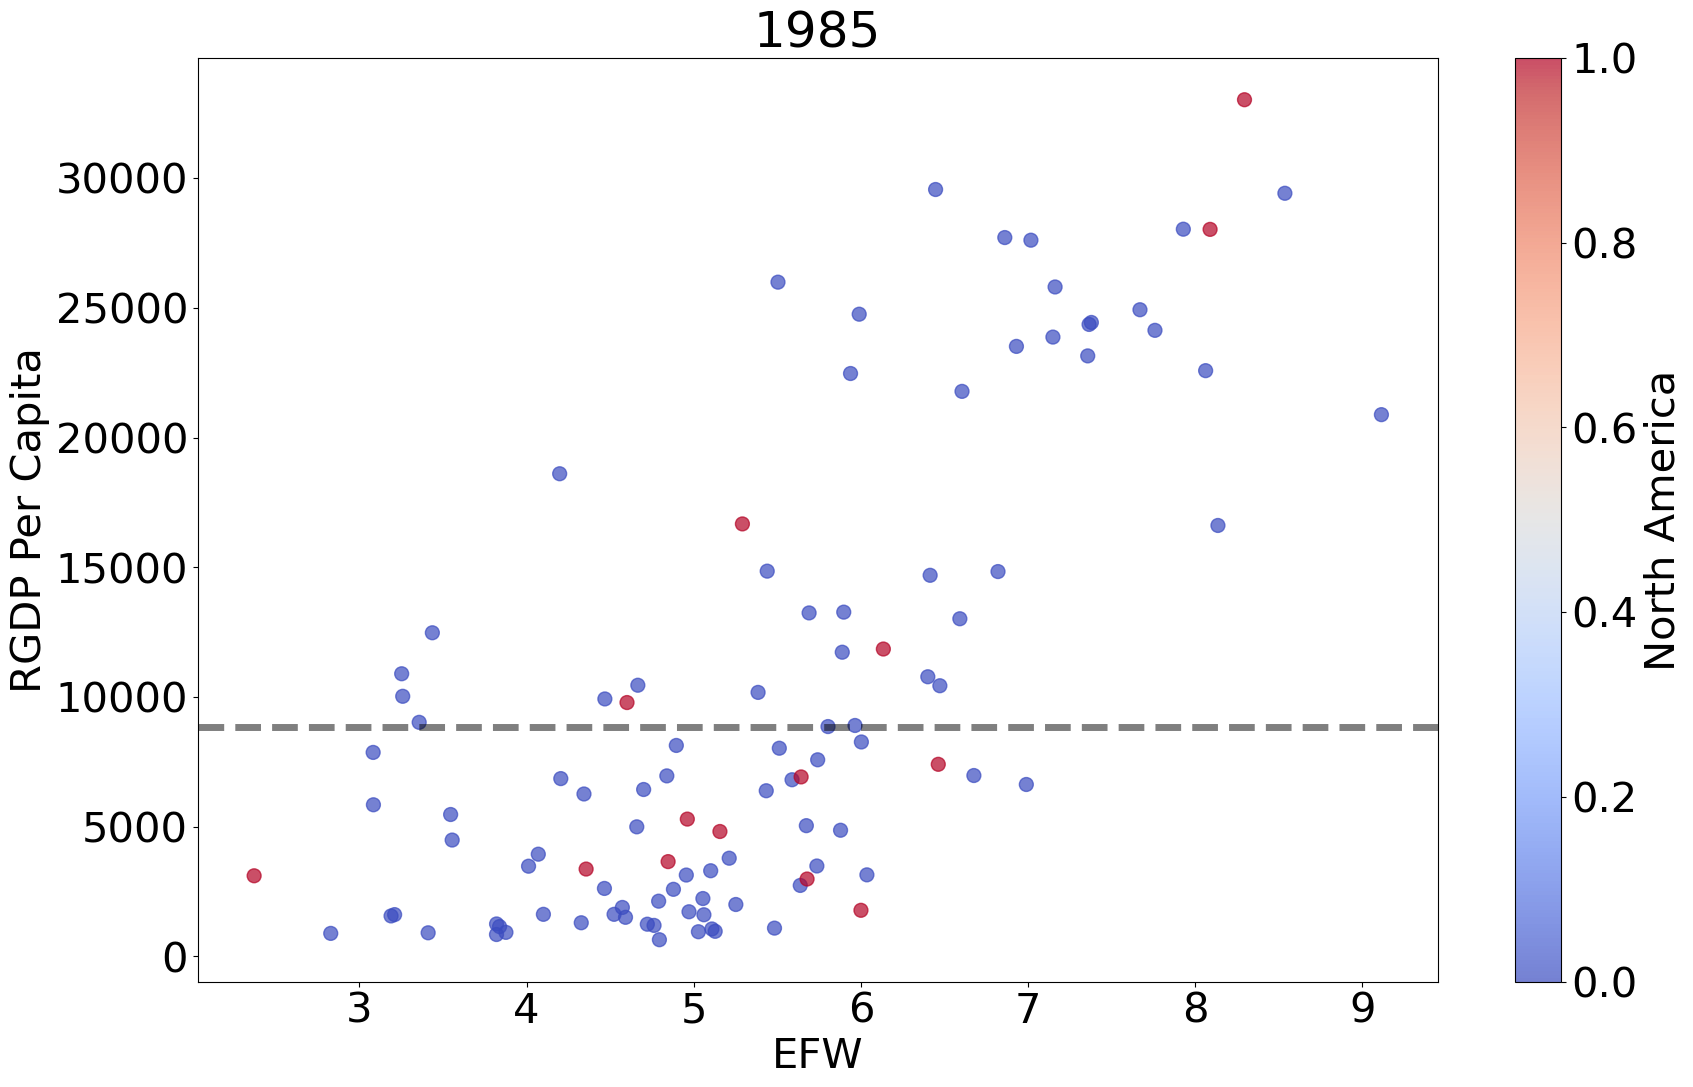

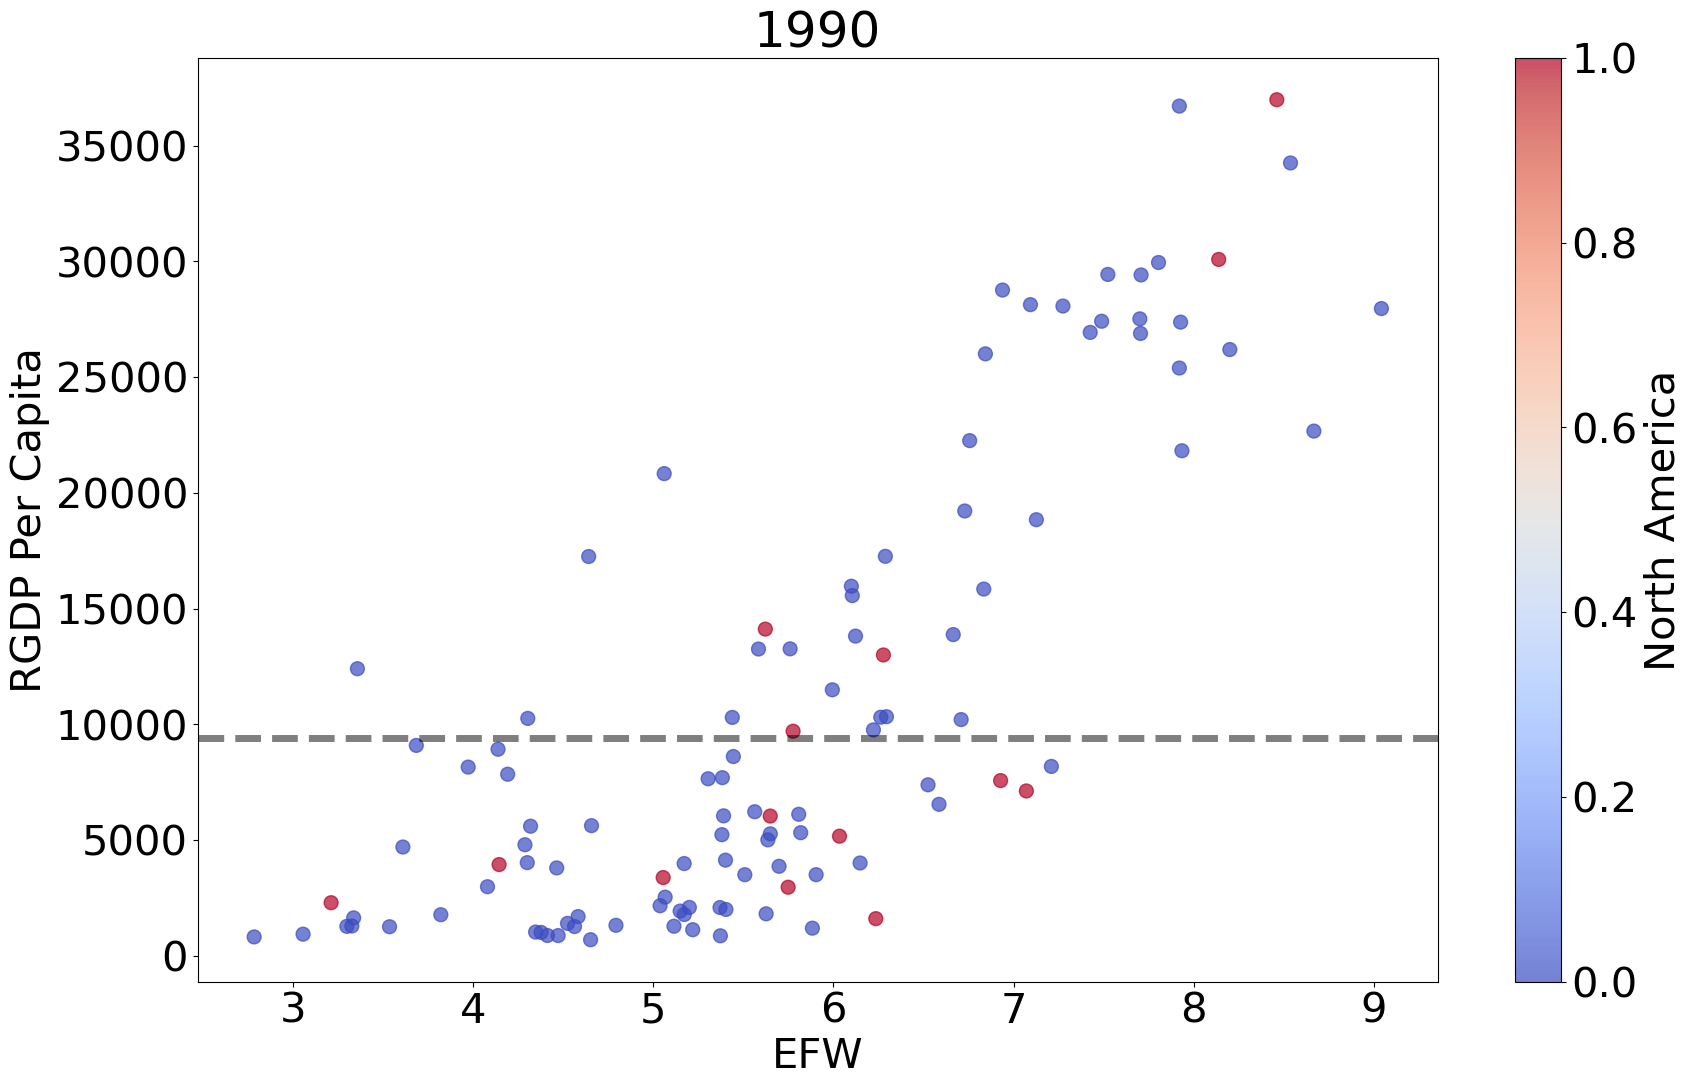

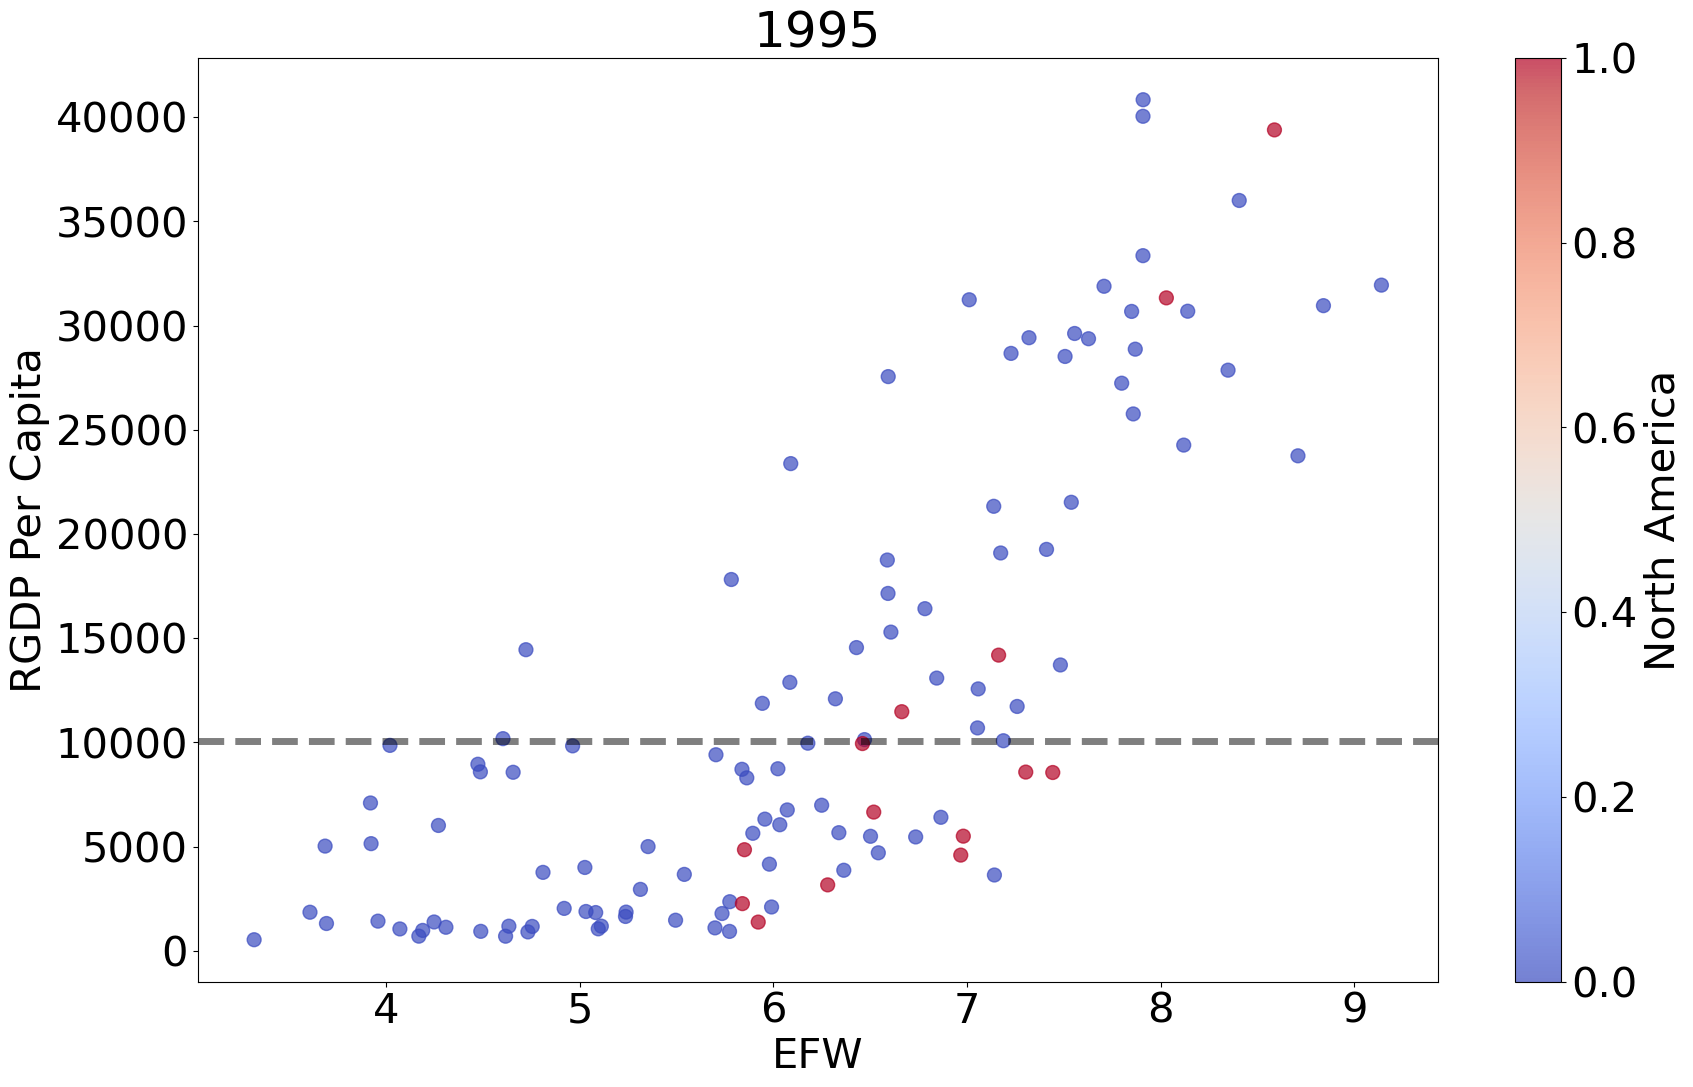

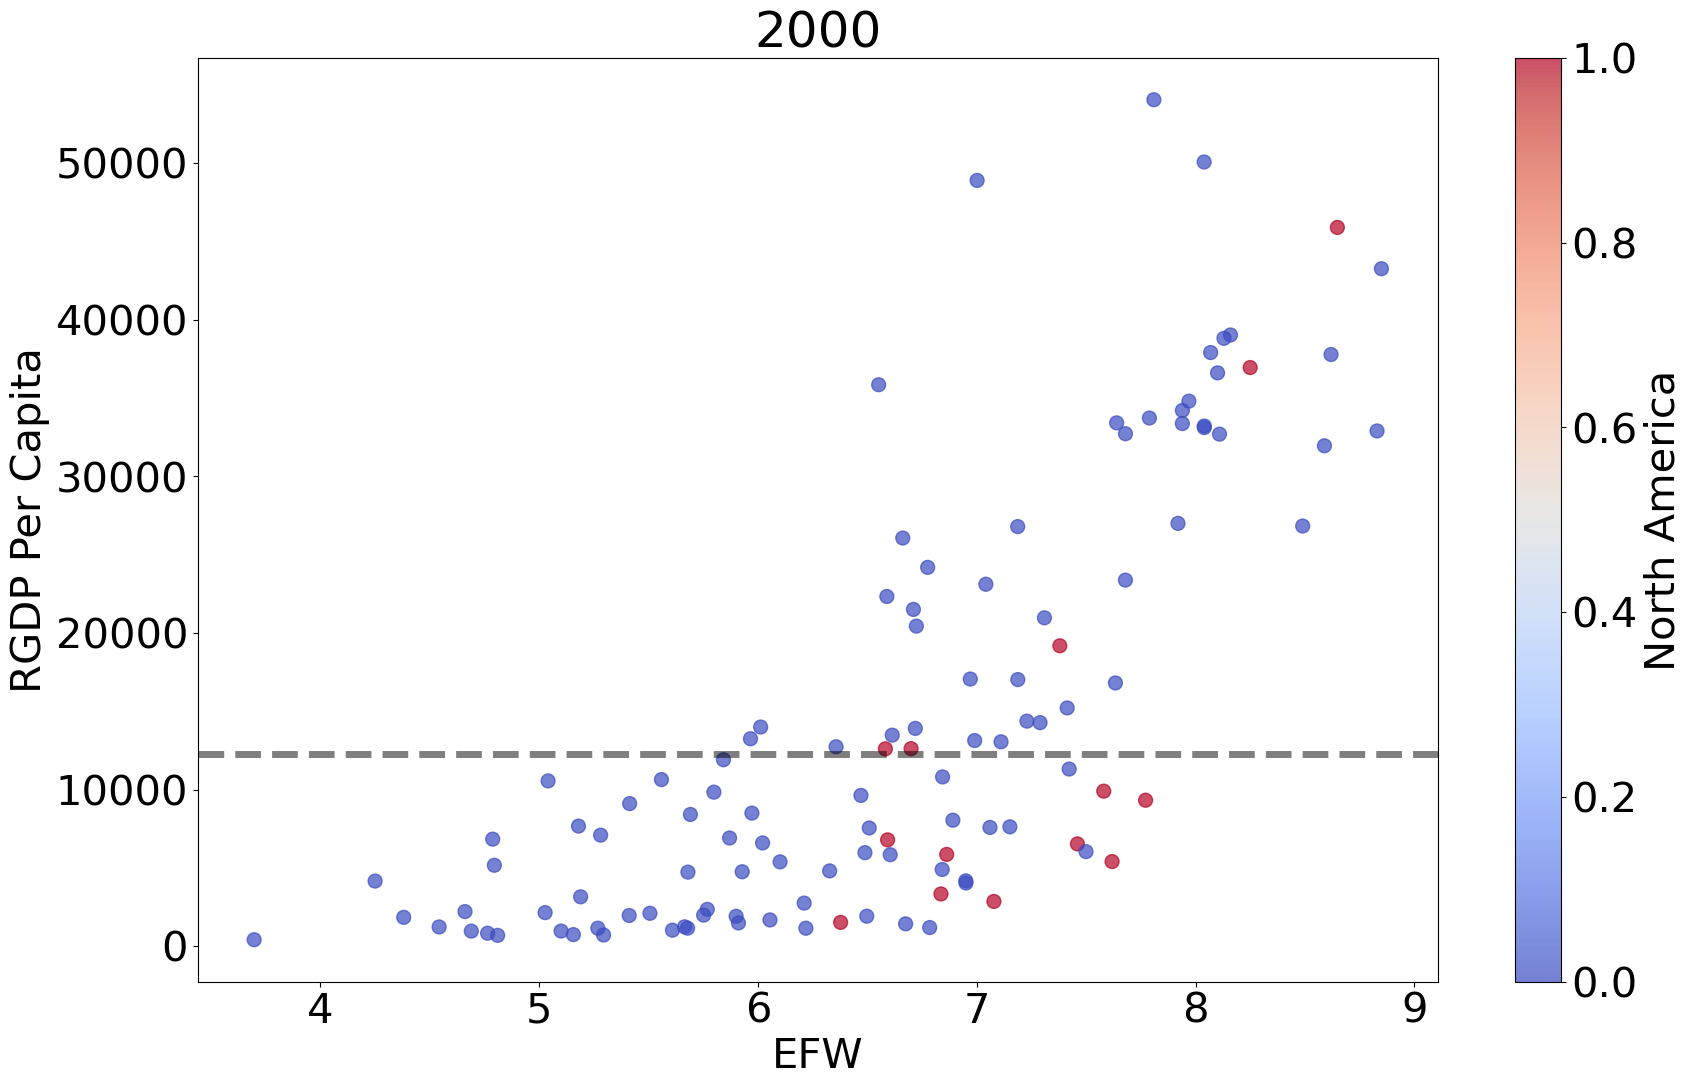

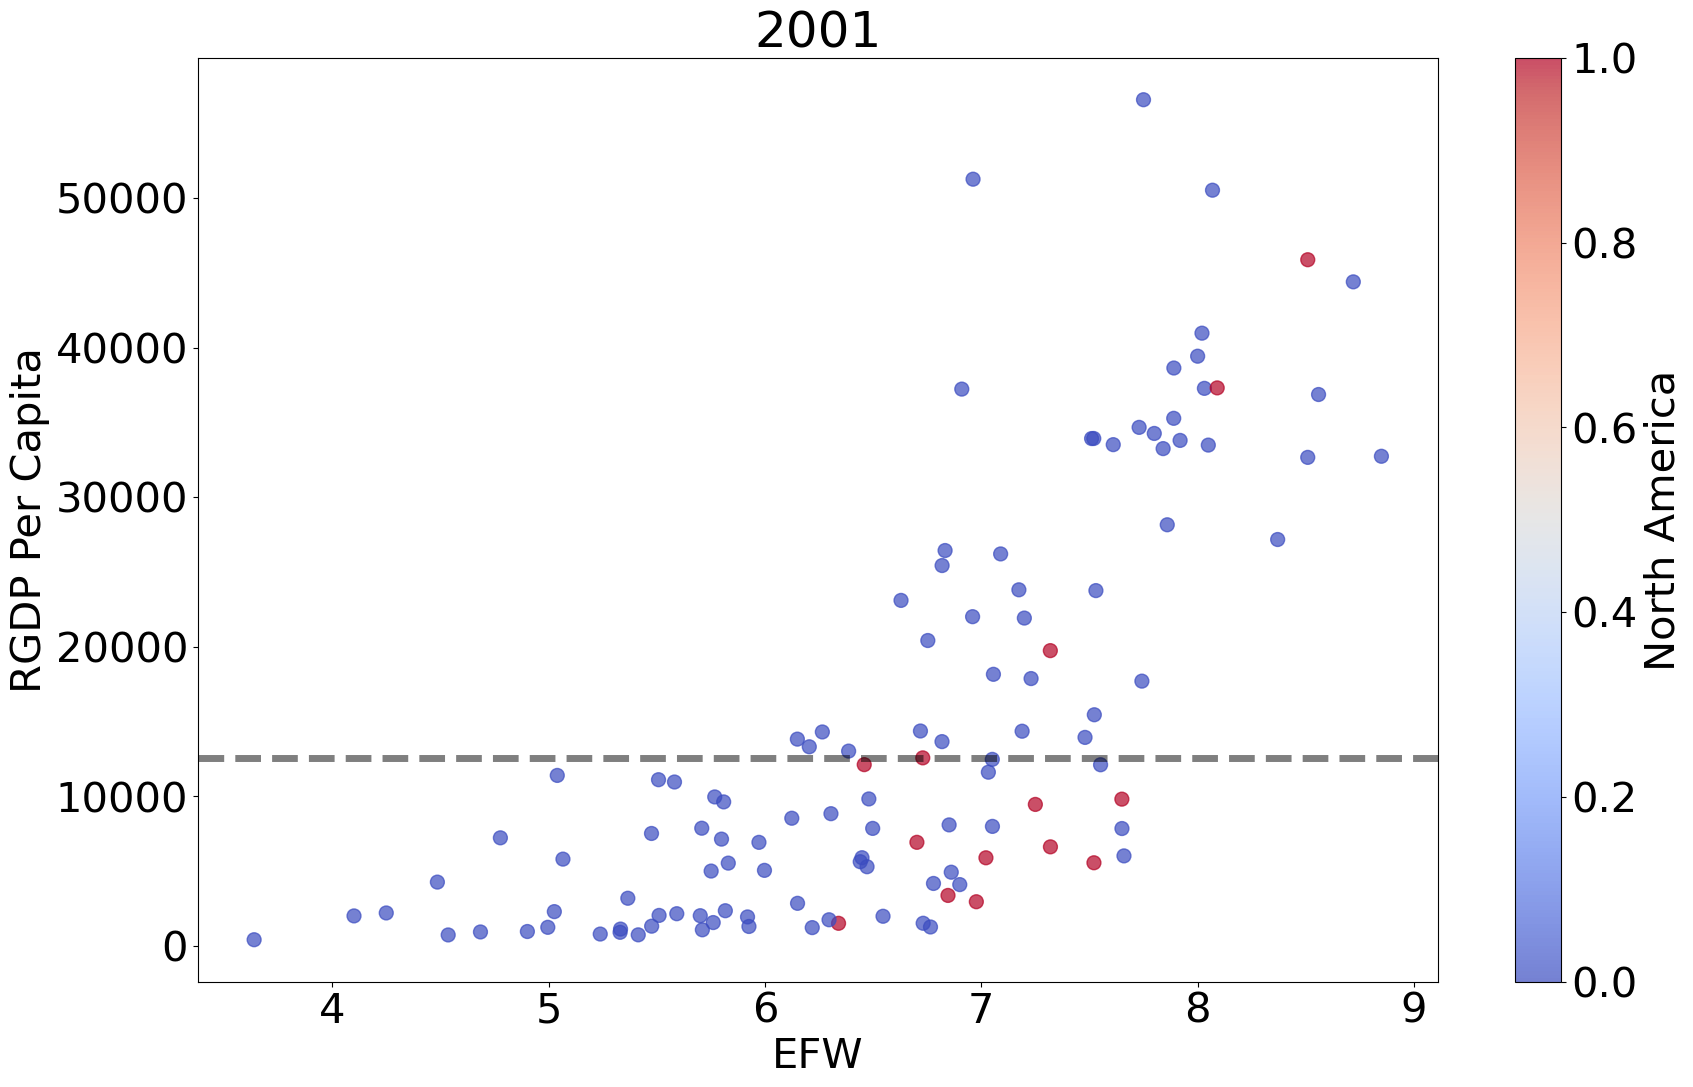

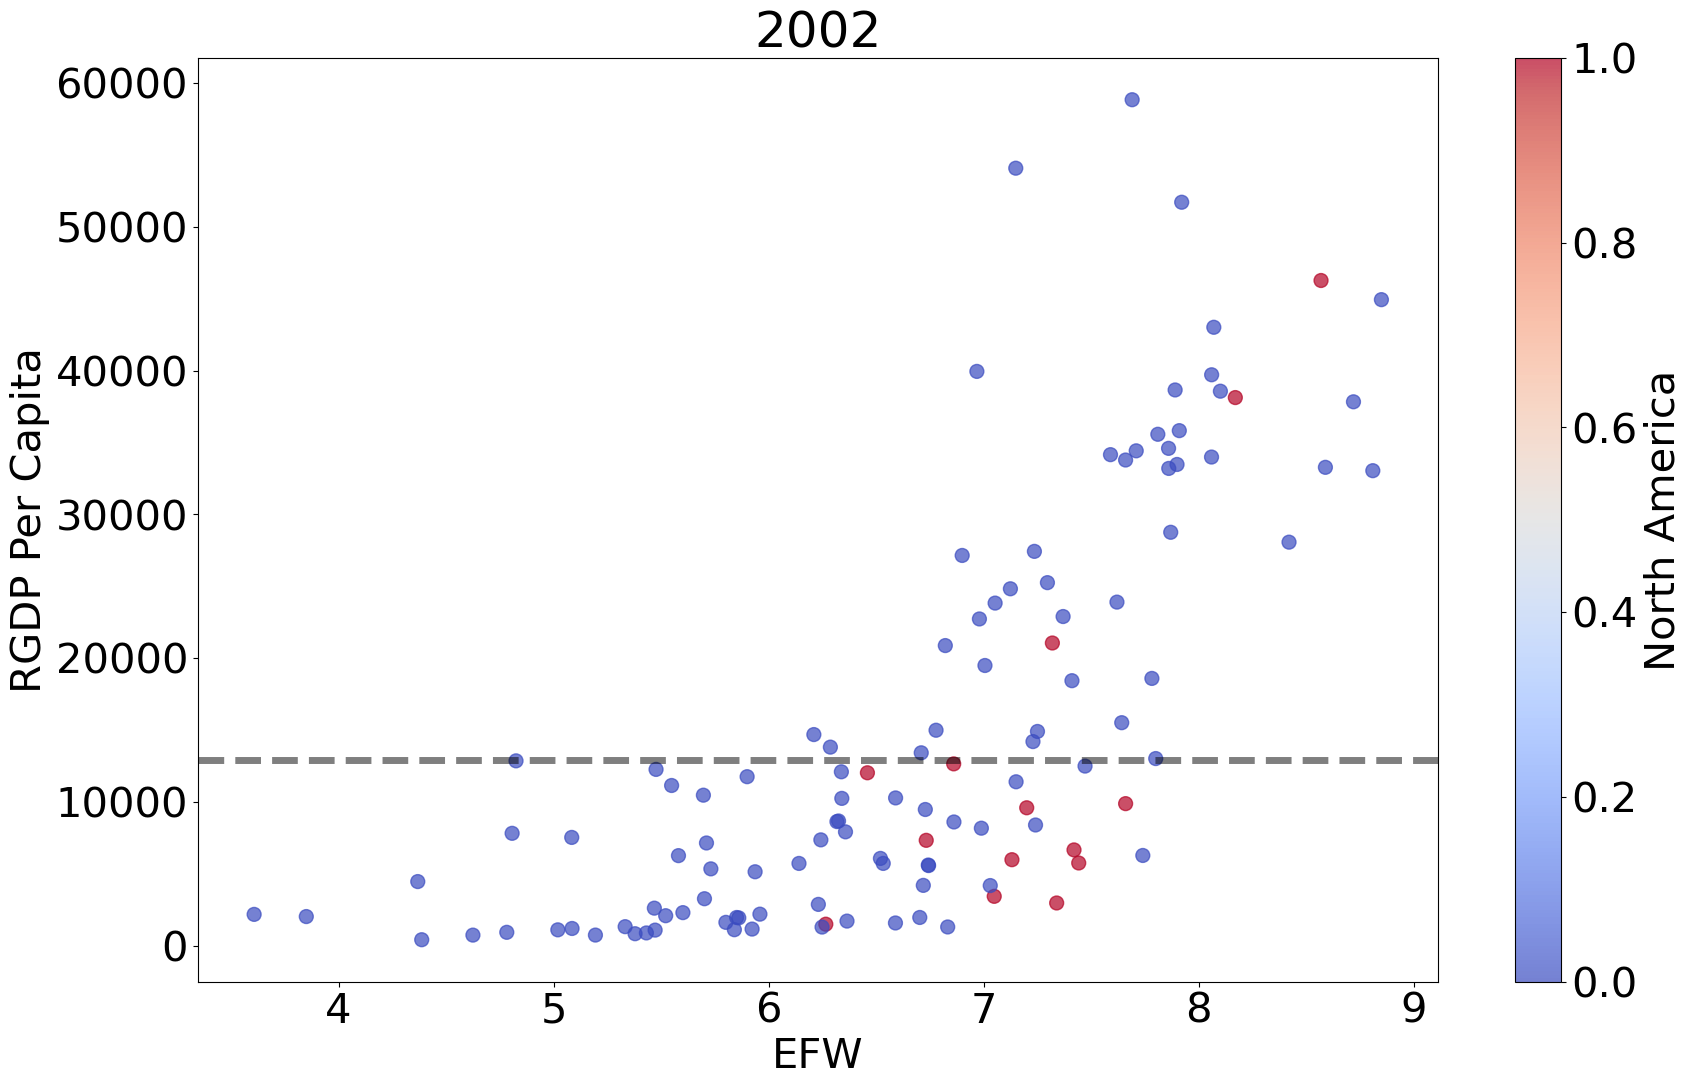

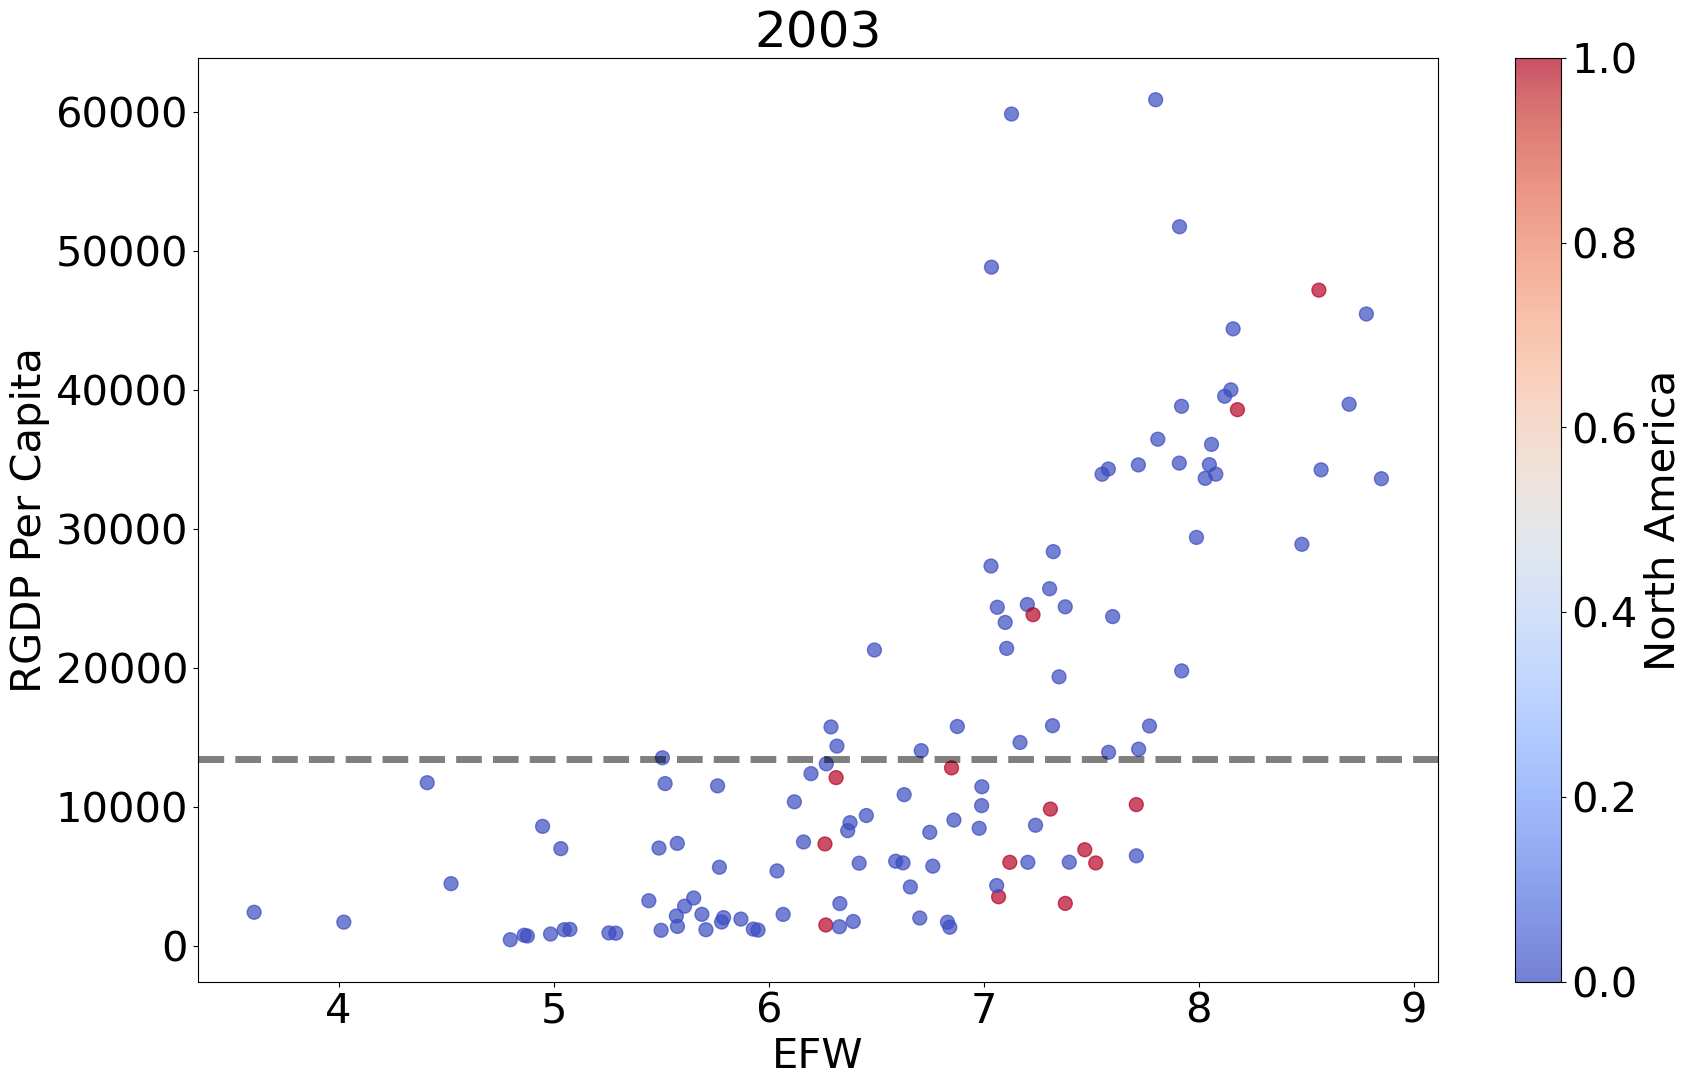

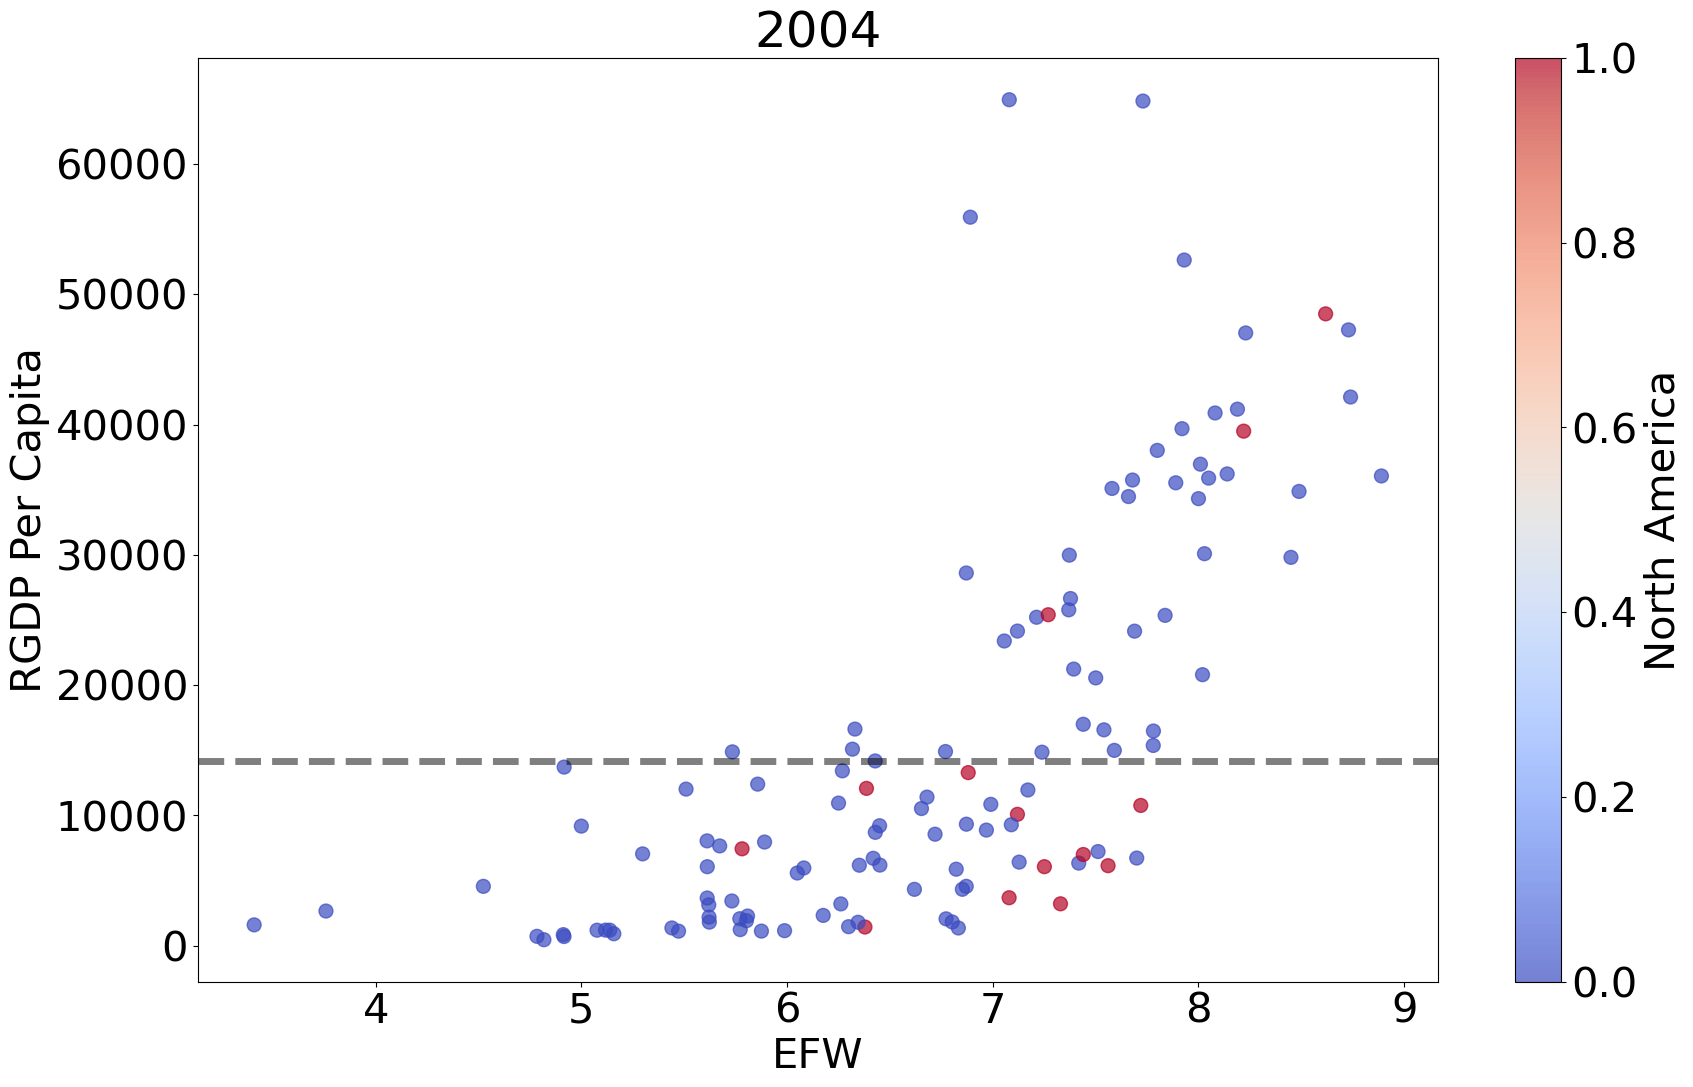

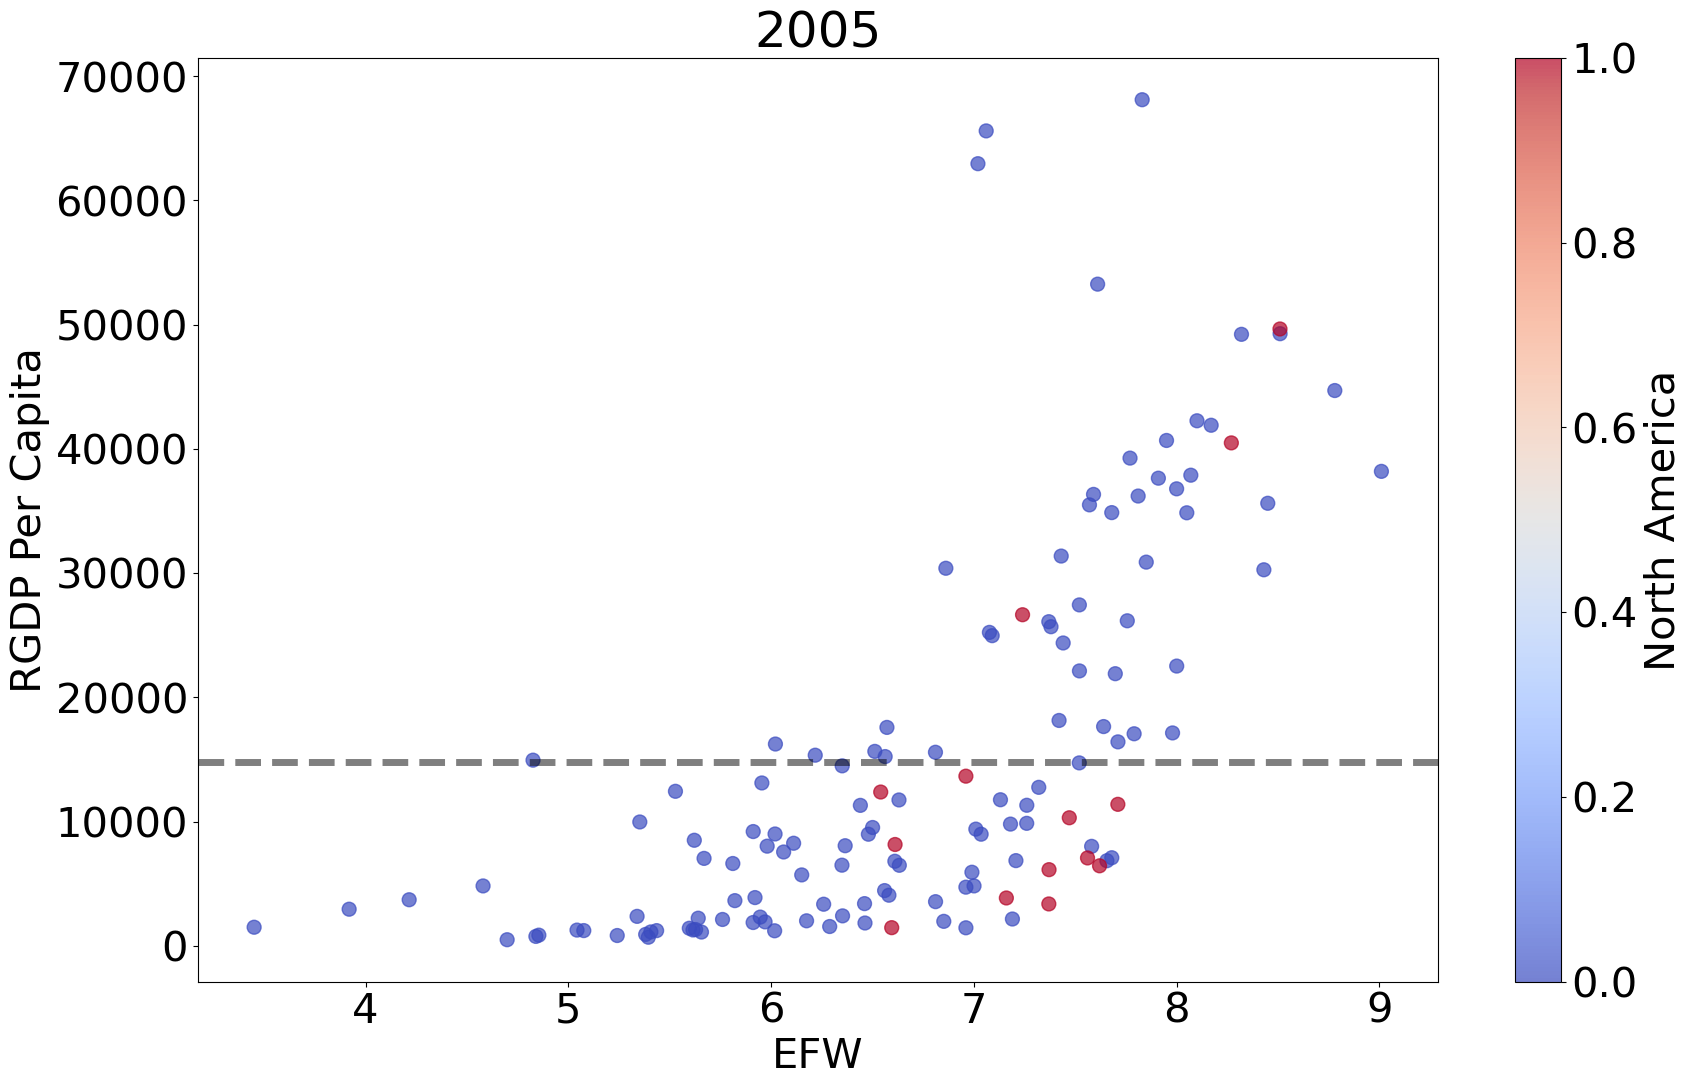

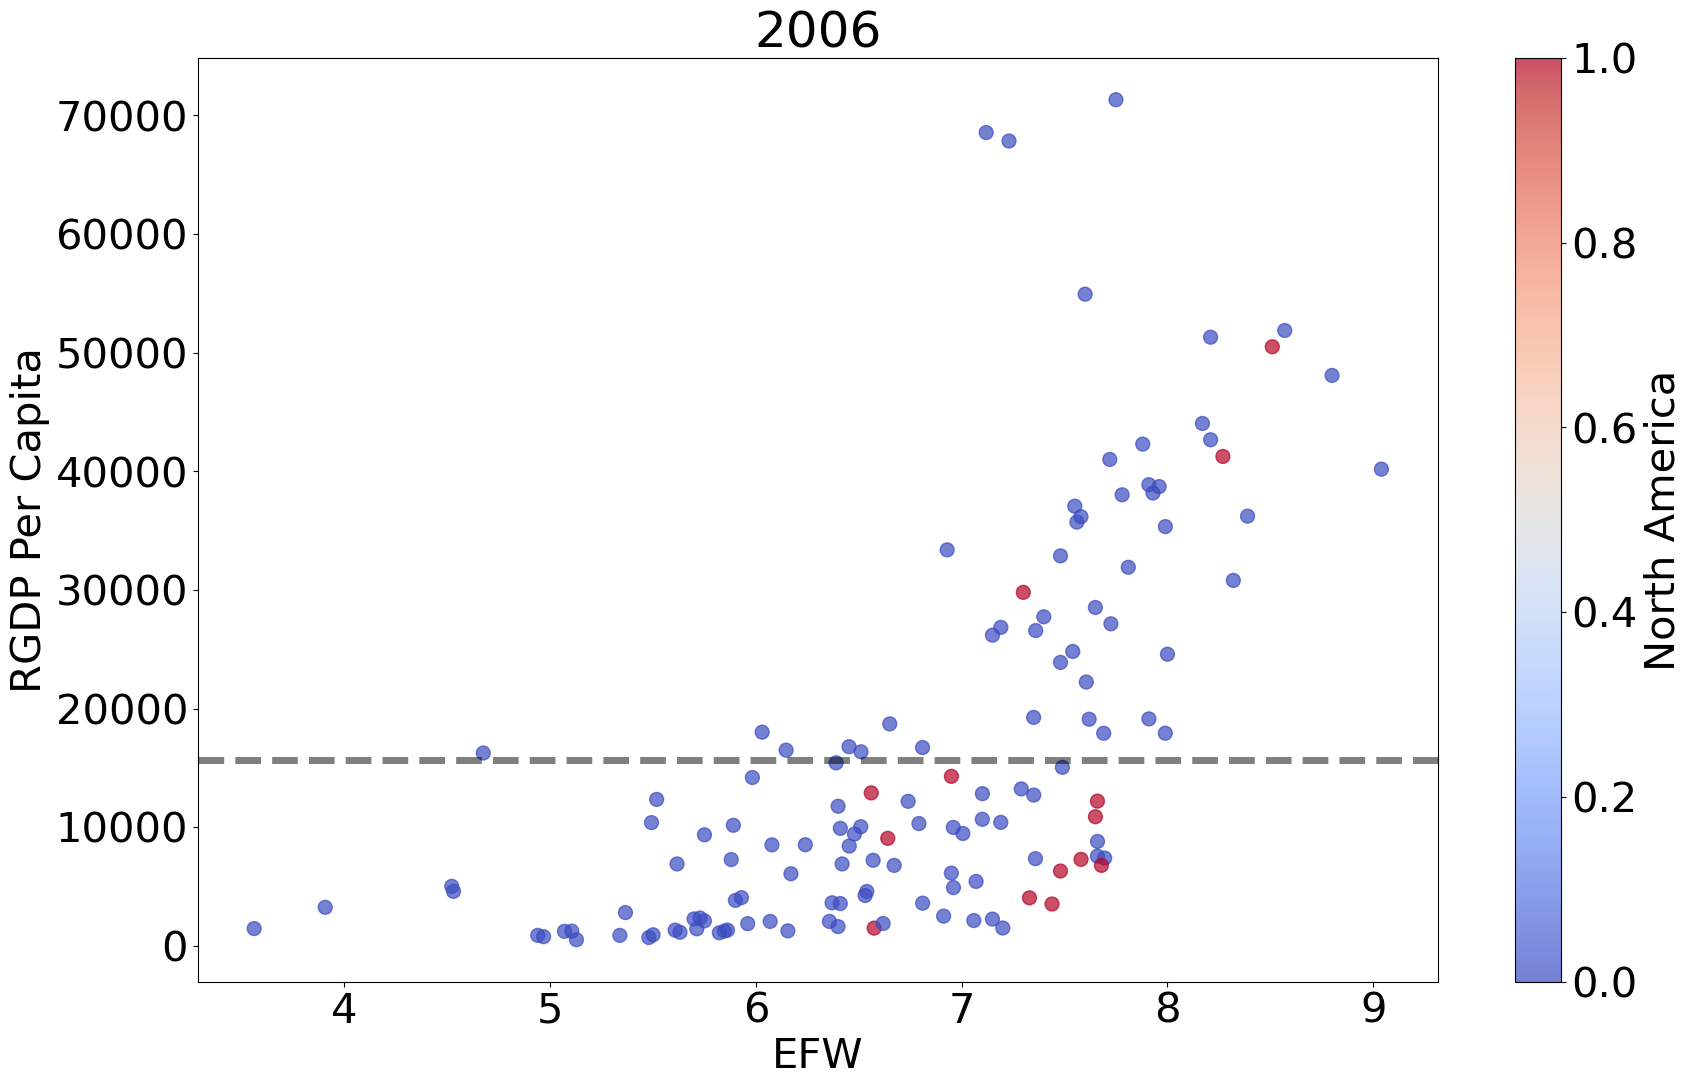

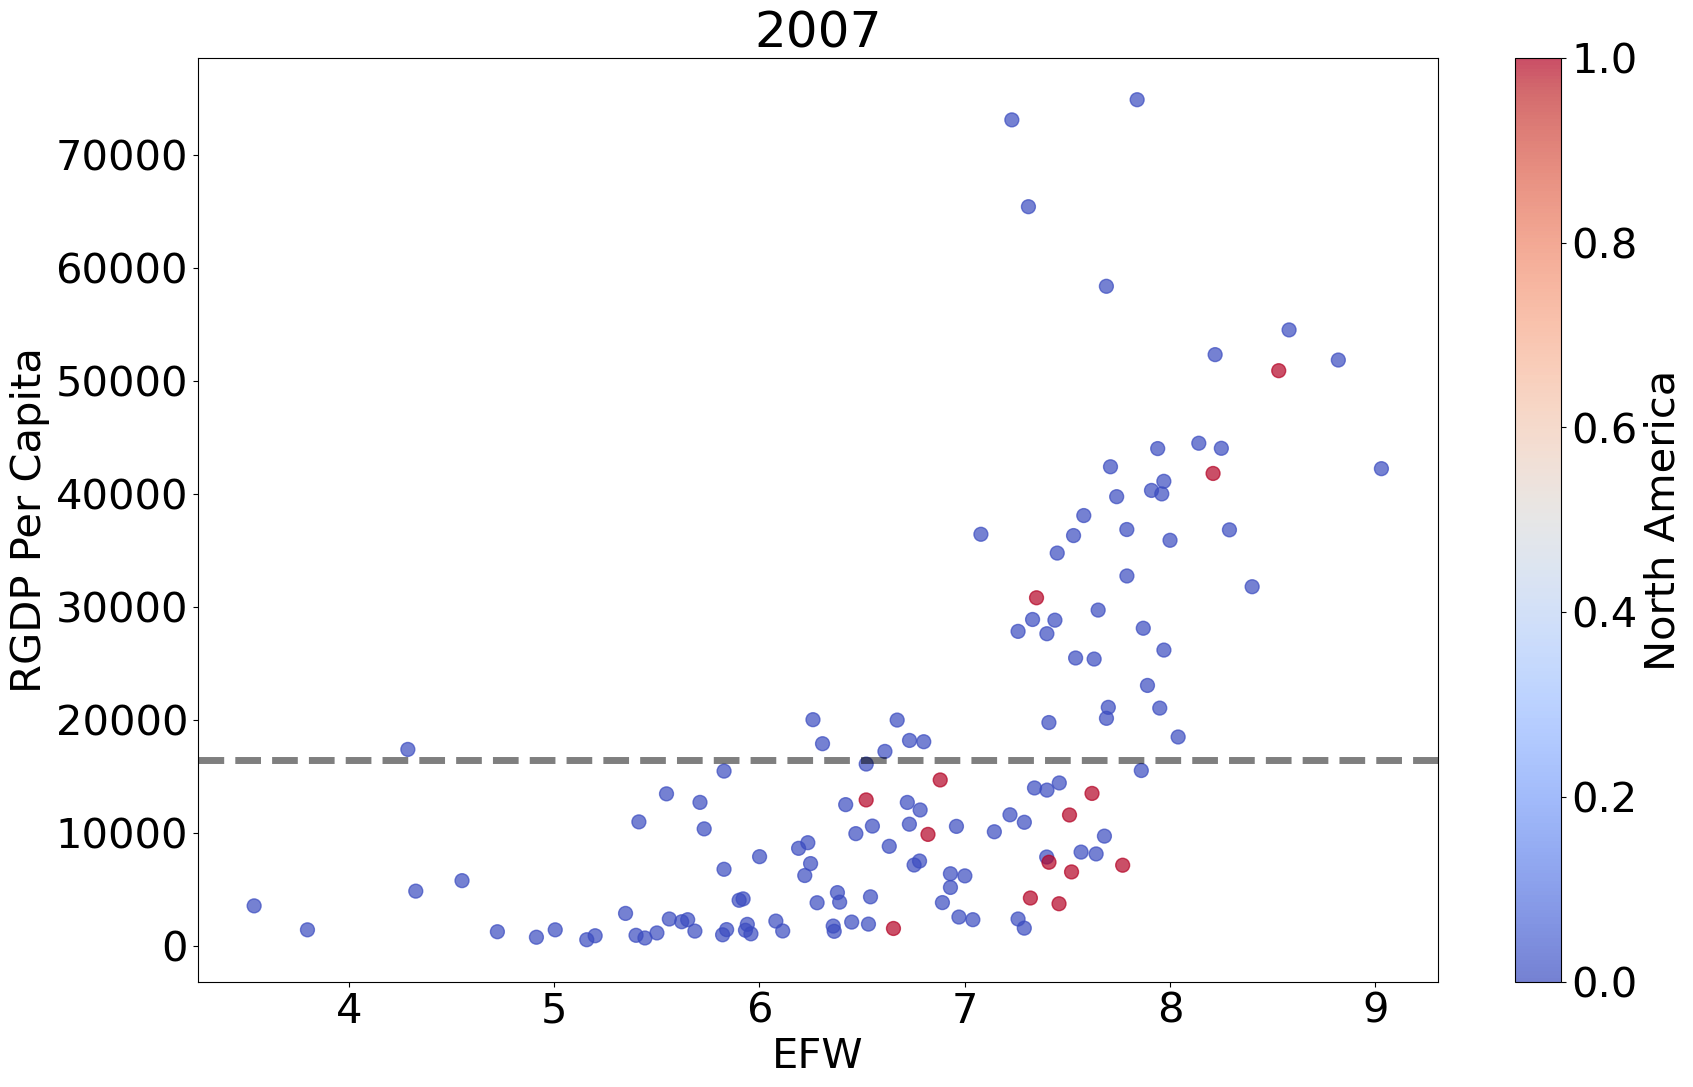

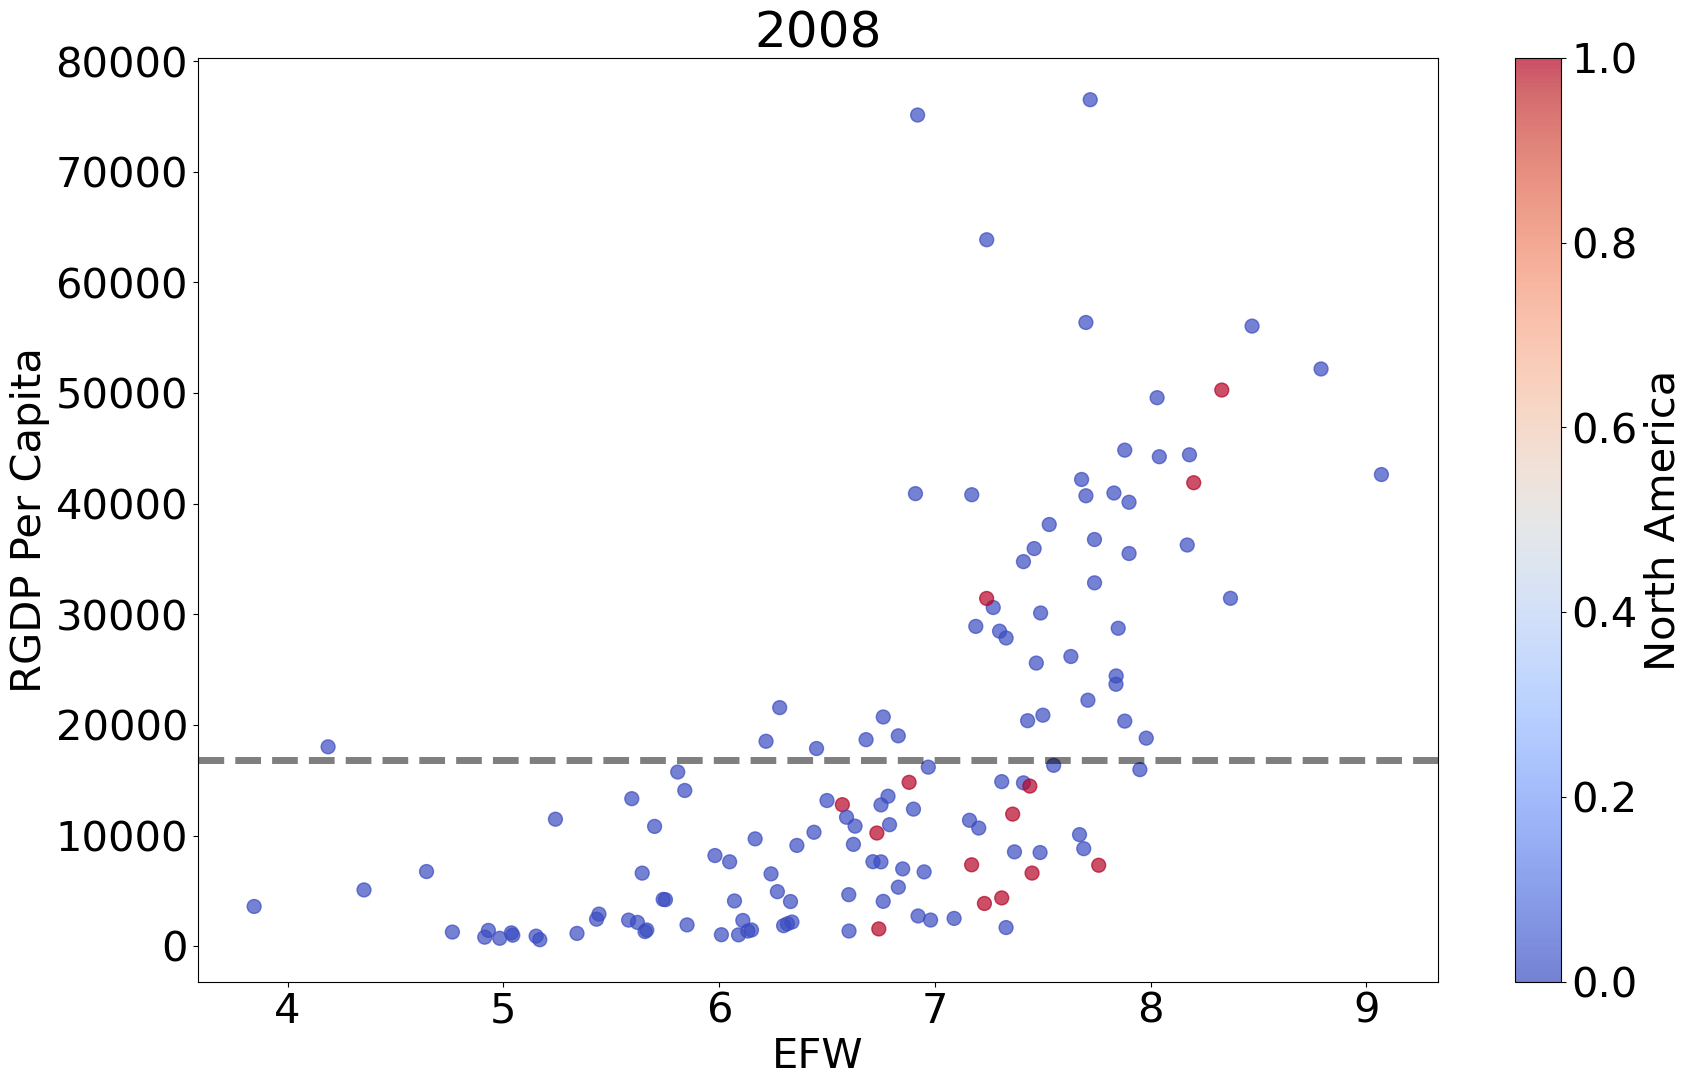

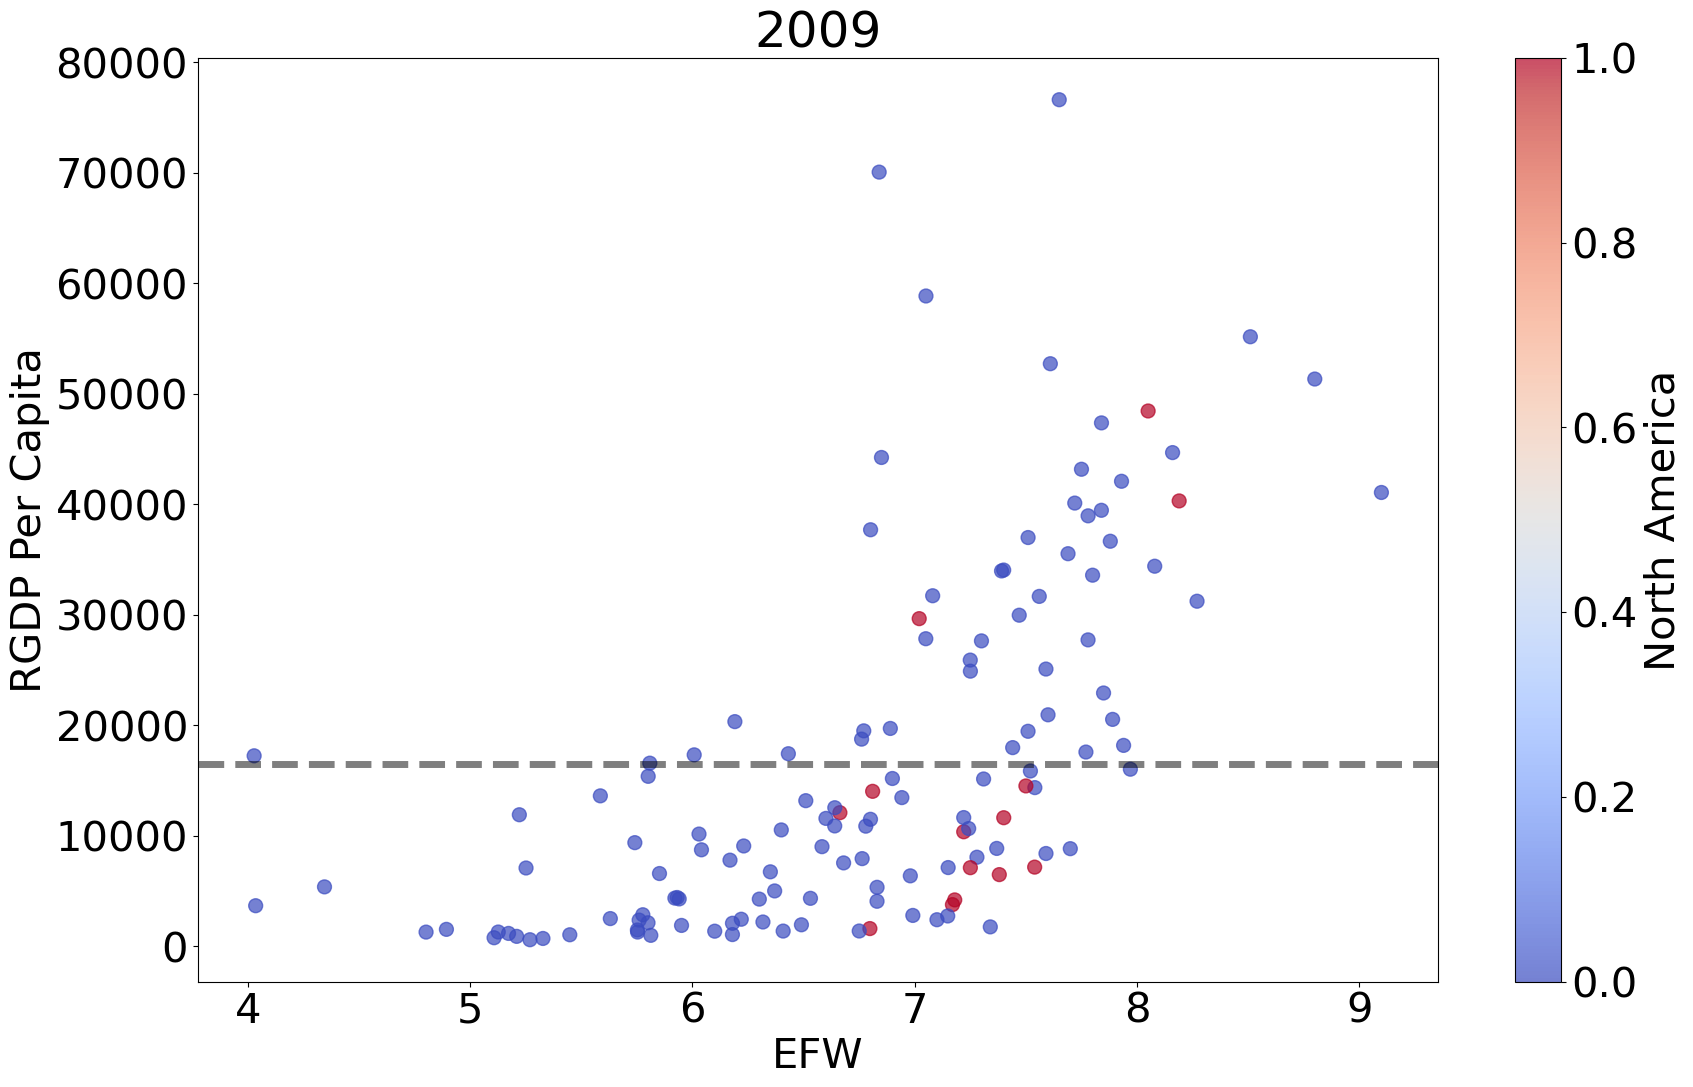

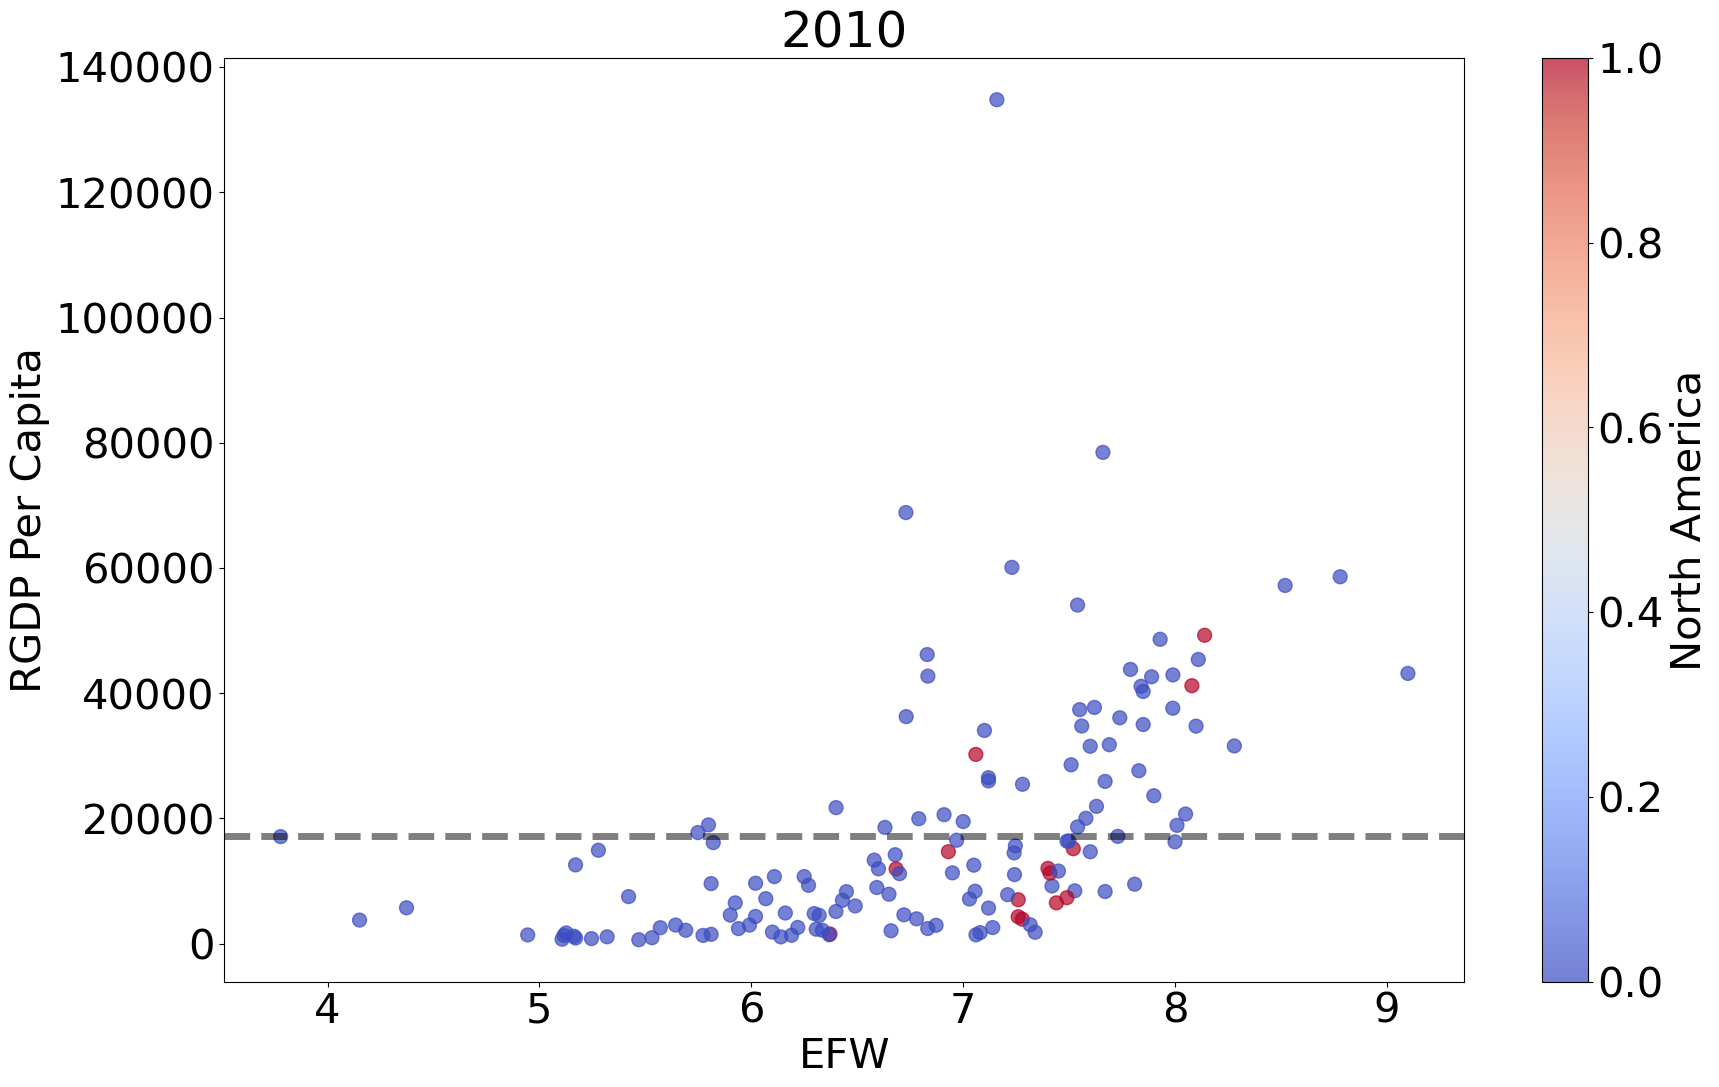

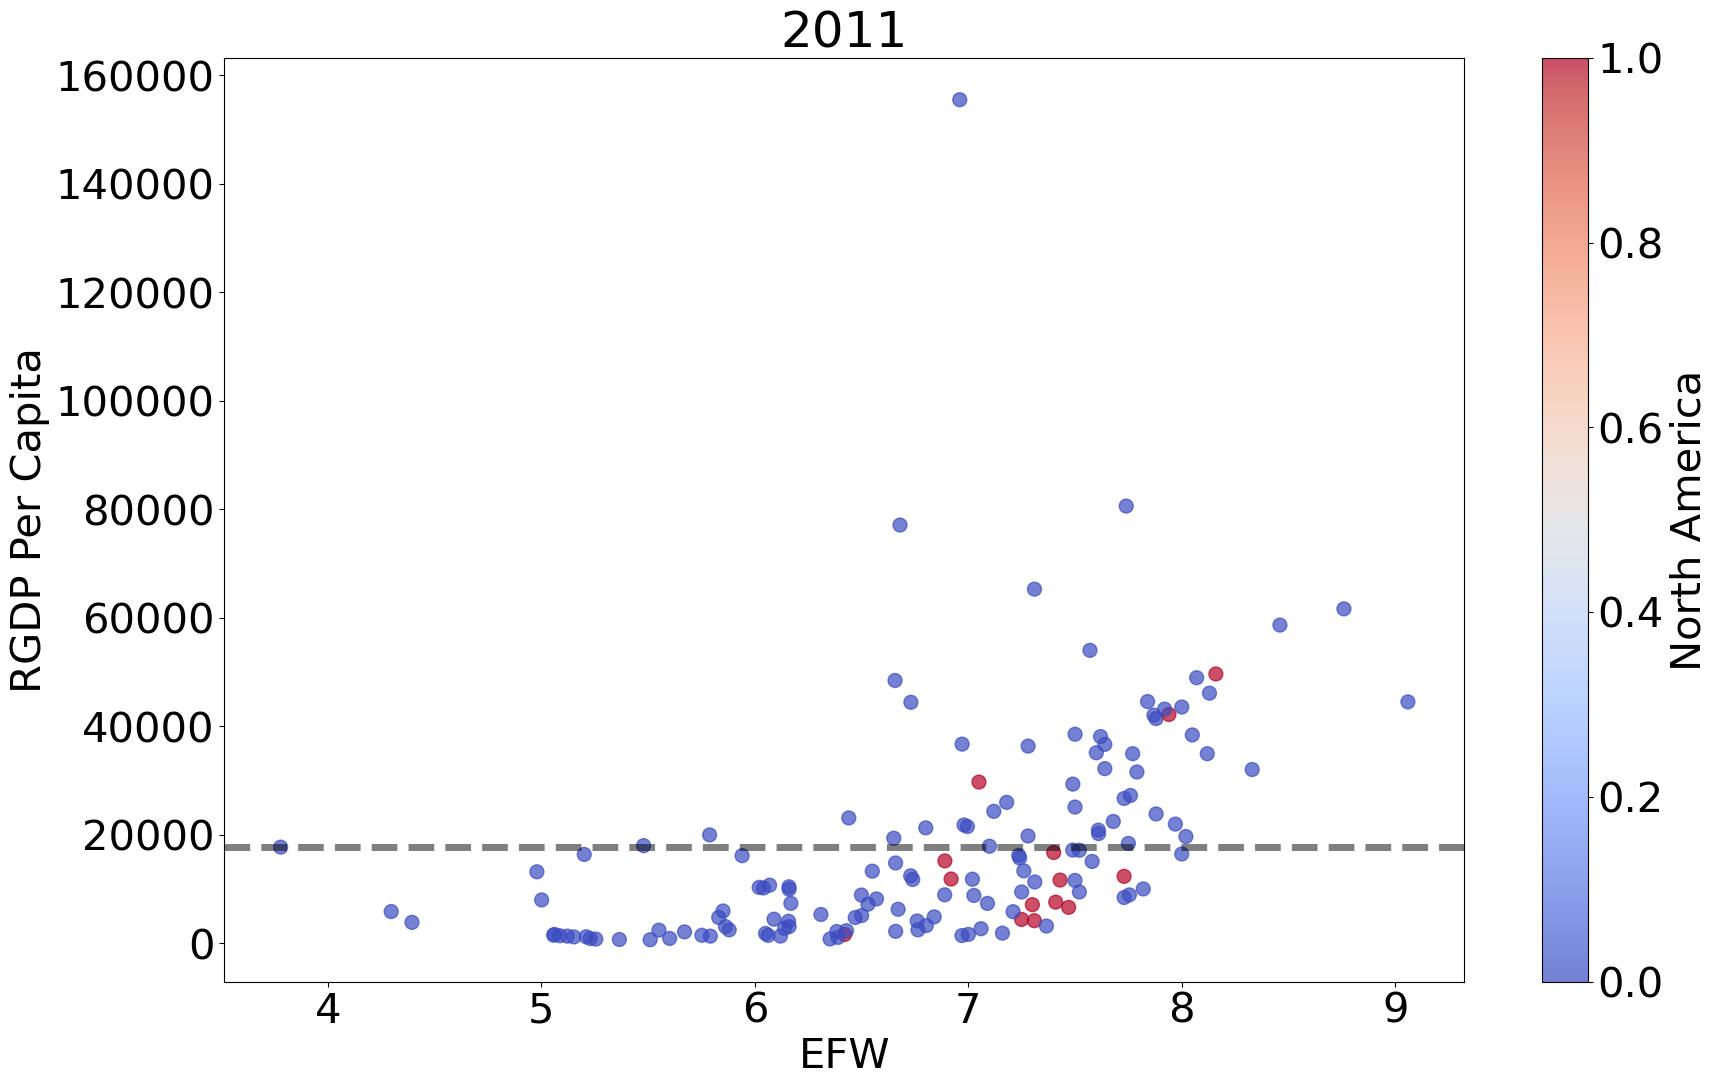

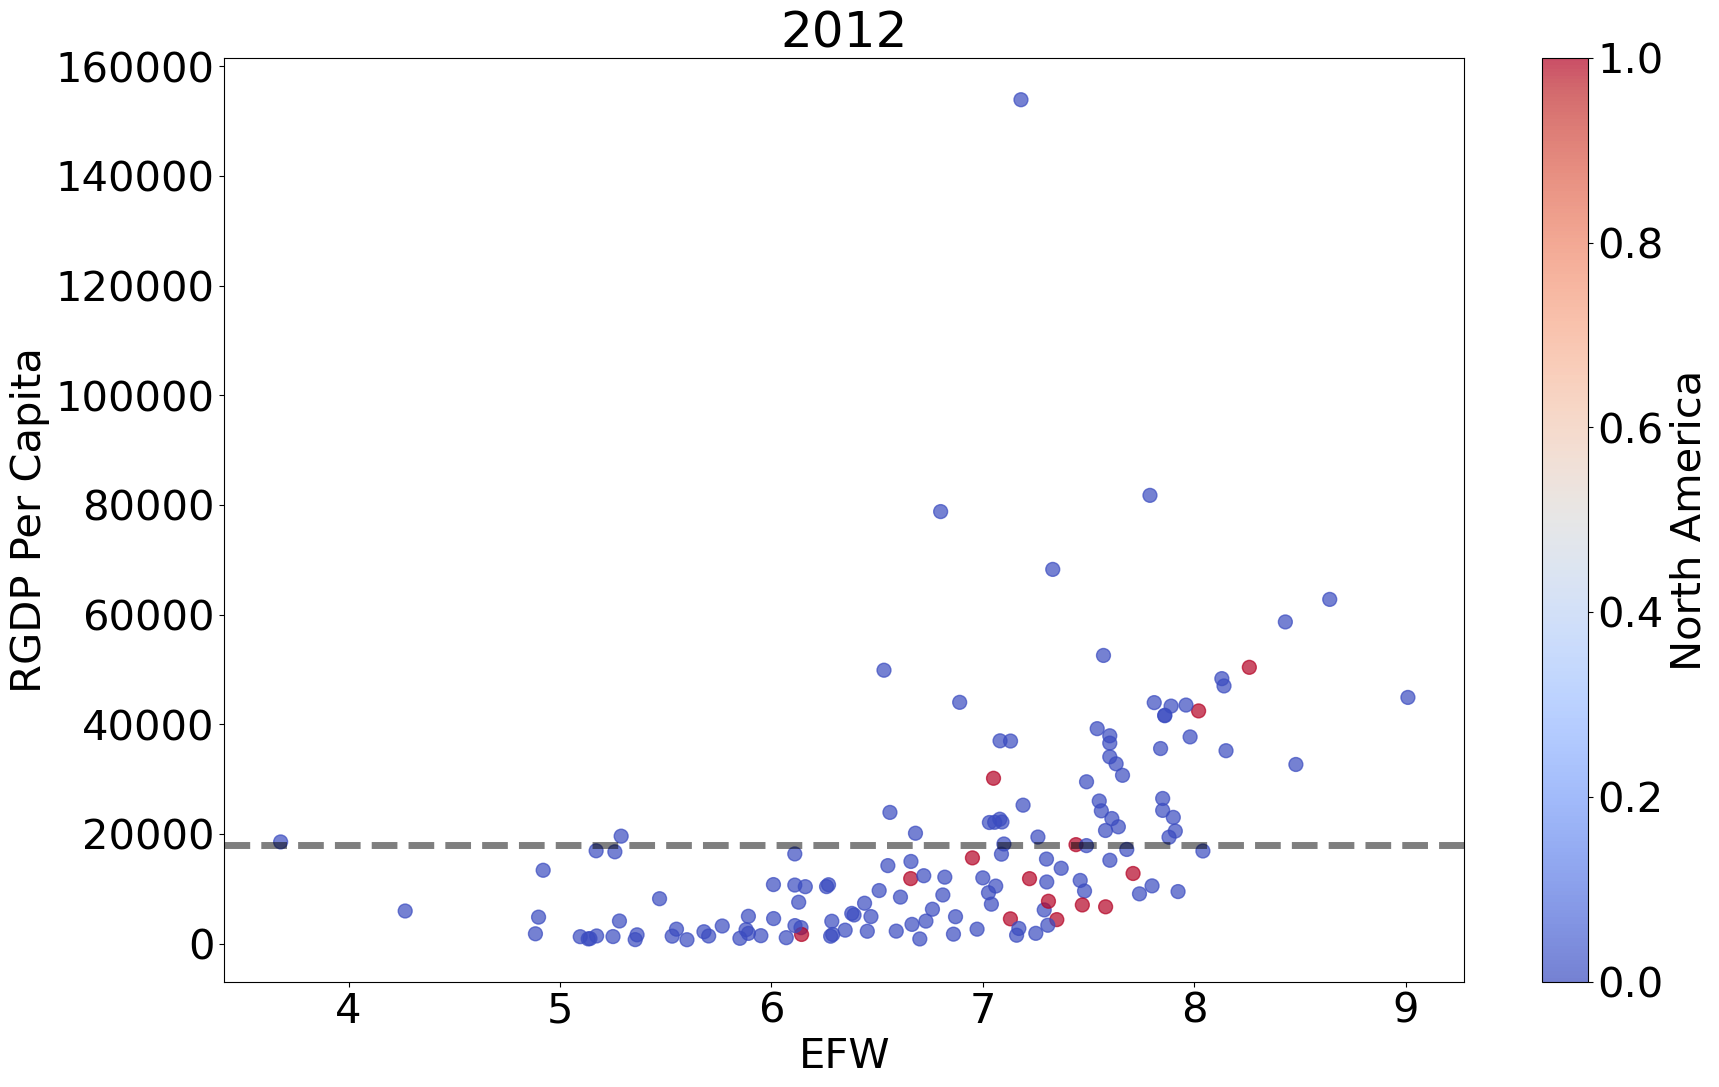

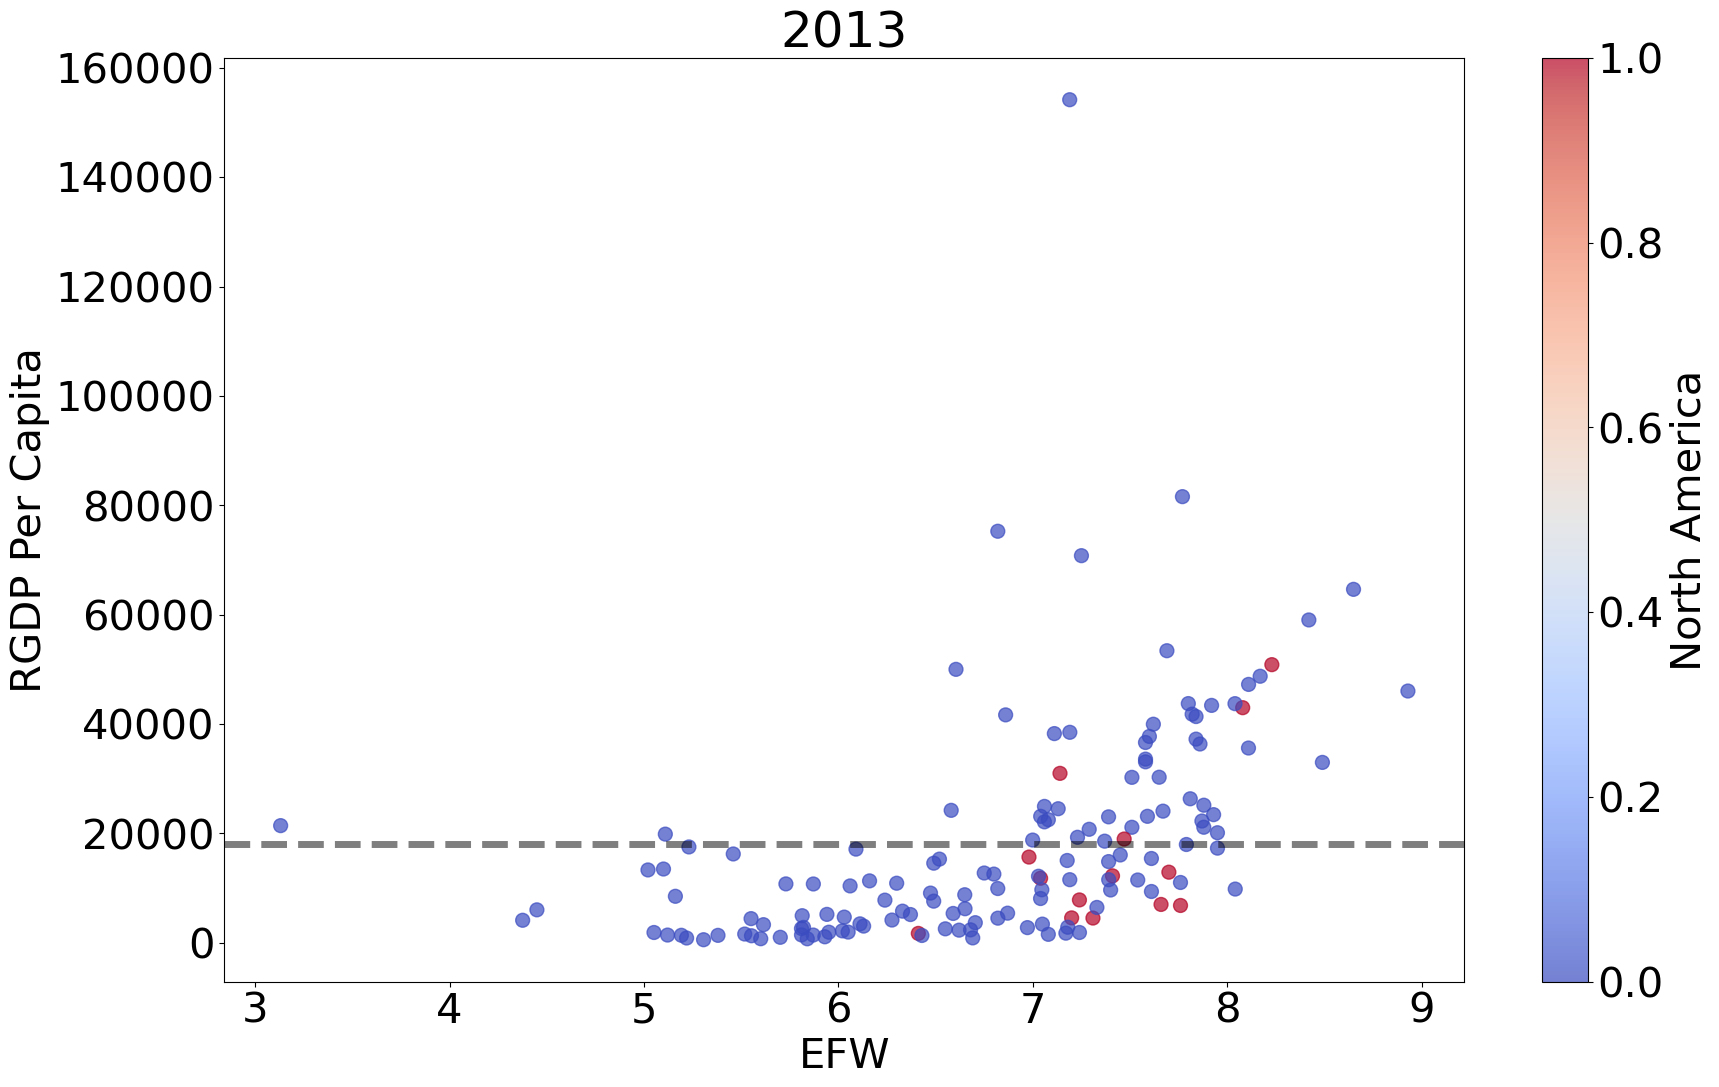

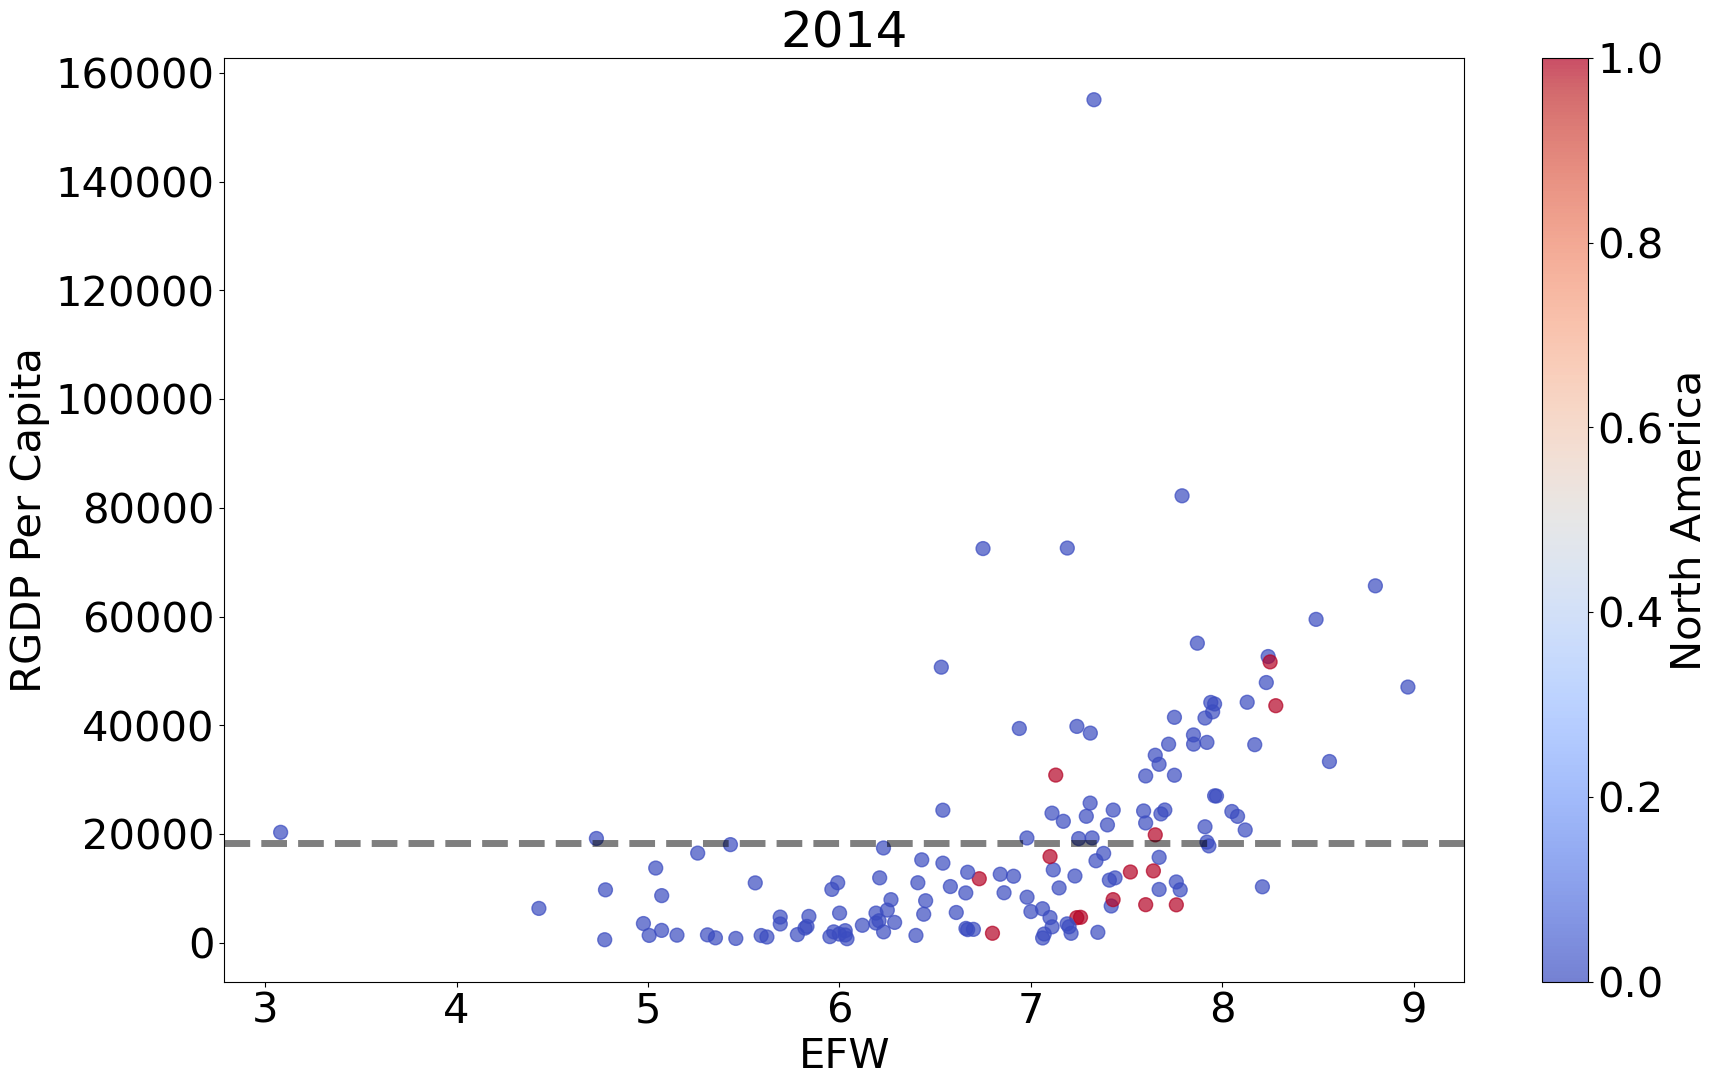

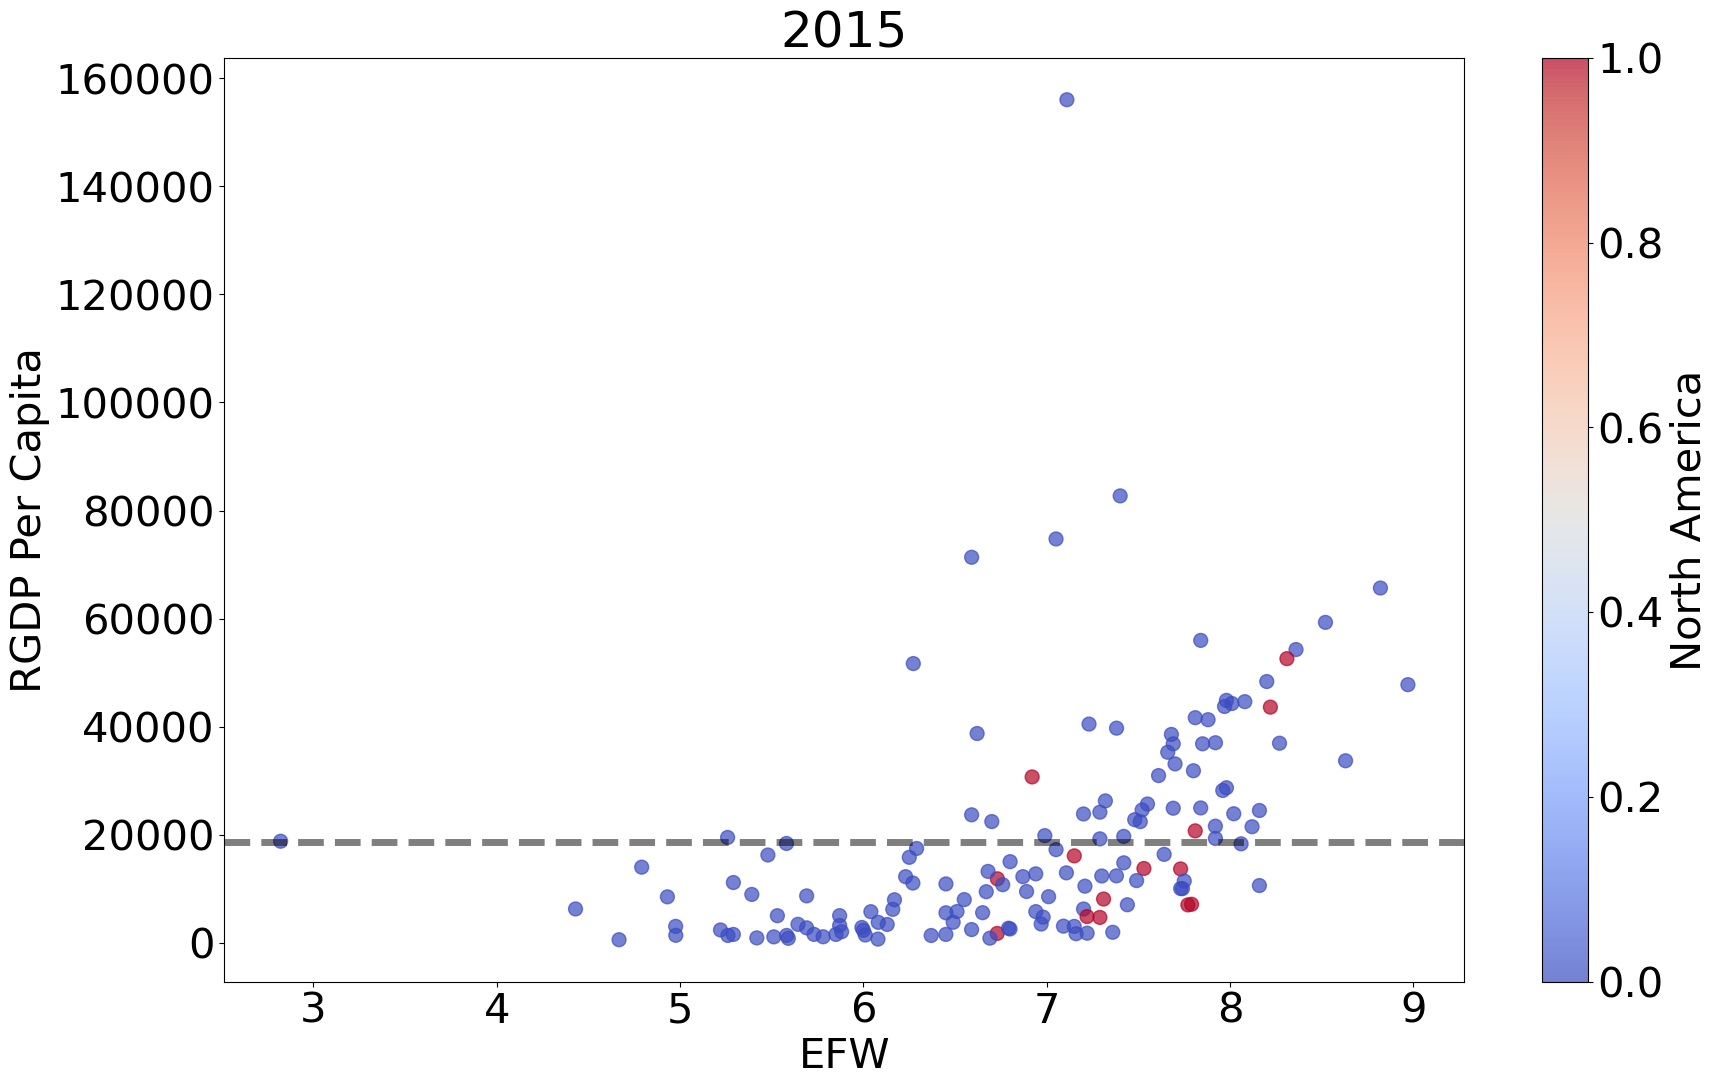

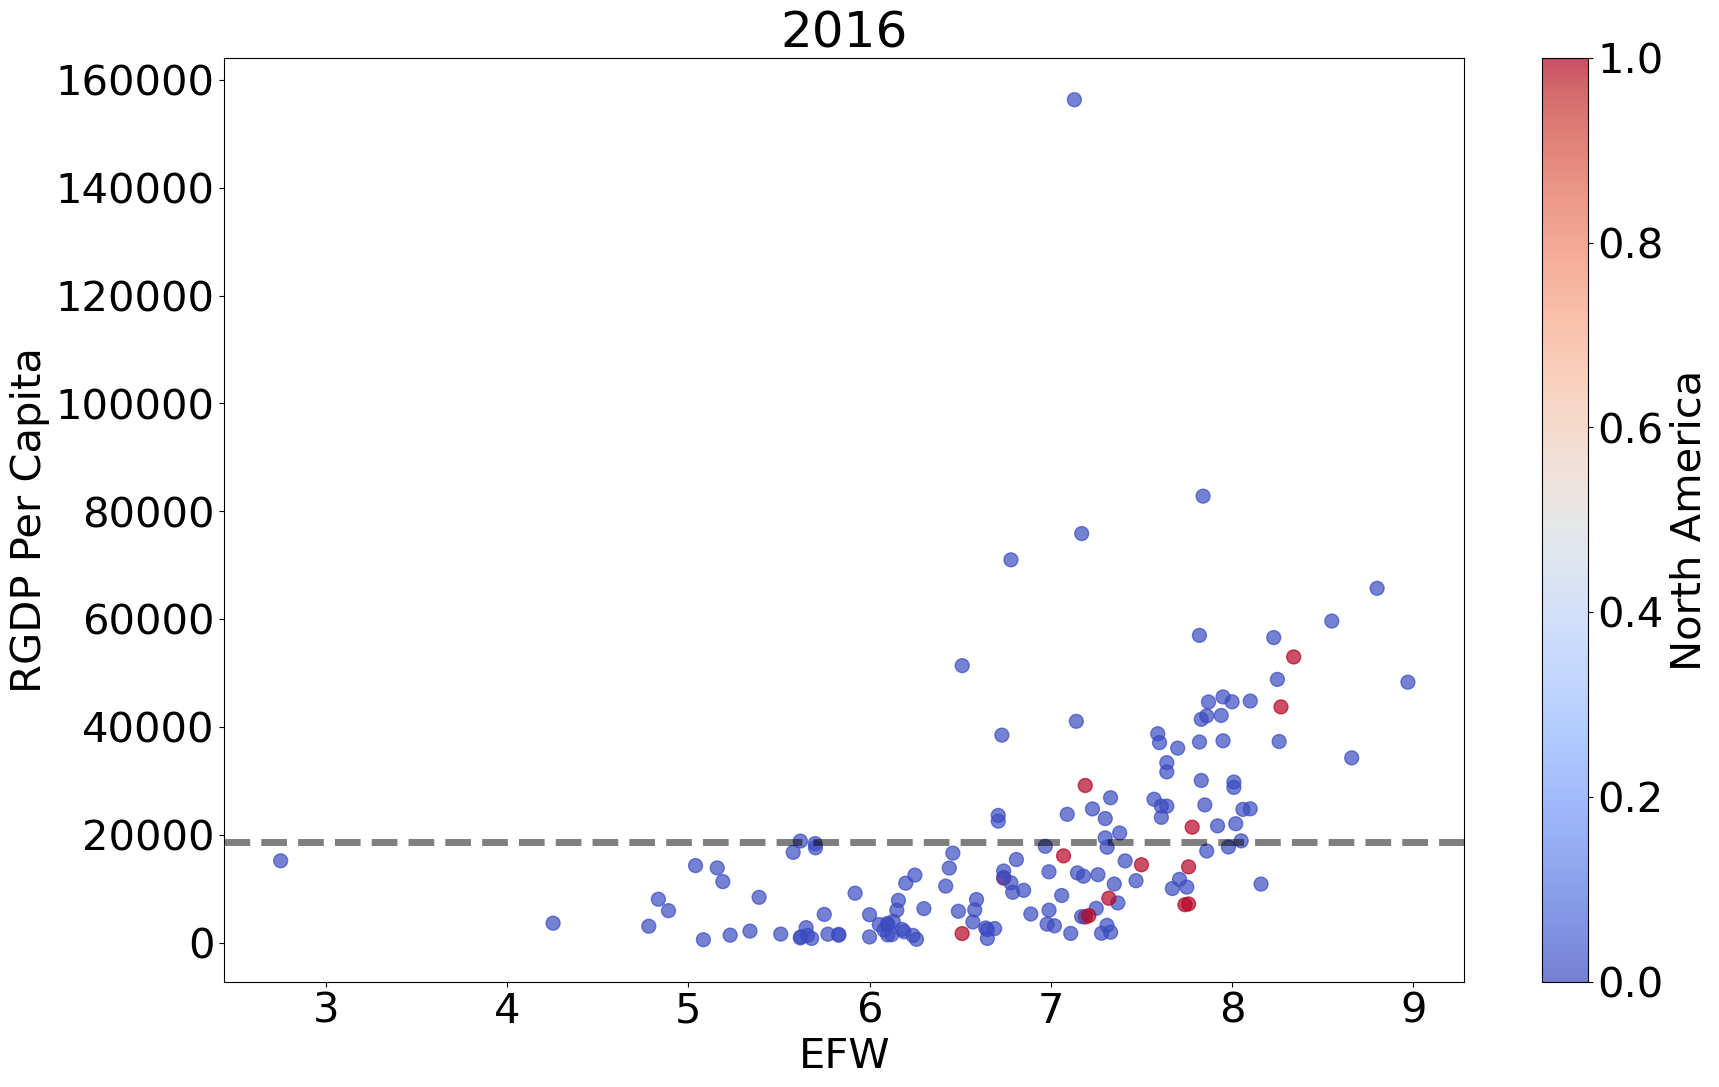

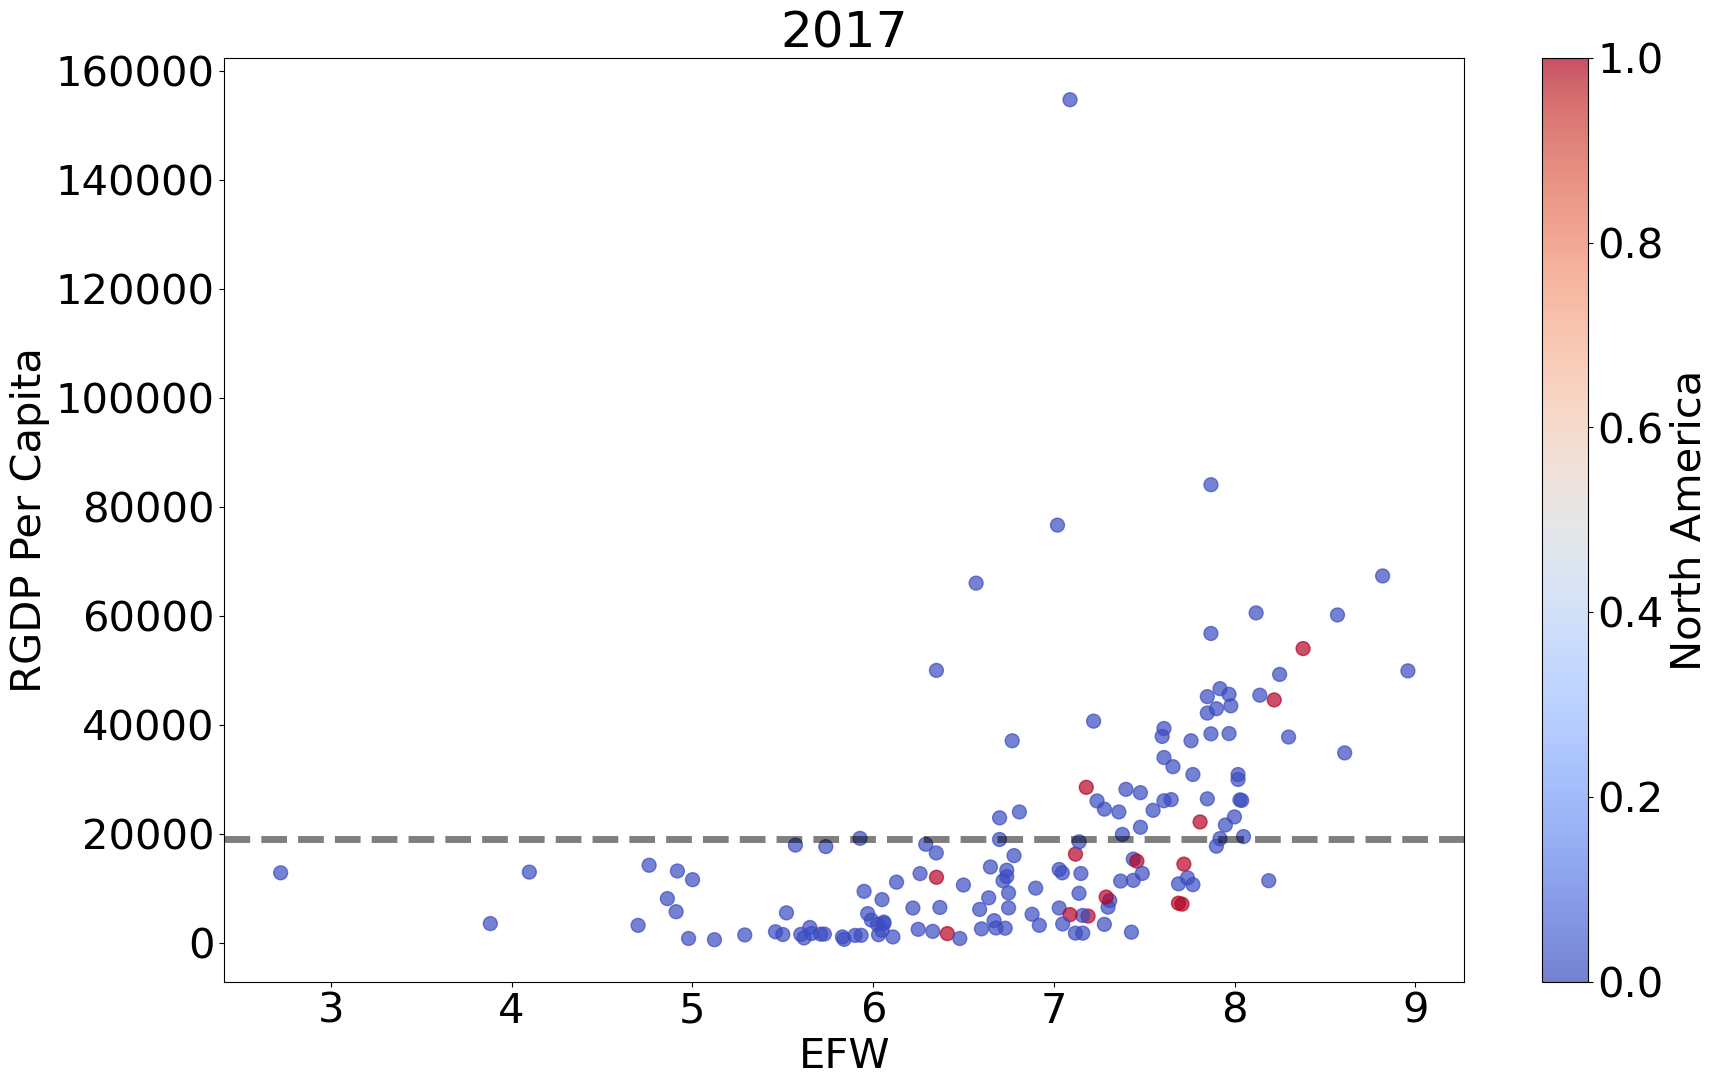

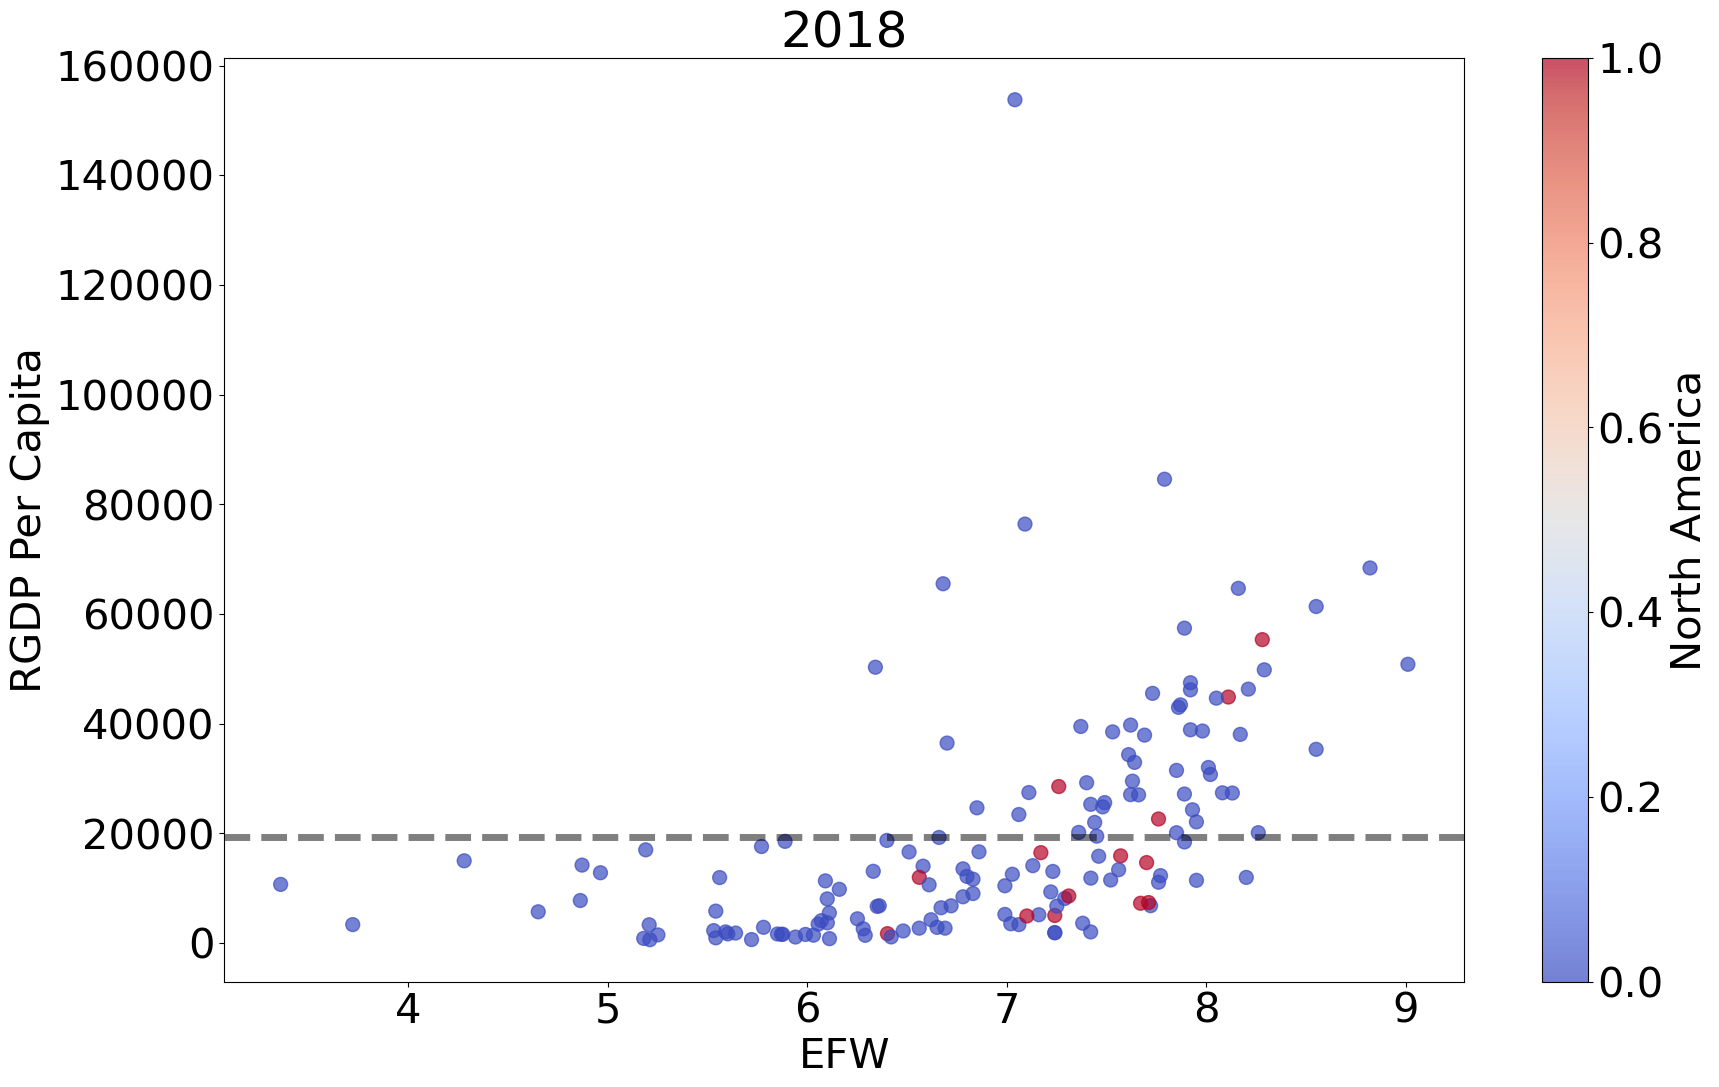

In [7]:
# not logged difference data for RGDP Per Capita since I am using Project 10.
# 


plt.rcParams.update({"font.size":30})
years = data.dropna(subset = ["RGDP Per Capita"]).index.get_level_values("Year").unique()
for year in years:

    plot_data = data[data.index.get_level_values("Year") == year]
    fig, ax = plt.subplots(figsize = (20,12))
    plot_data.plot.scatter(x = "EFW",
                          y = "RGDP Per Capita",
                          c = "North America",
                          cmap = "coolwarm", 
                           s = 100,
                          alpha = .7,
                          ax = ax)

    ax.set_title(str(year)[:4])
    # mean RGDP Per Capita shown below with line
    ax.axhline(plot_data["RGDP Per Capita"].mean(), ls = "--", color = "k", alpha = .5, linewidth = 5)

C:\Users\Bryce Grabanski\AppData\Local\Temp\ipykernel_13892\2441601793.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize = (20,12))


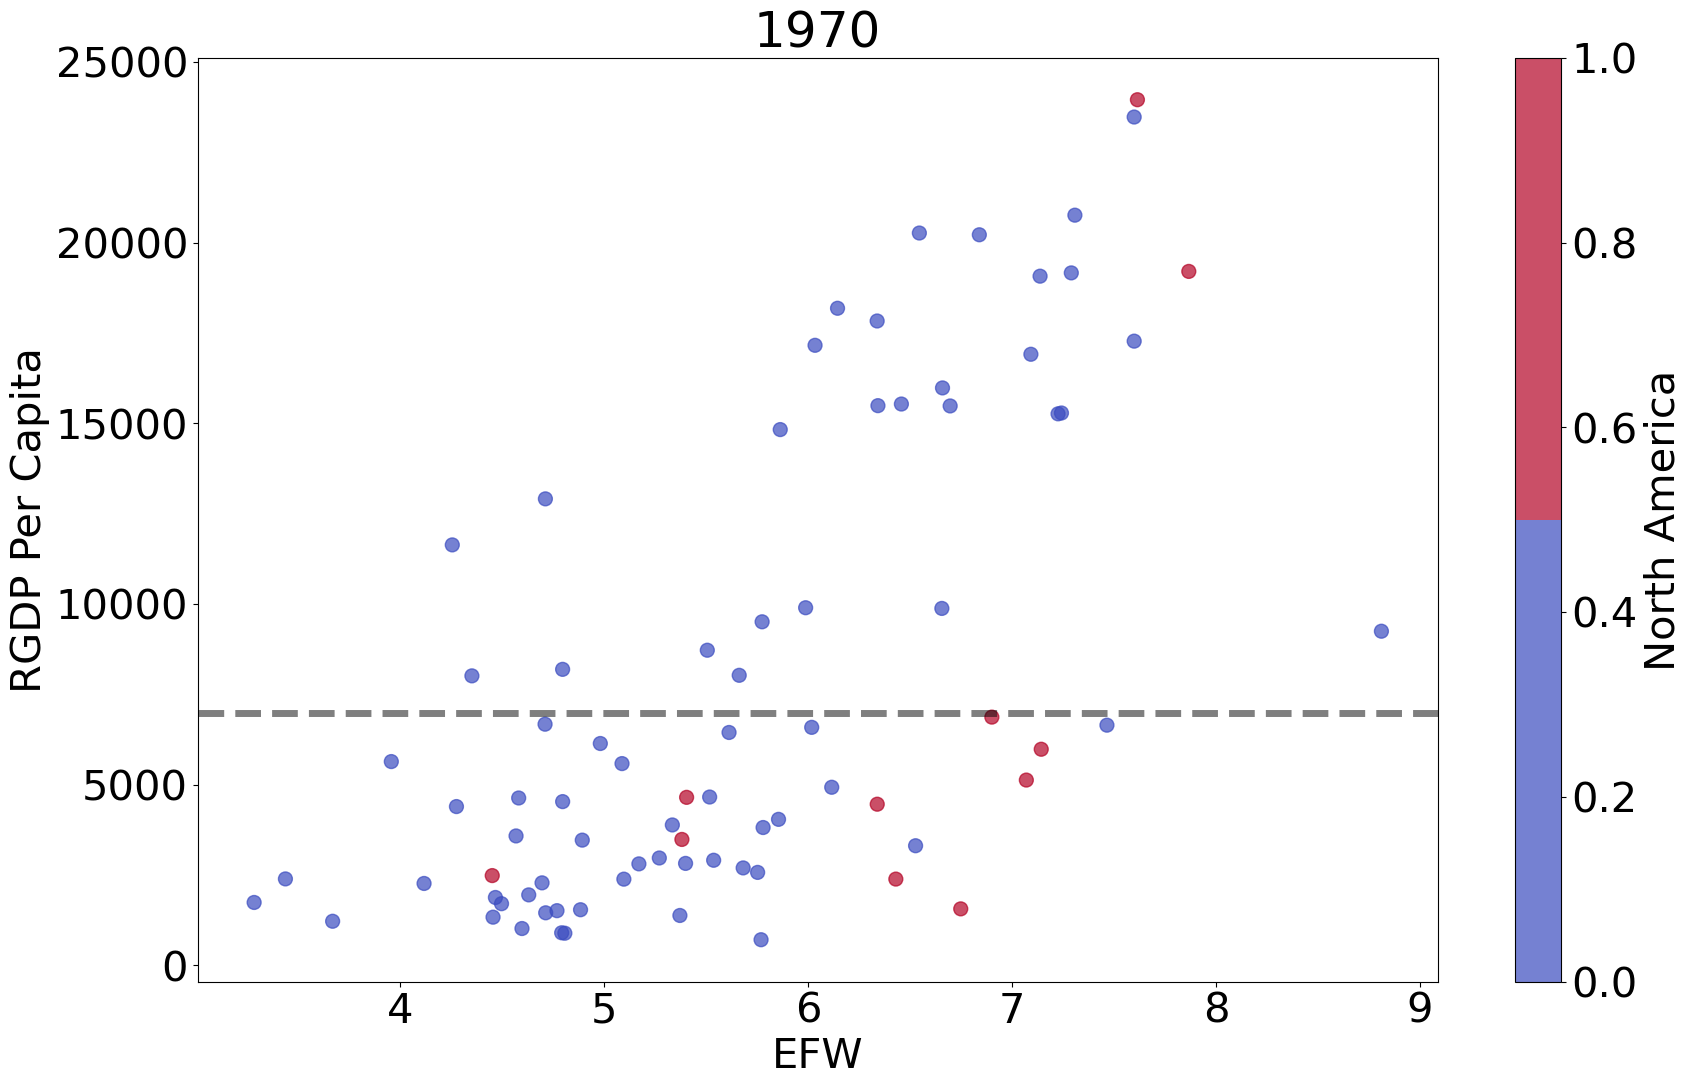

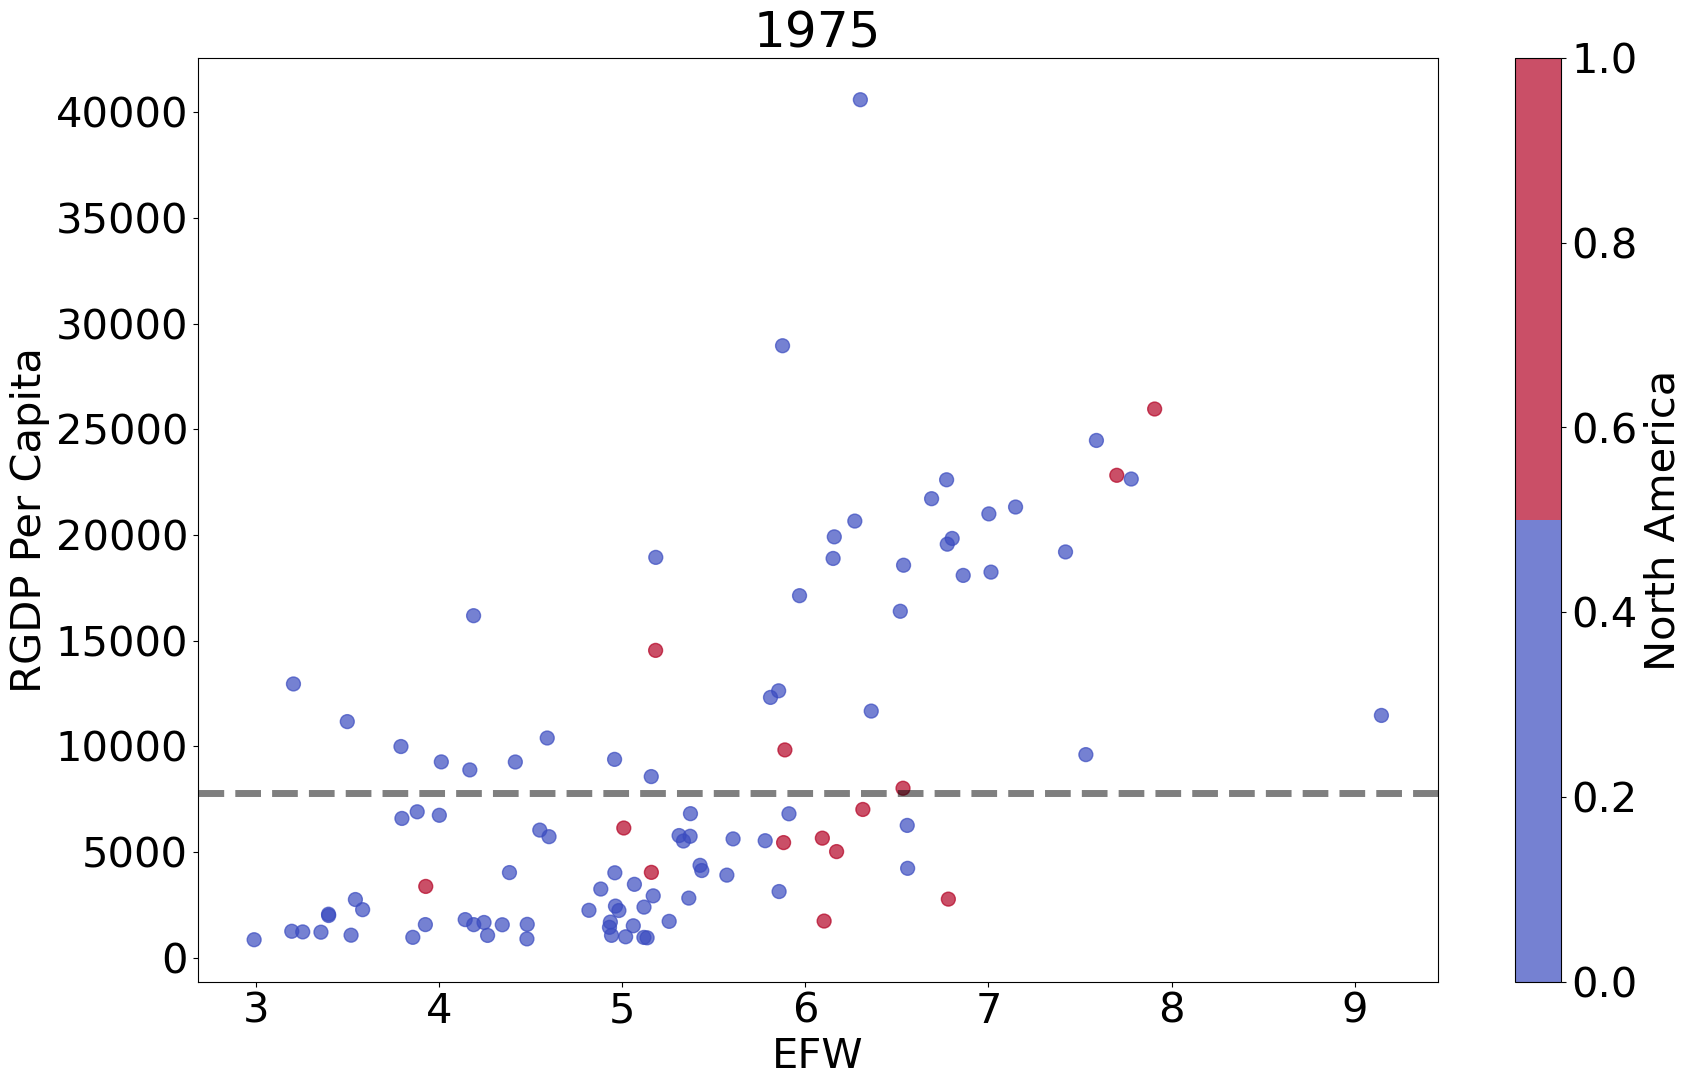

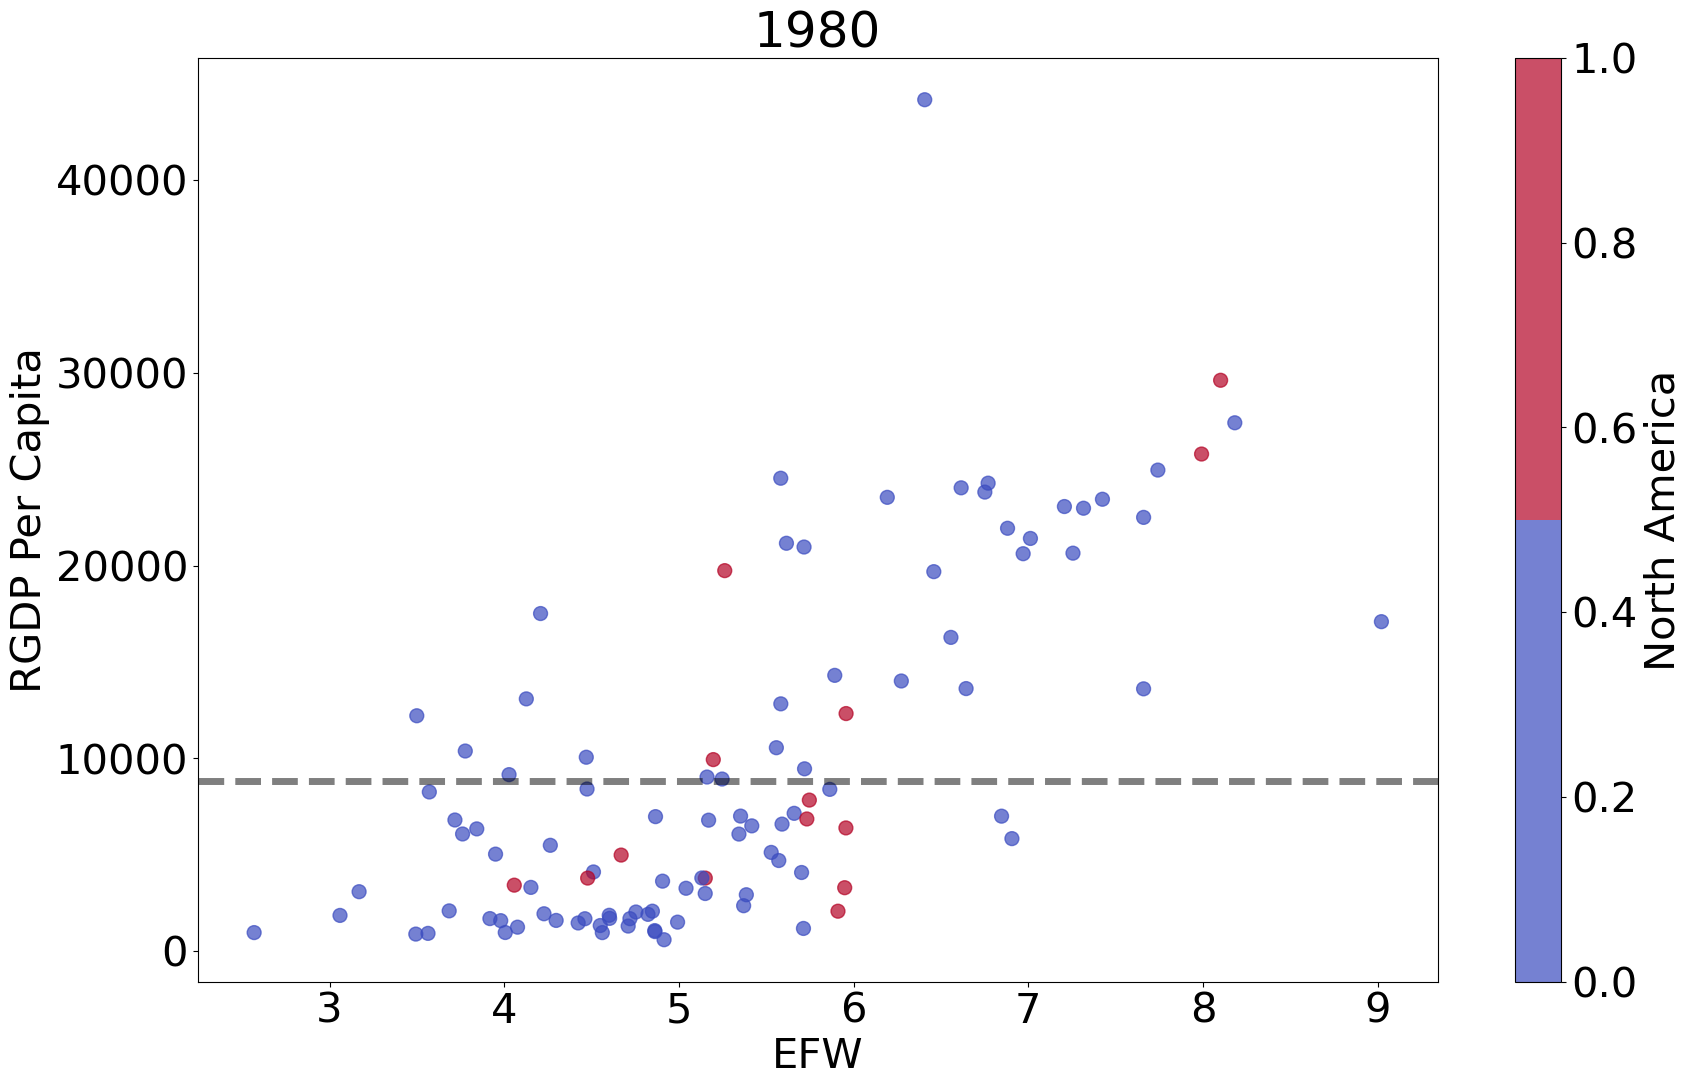

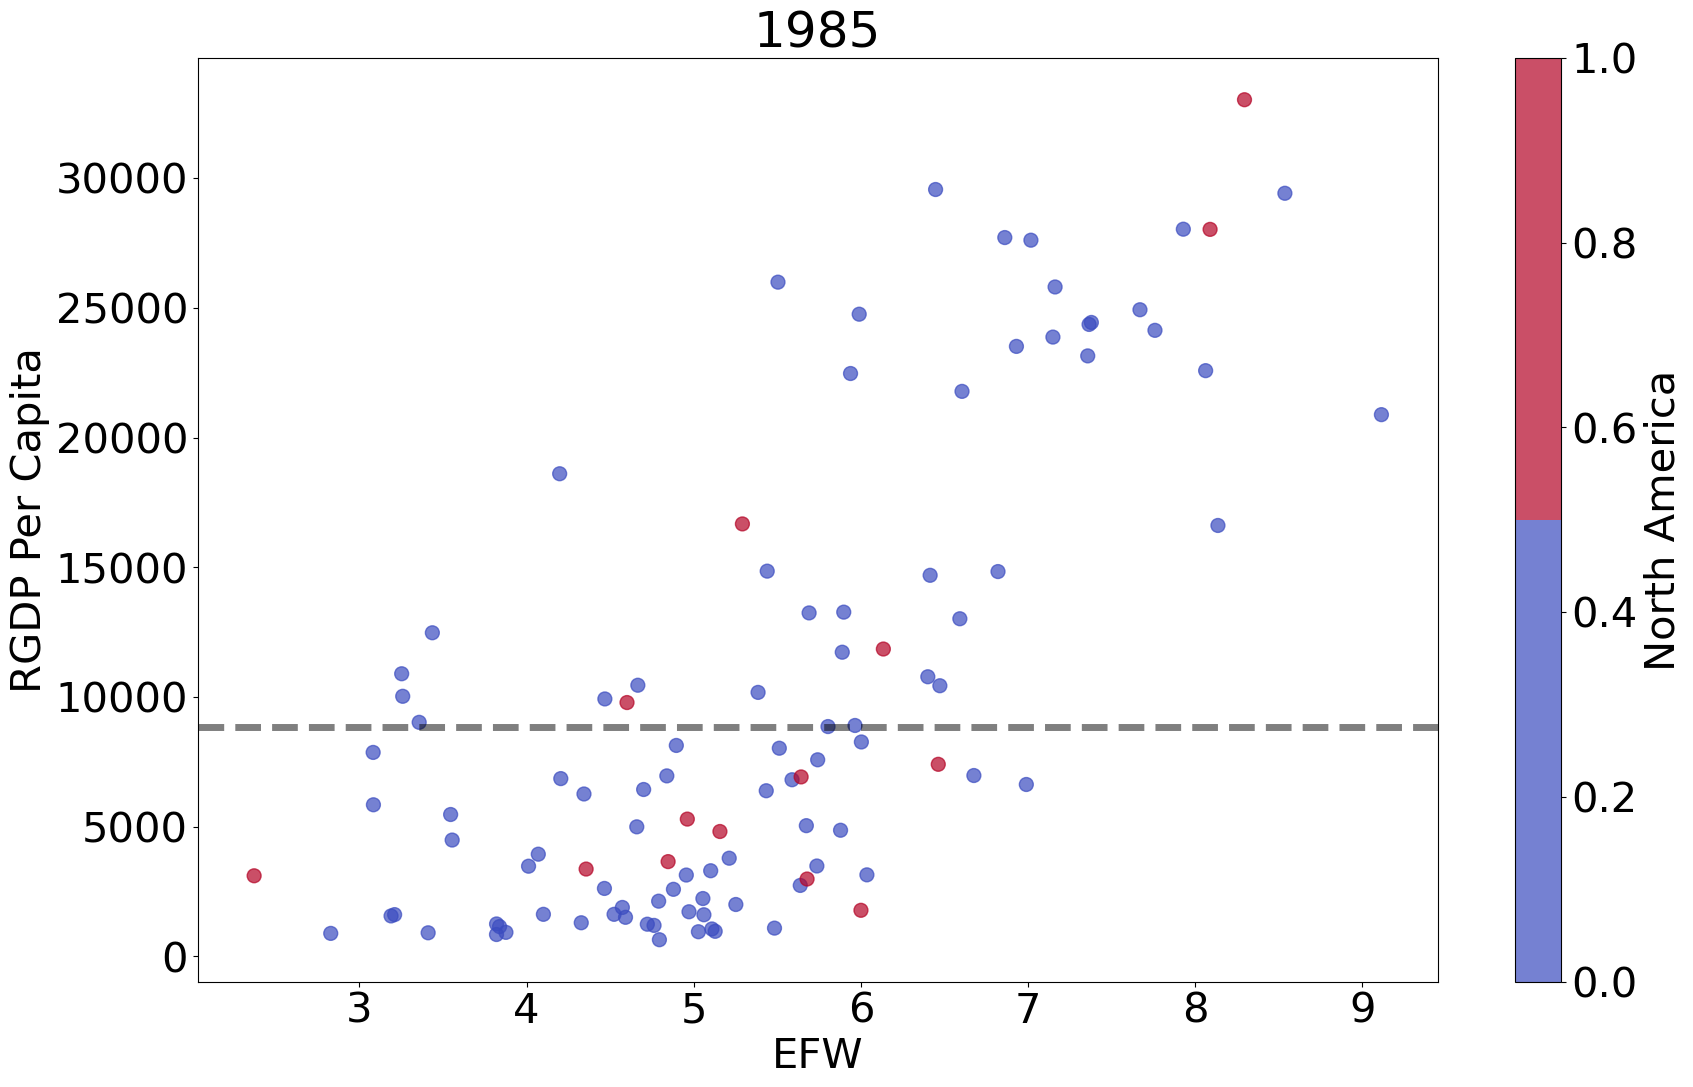

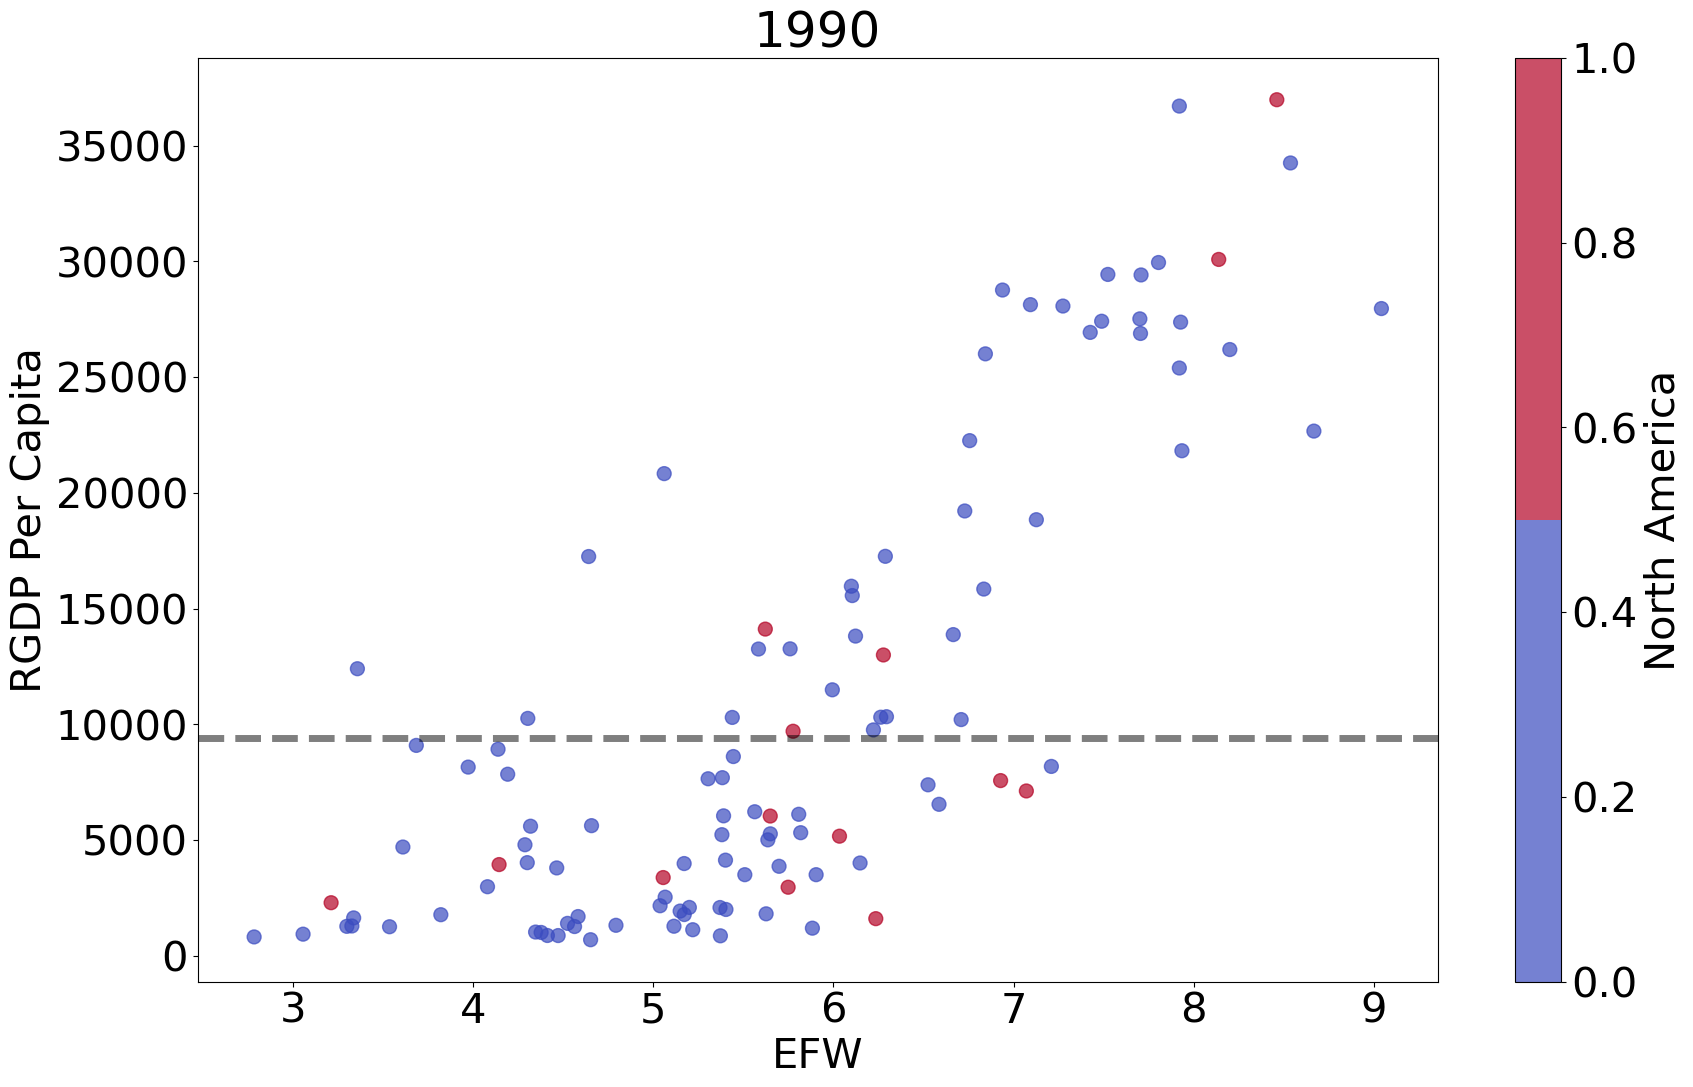

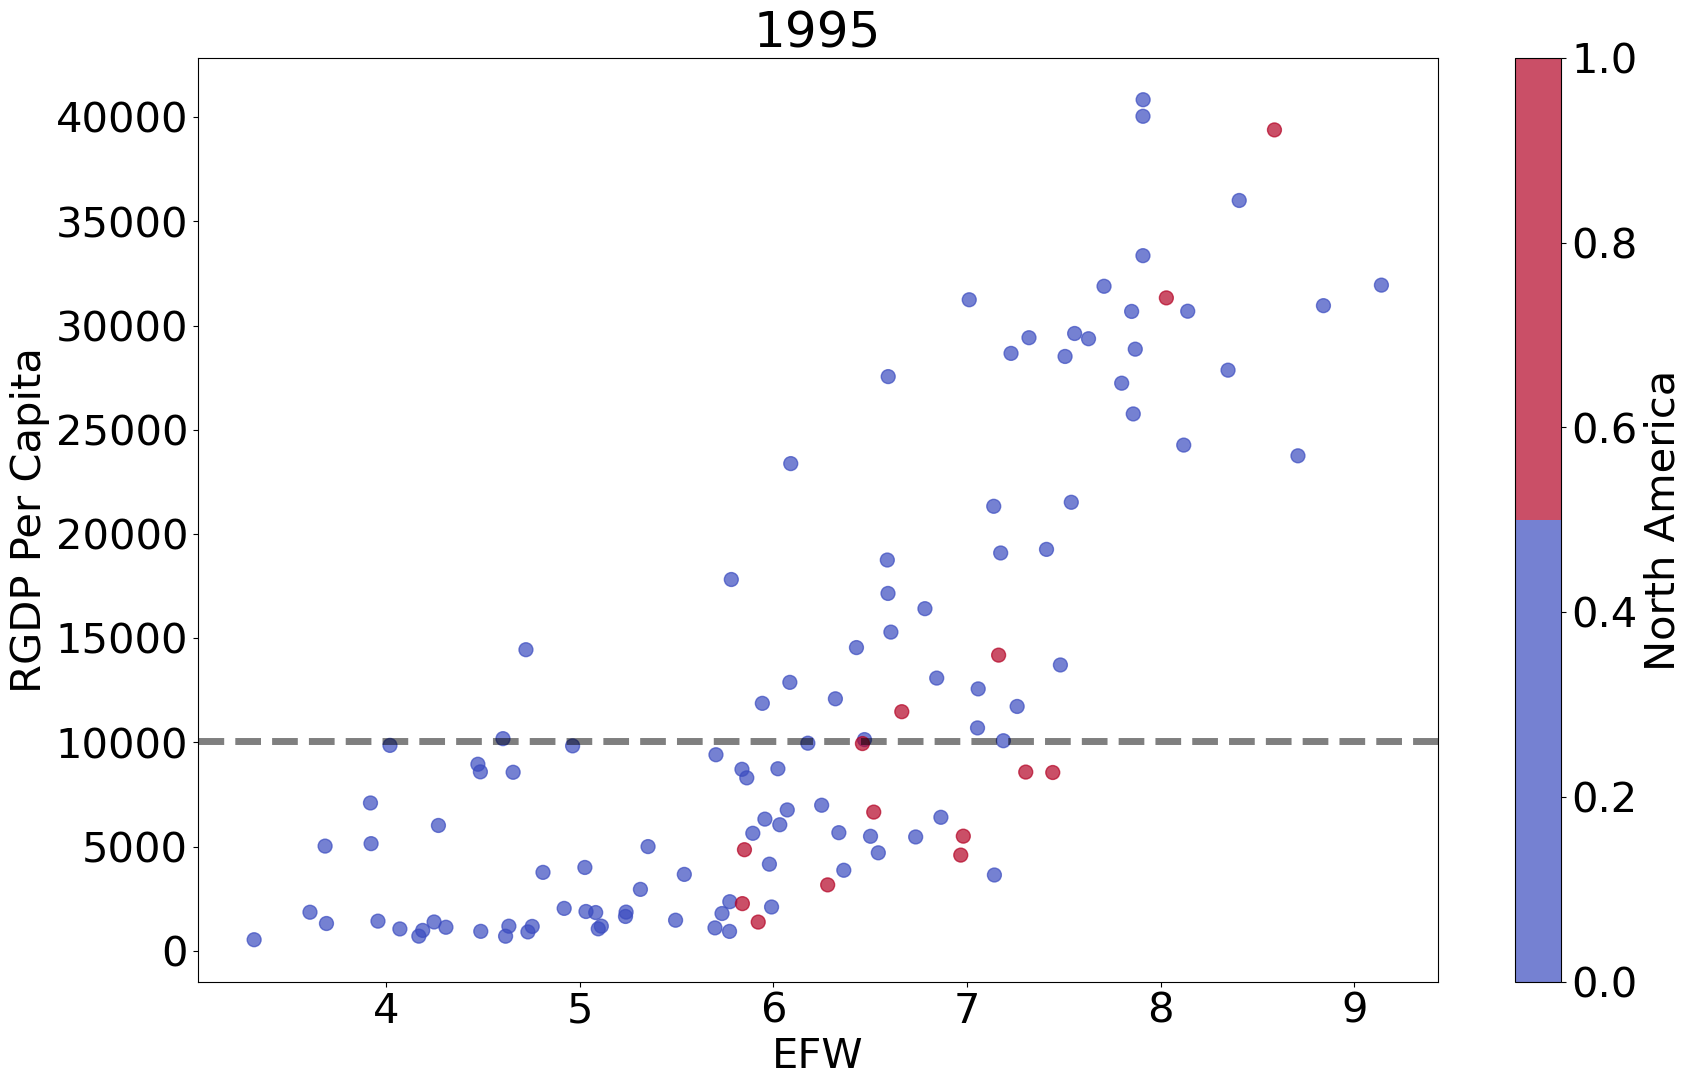

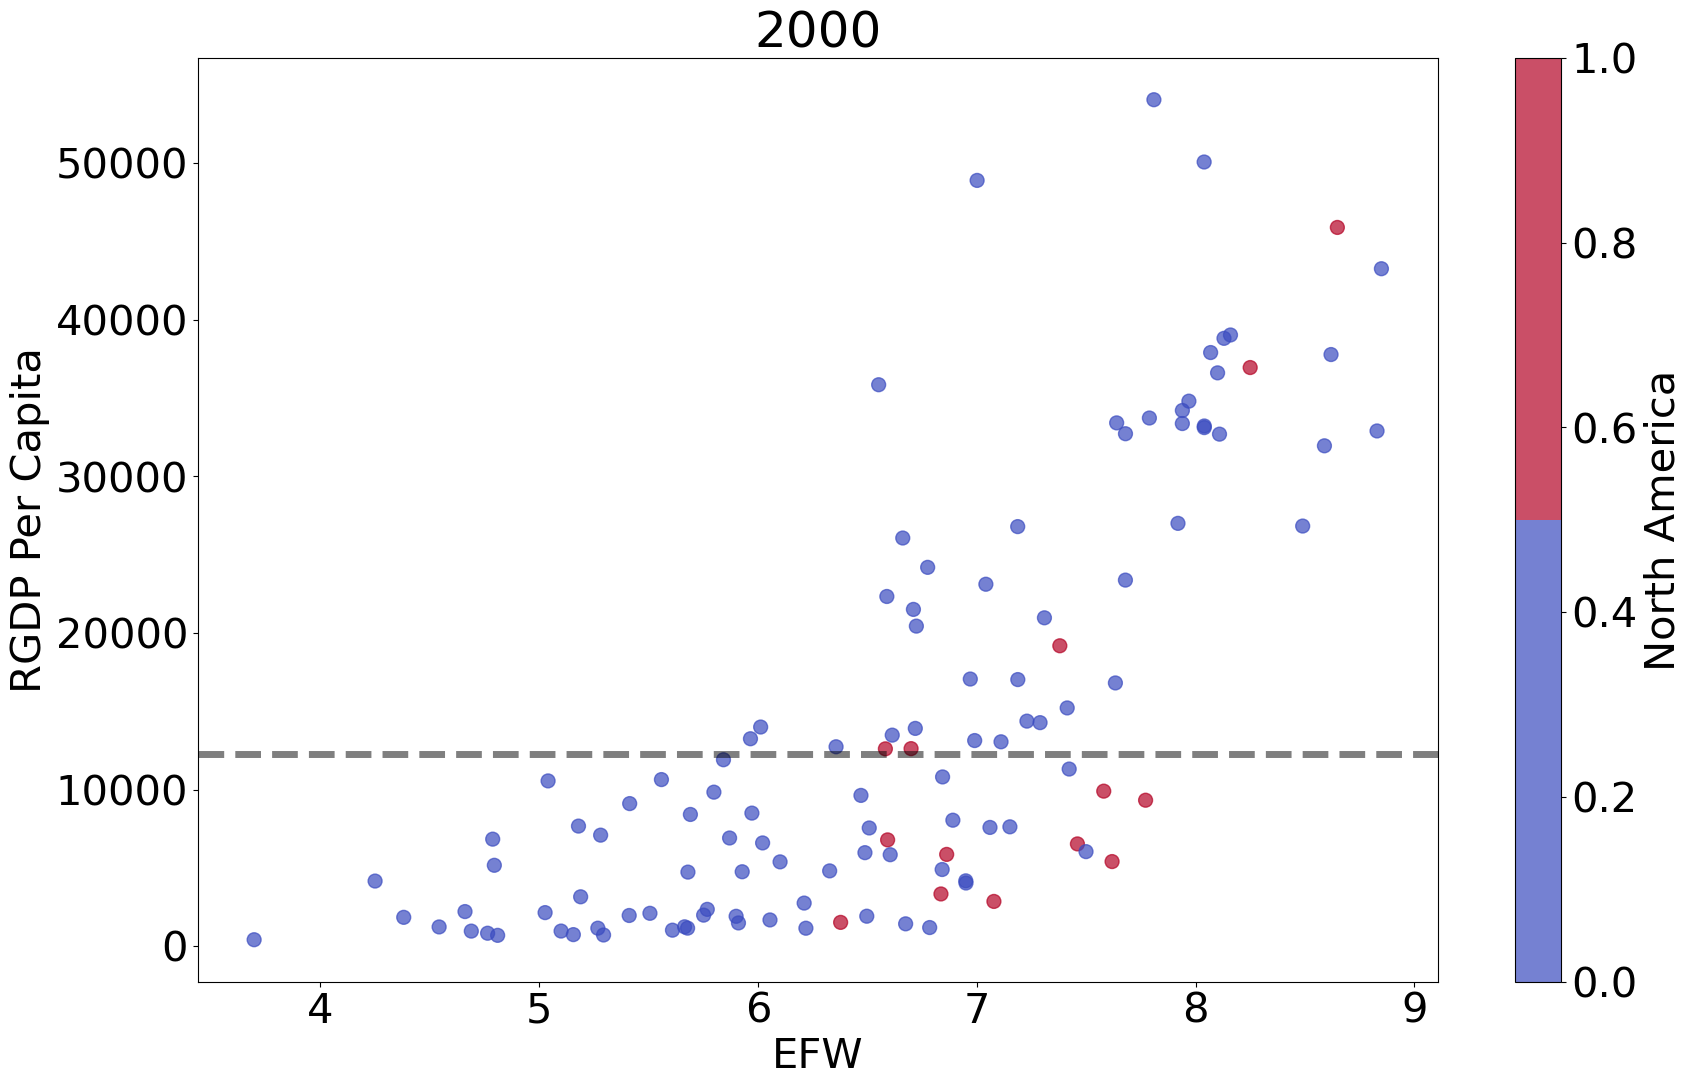

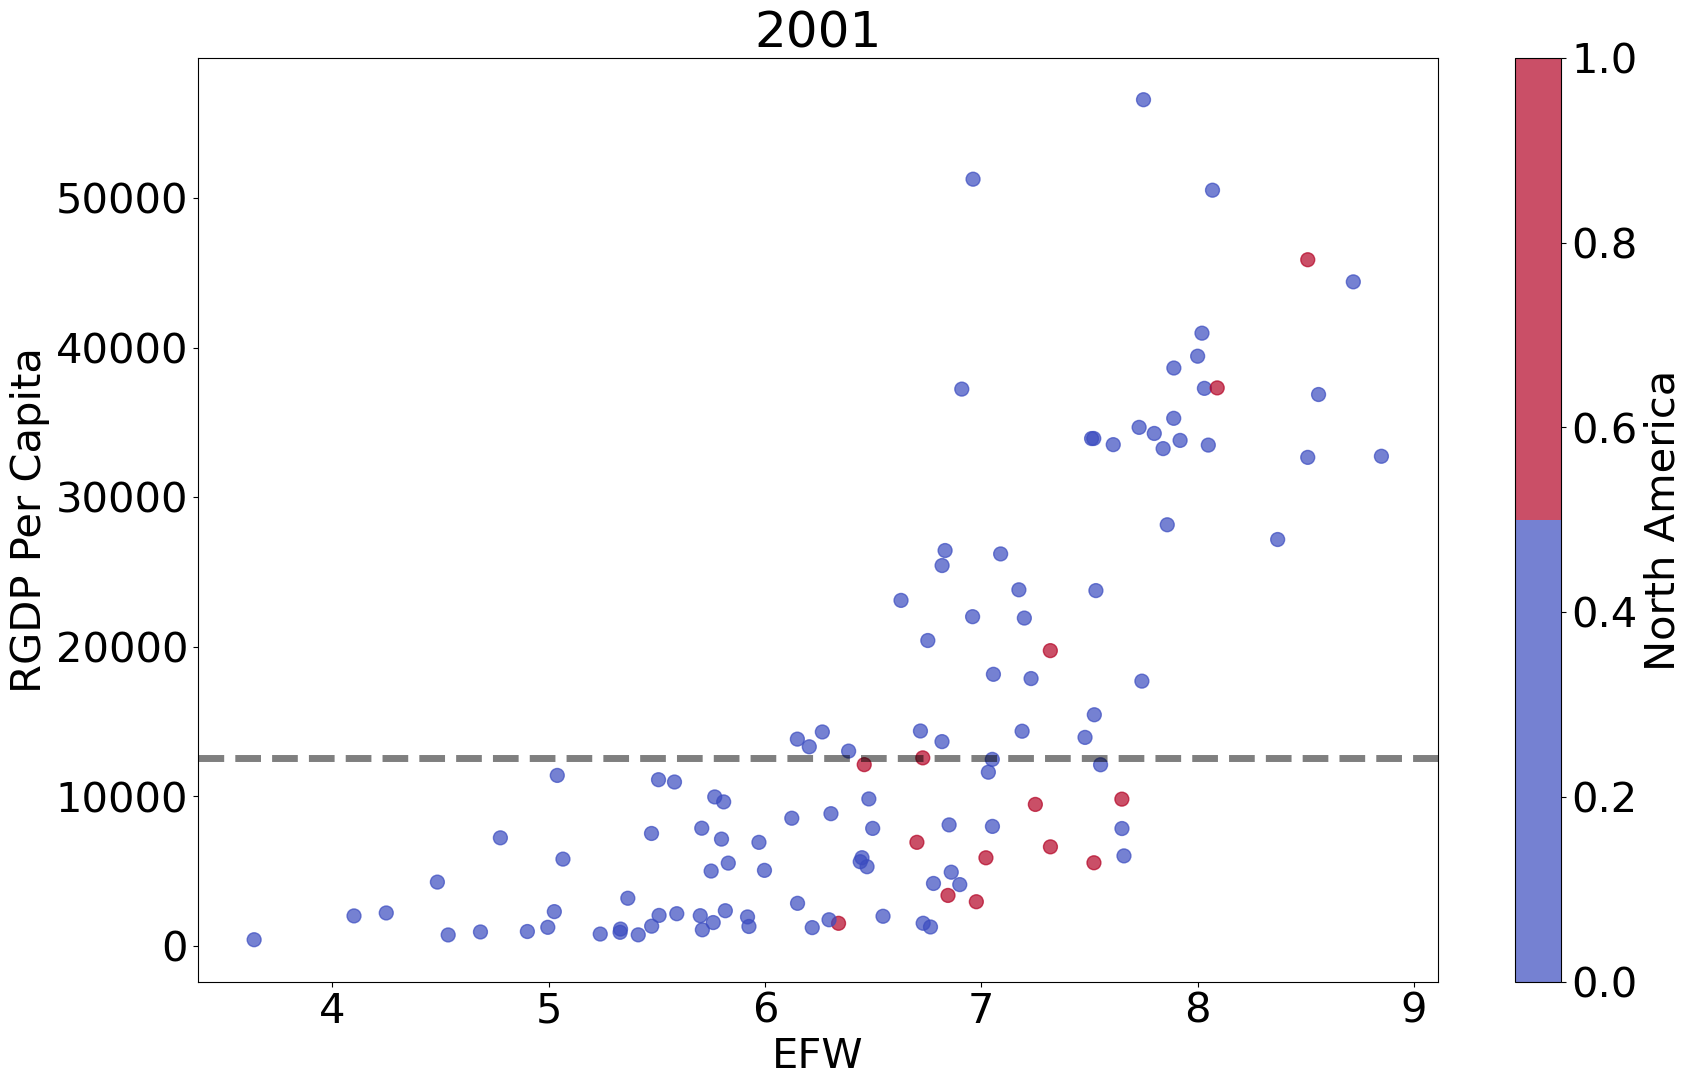

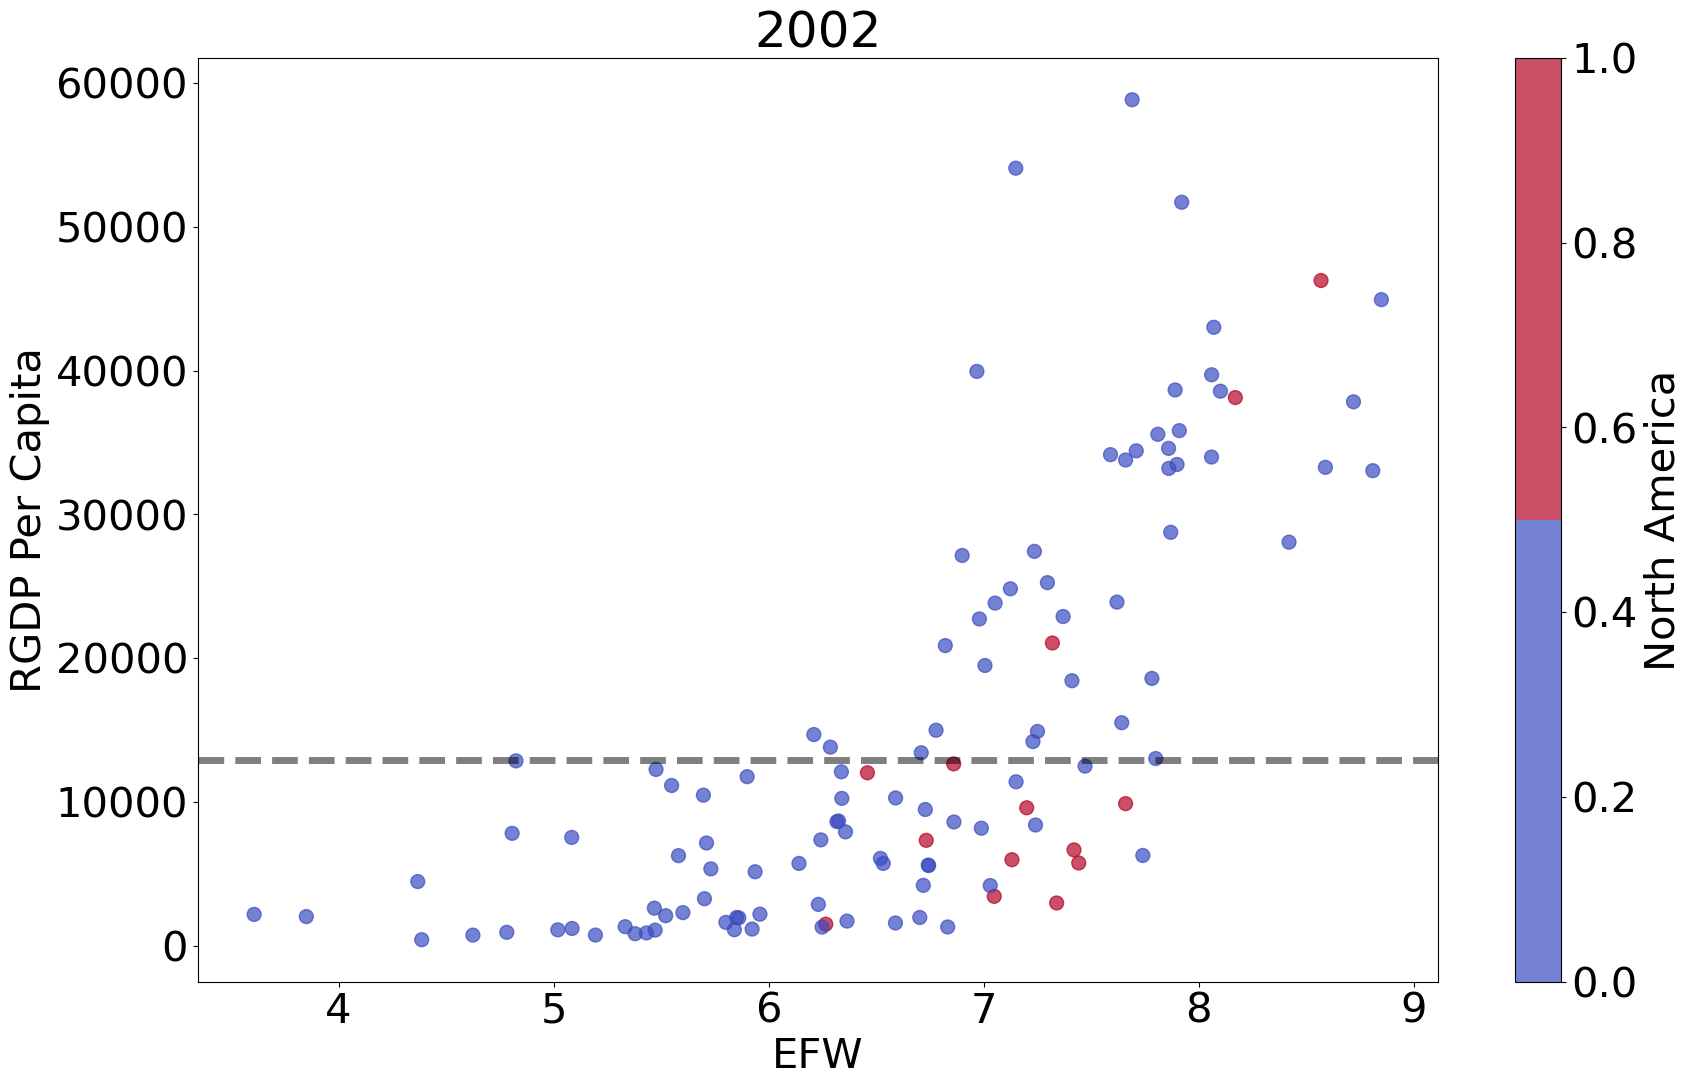

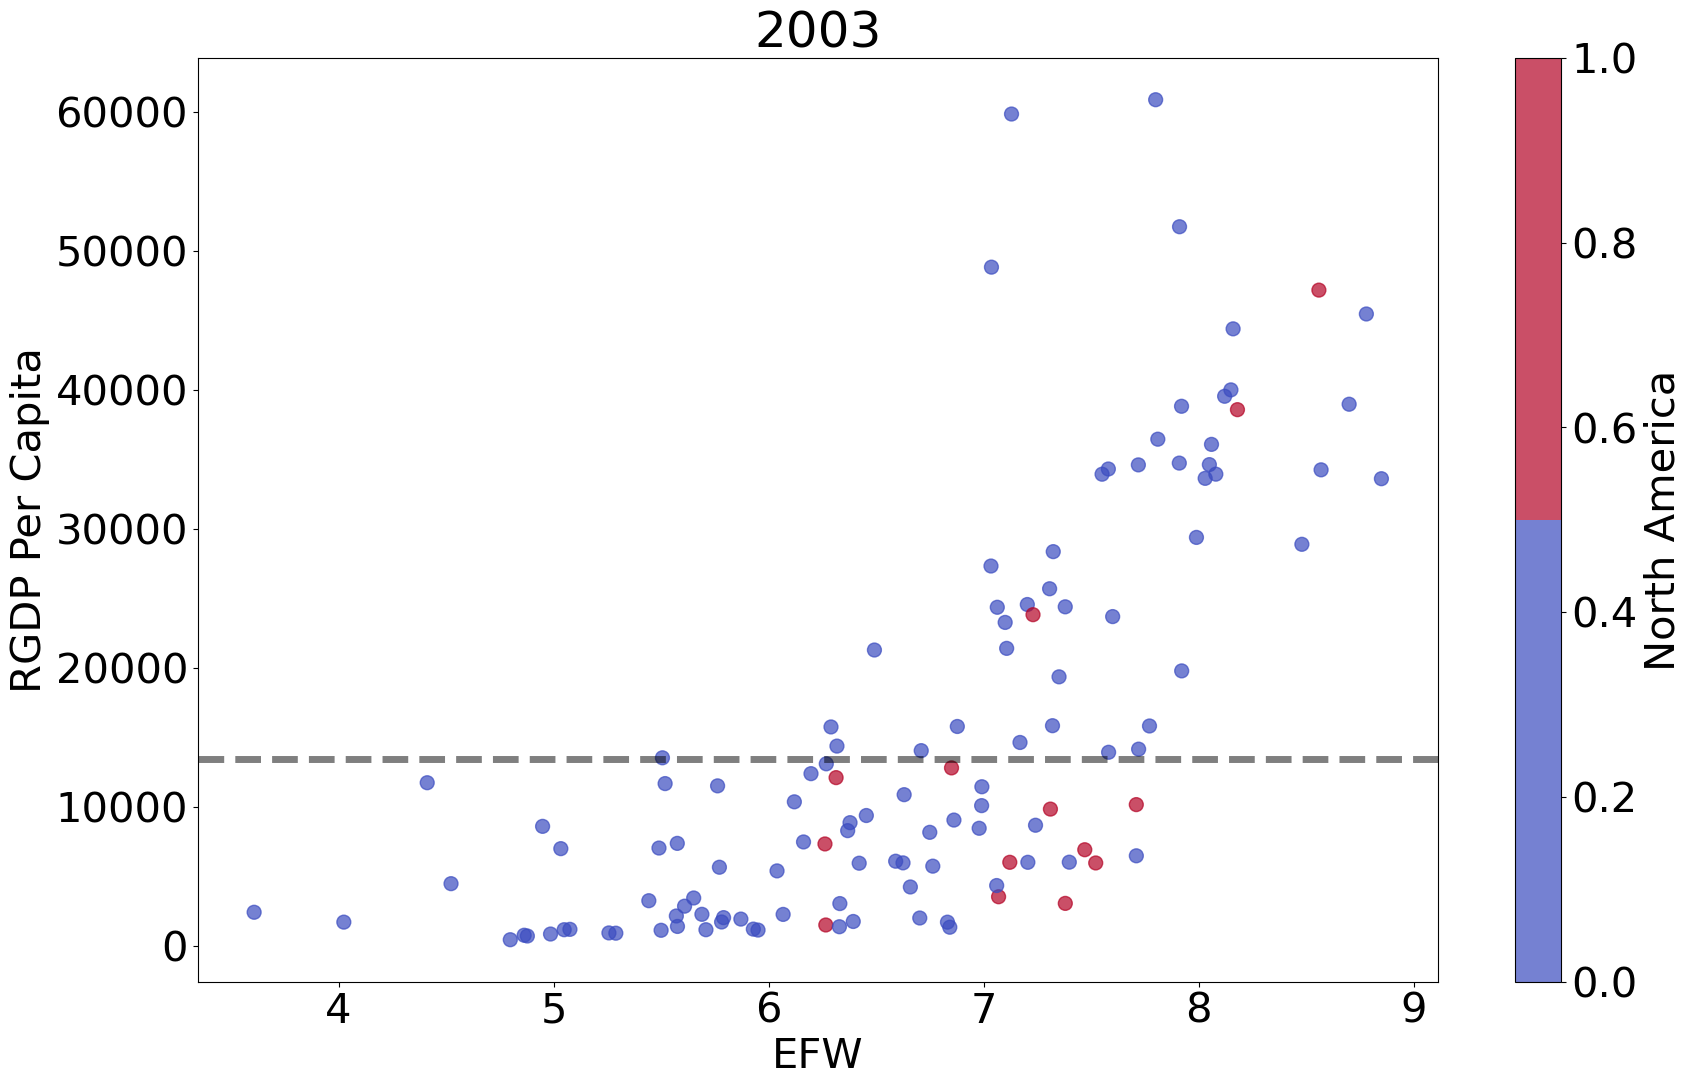

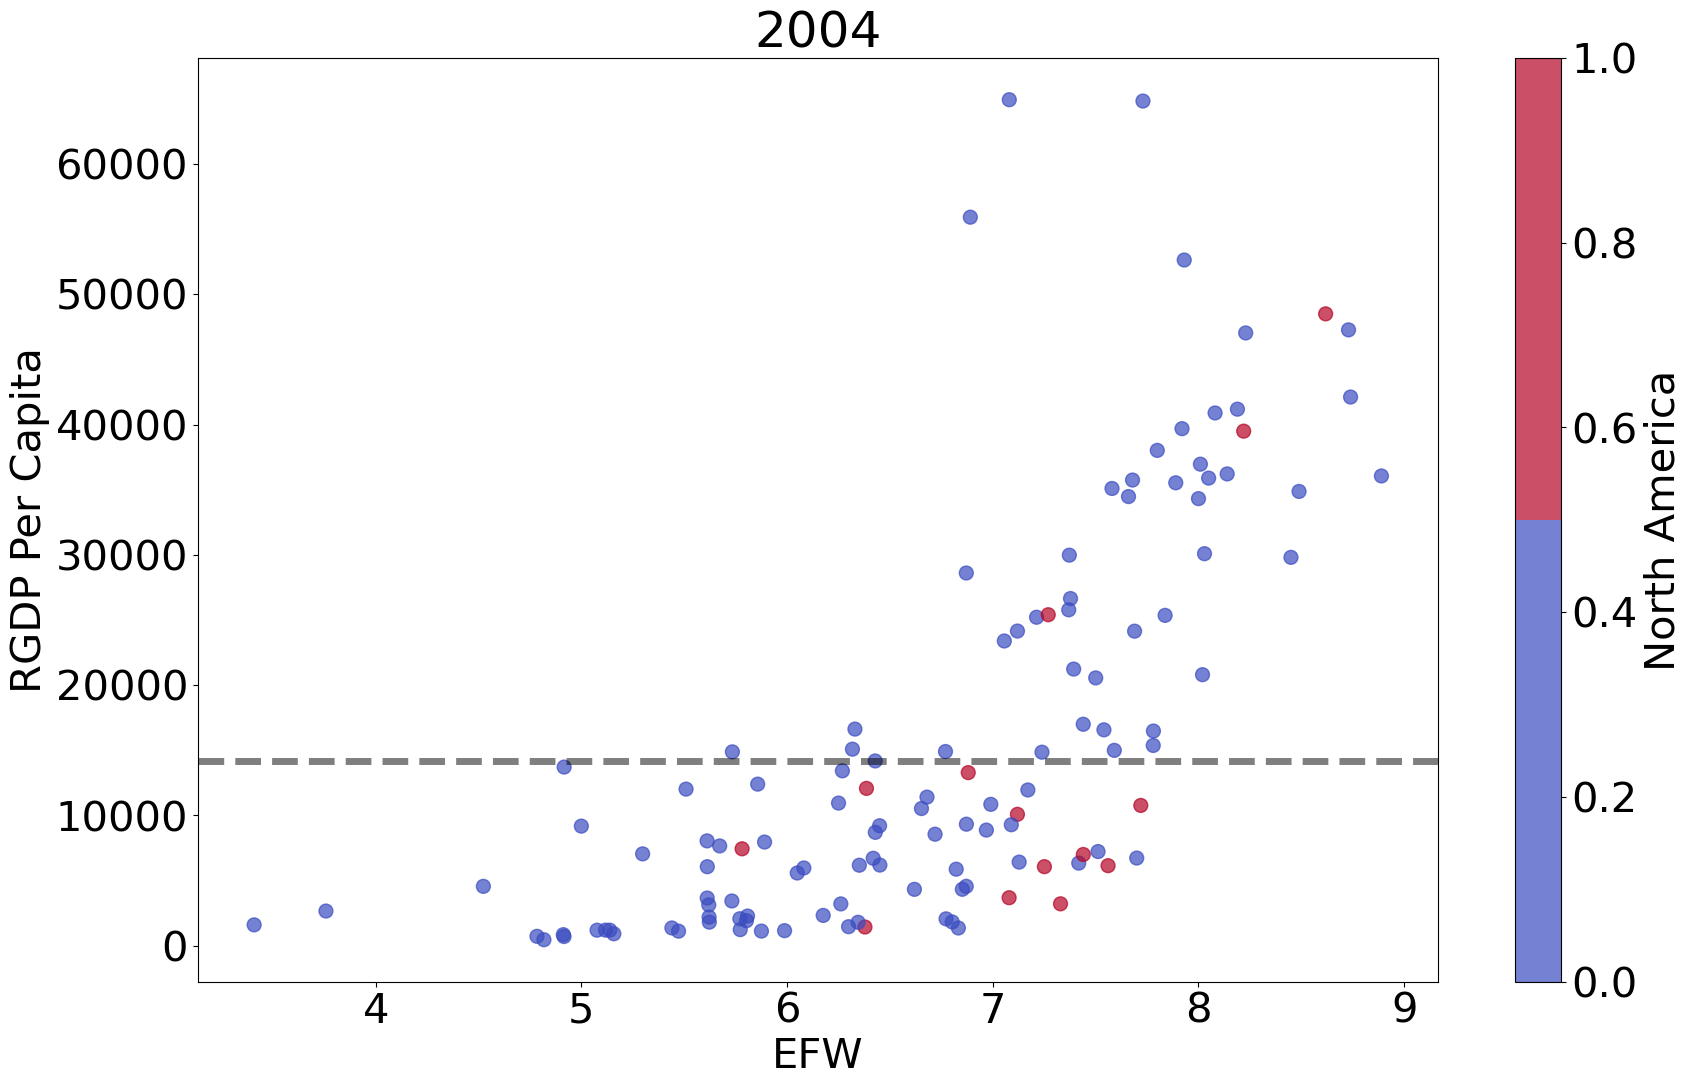

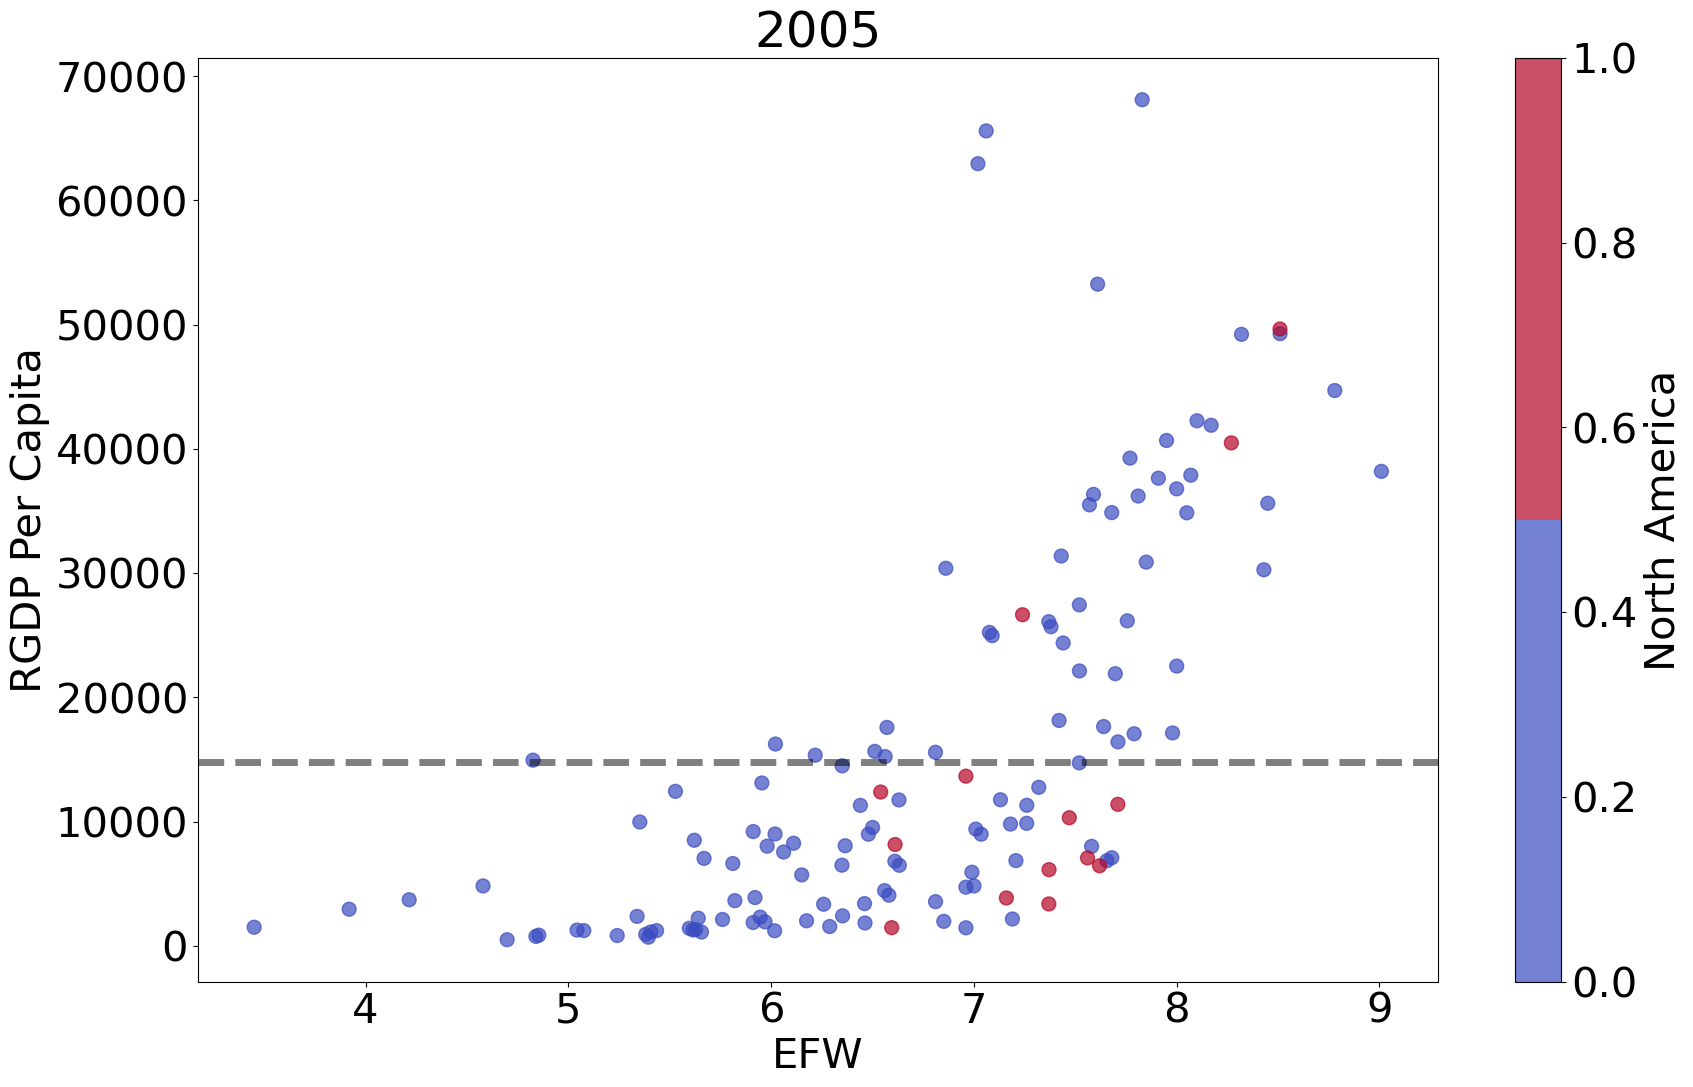

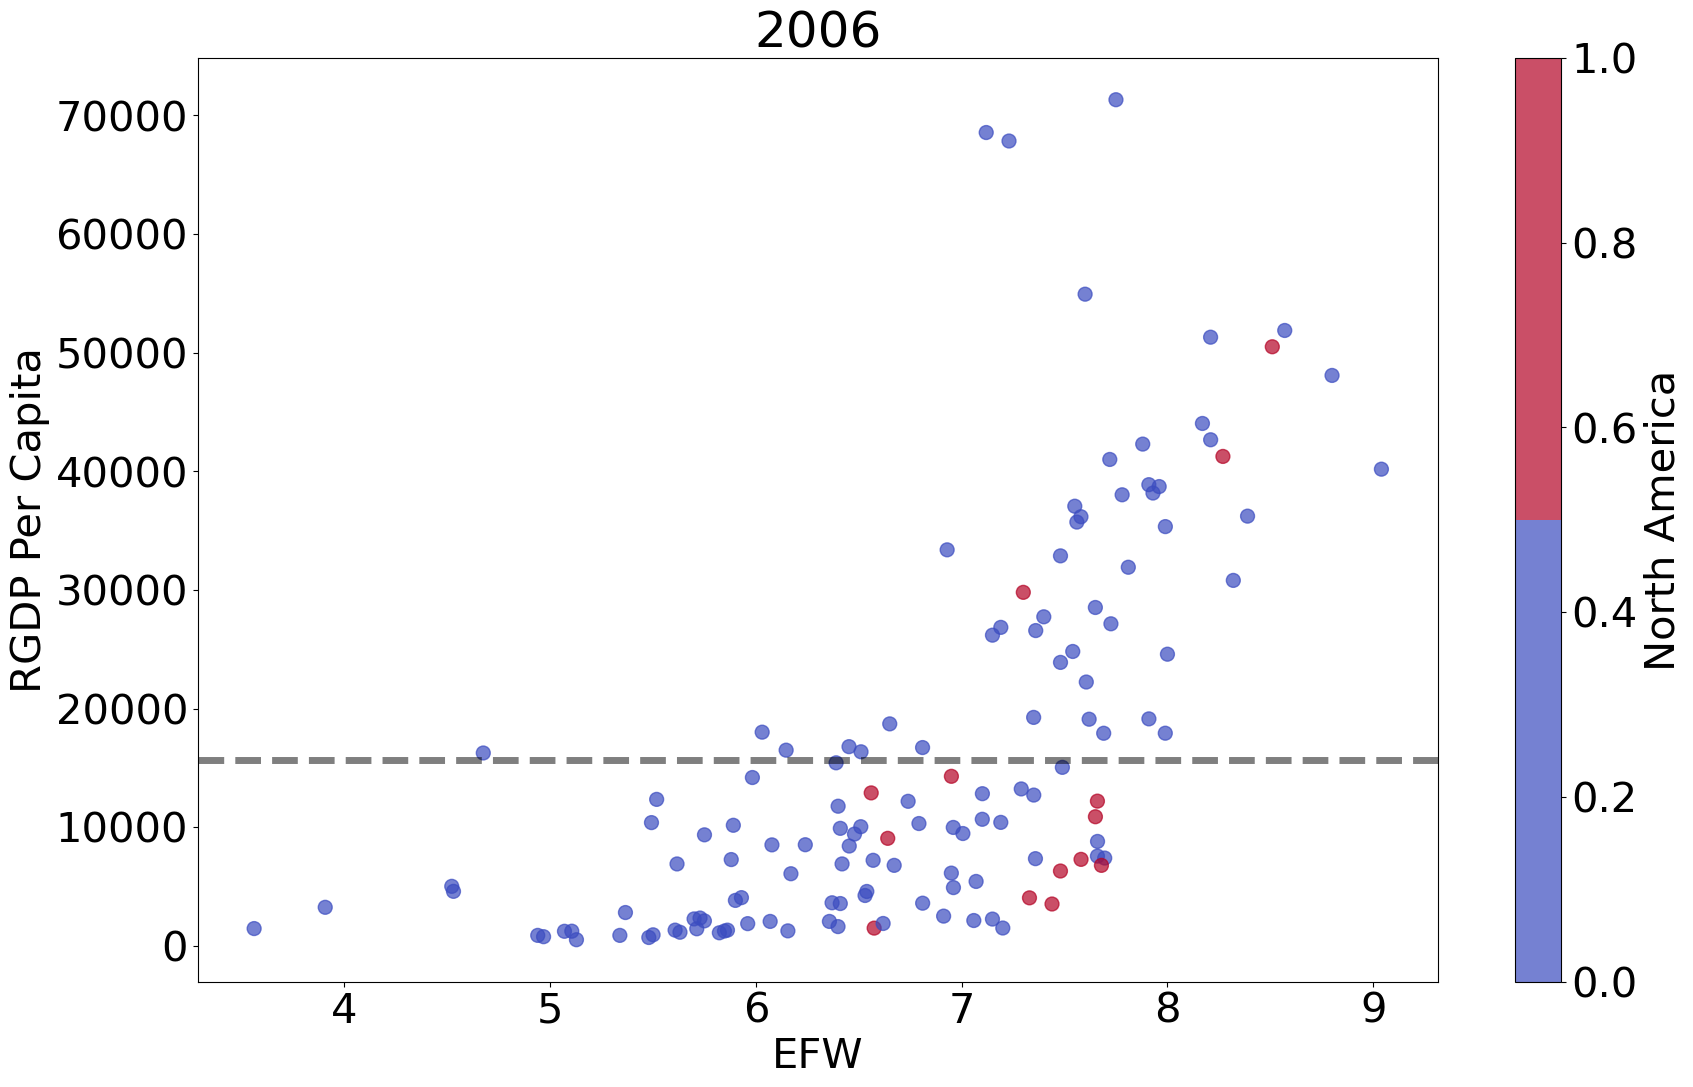

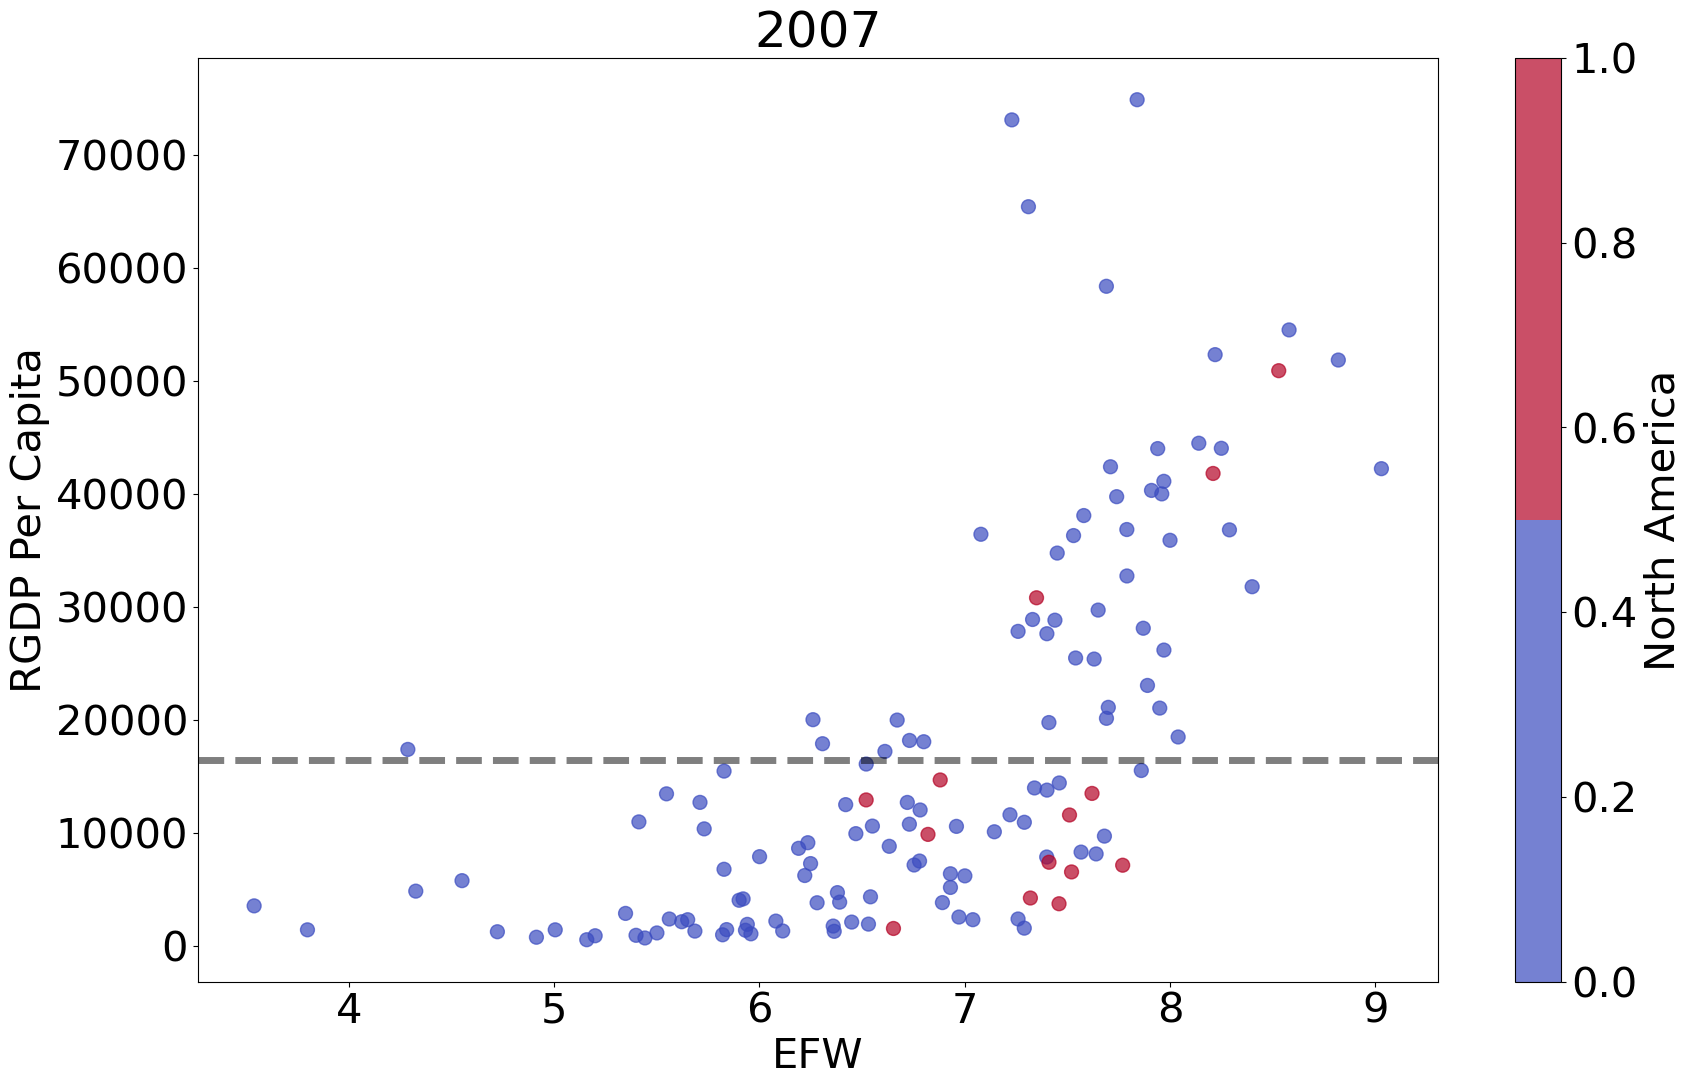

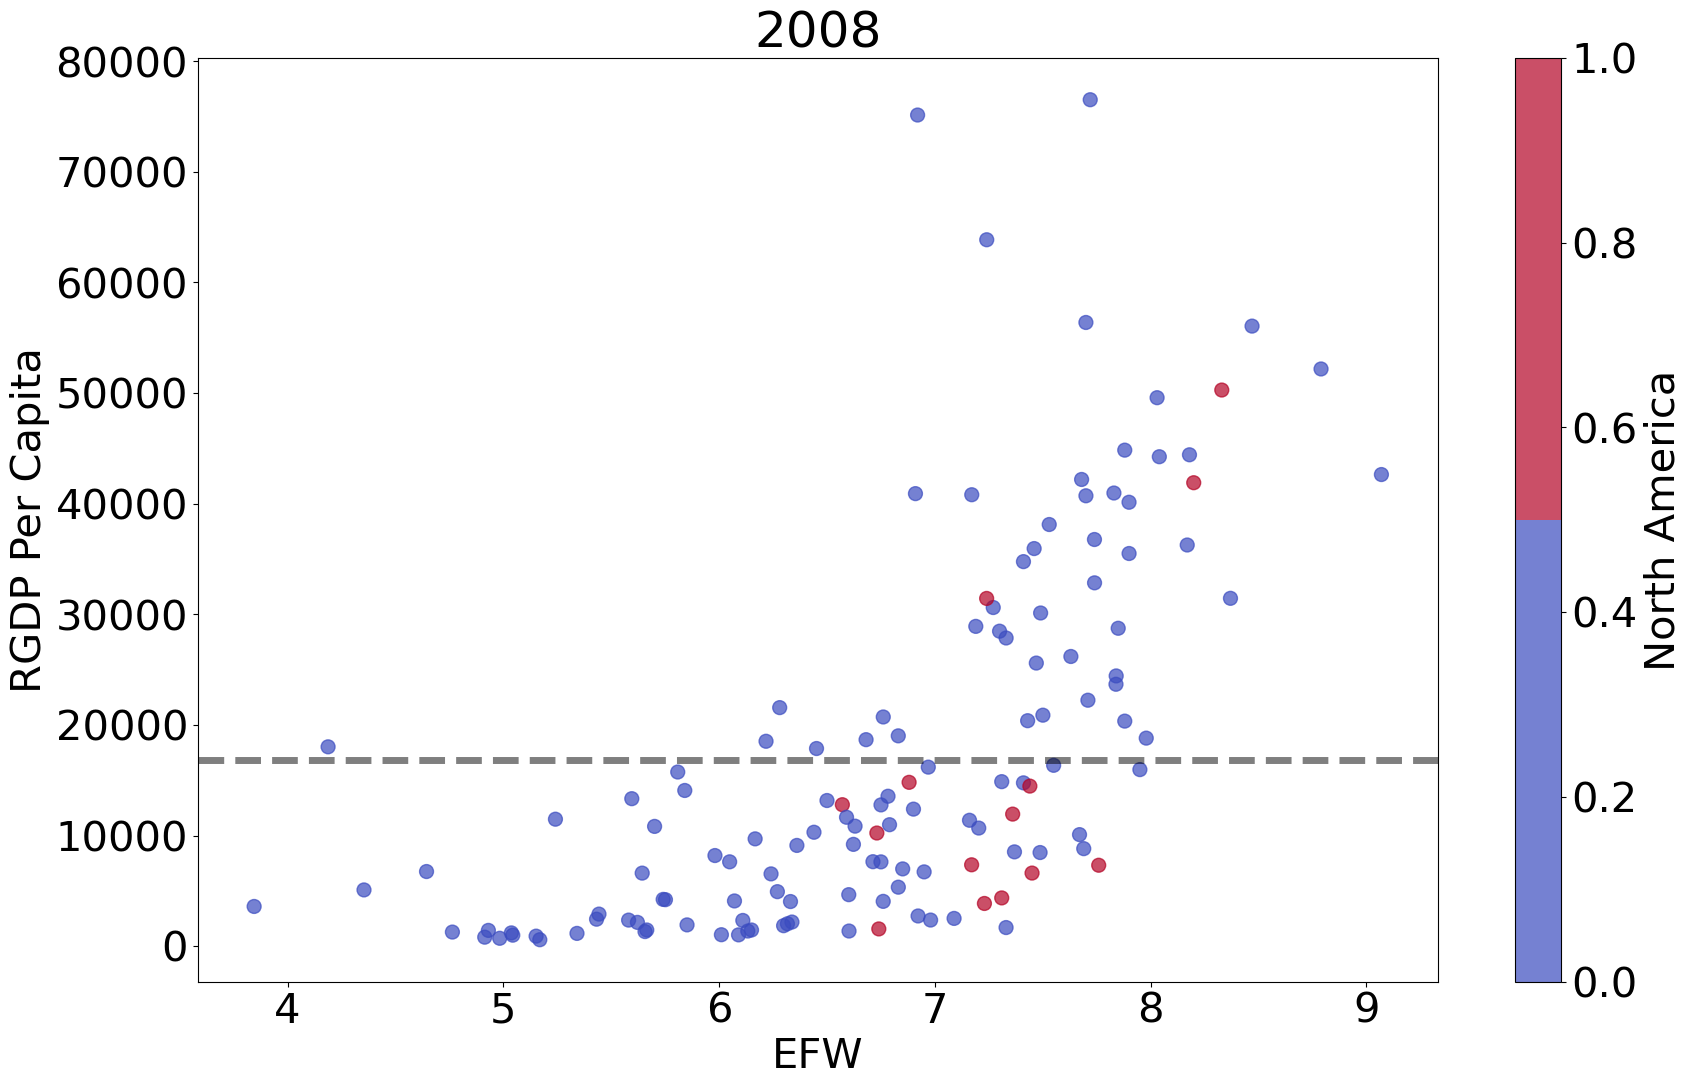

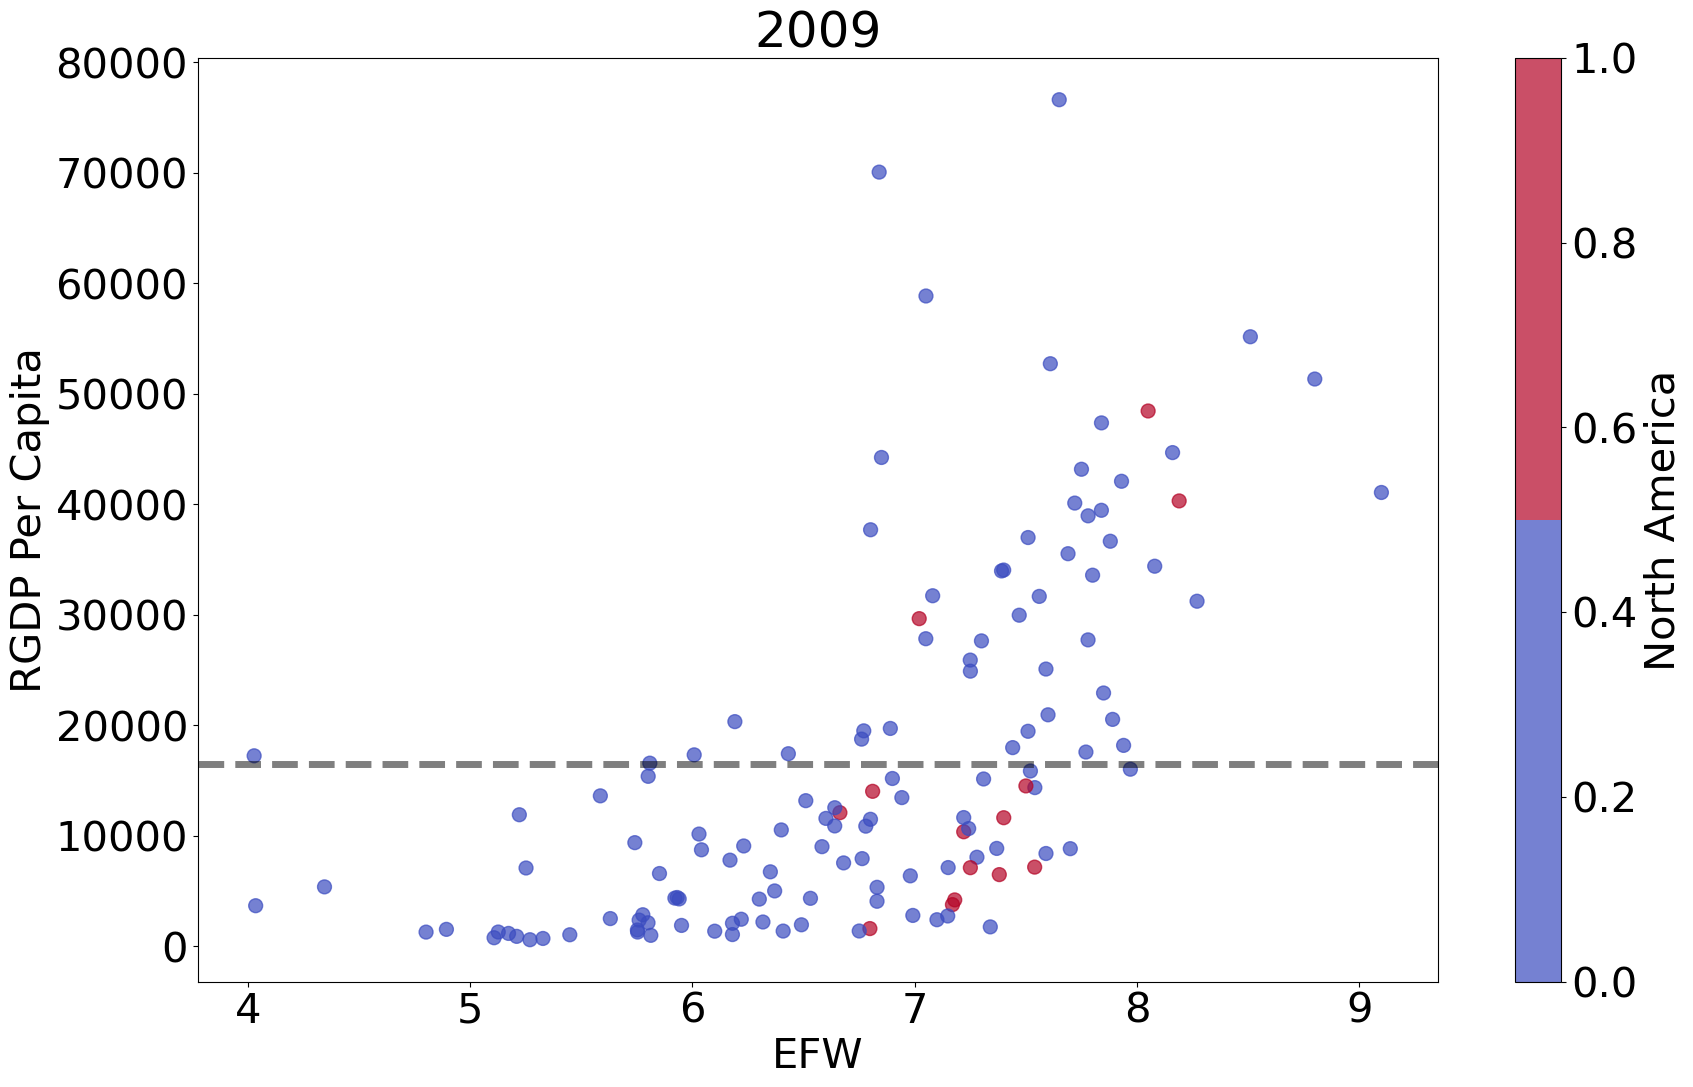

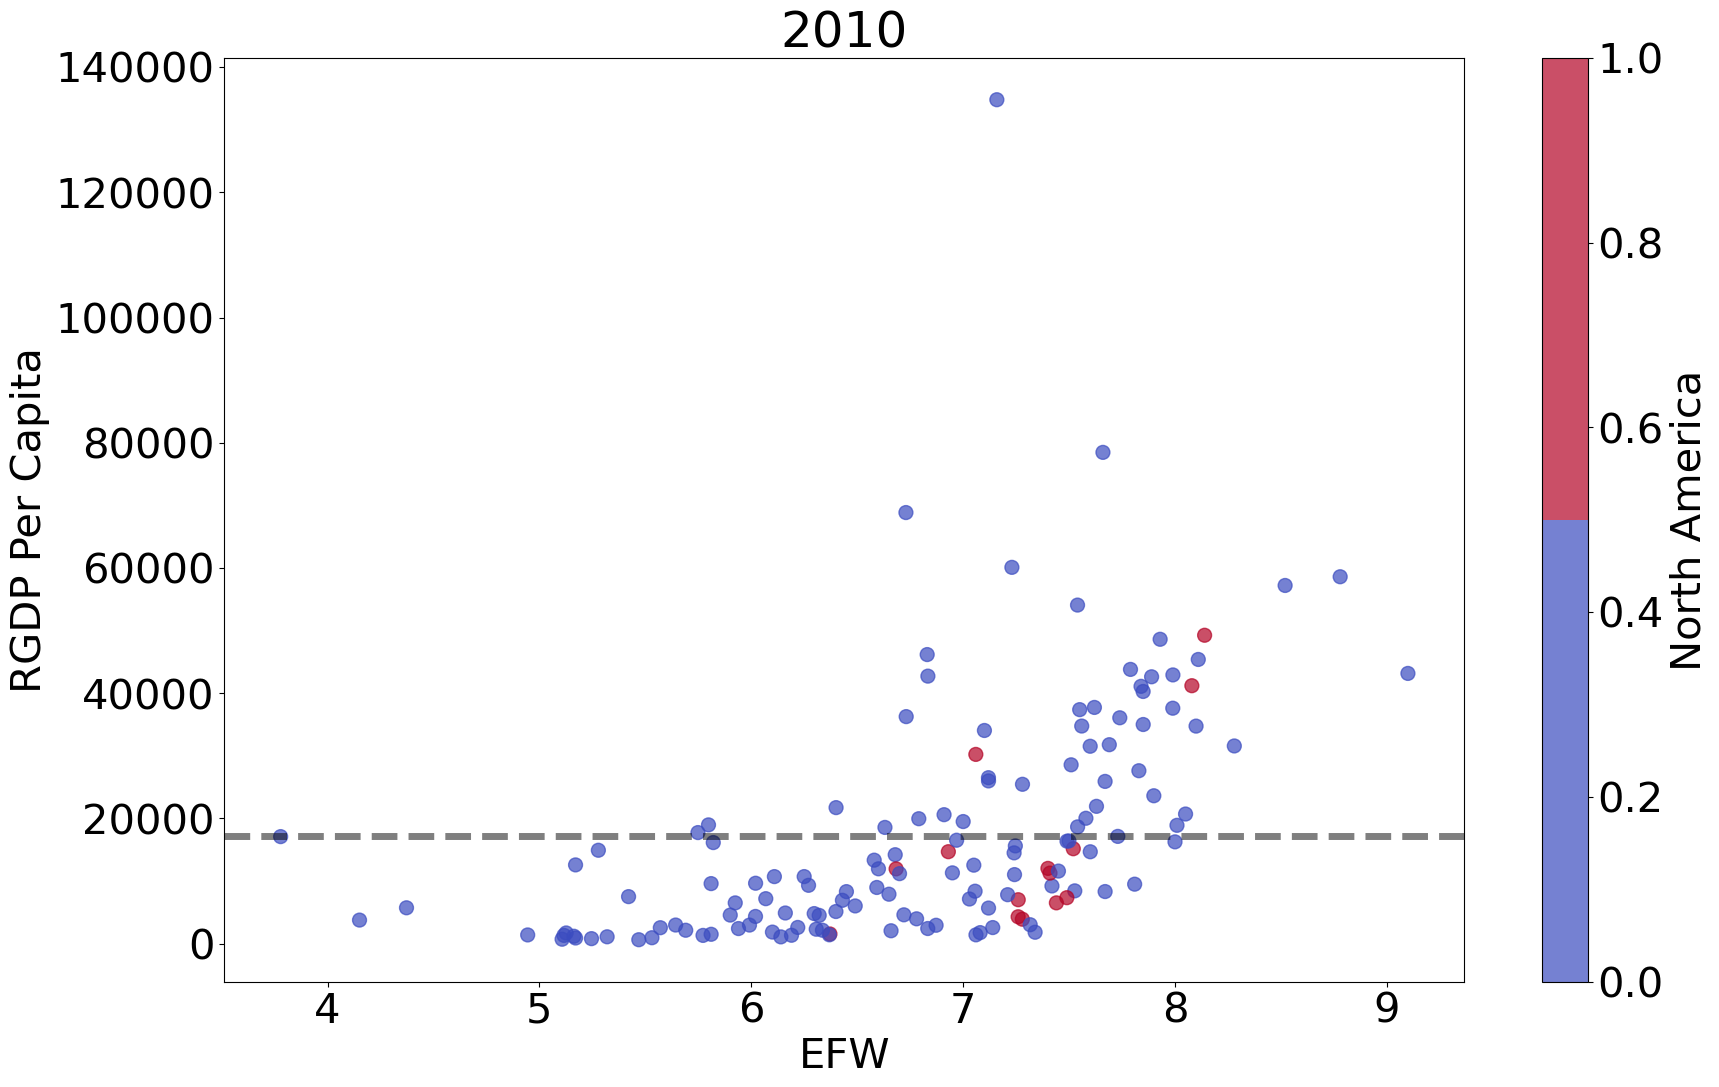

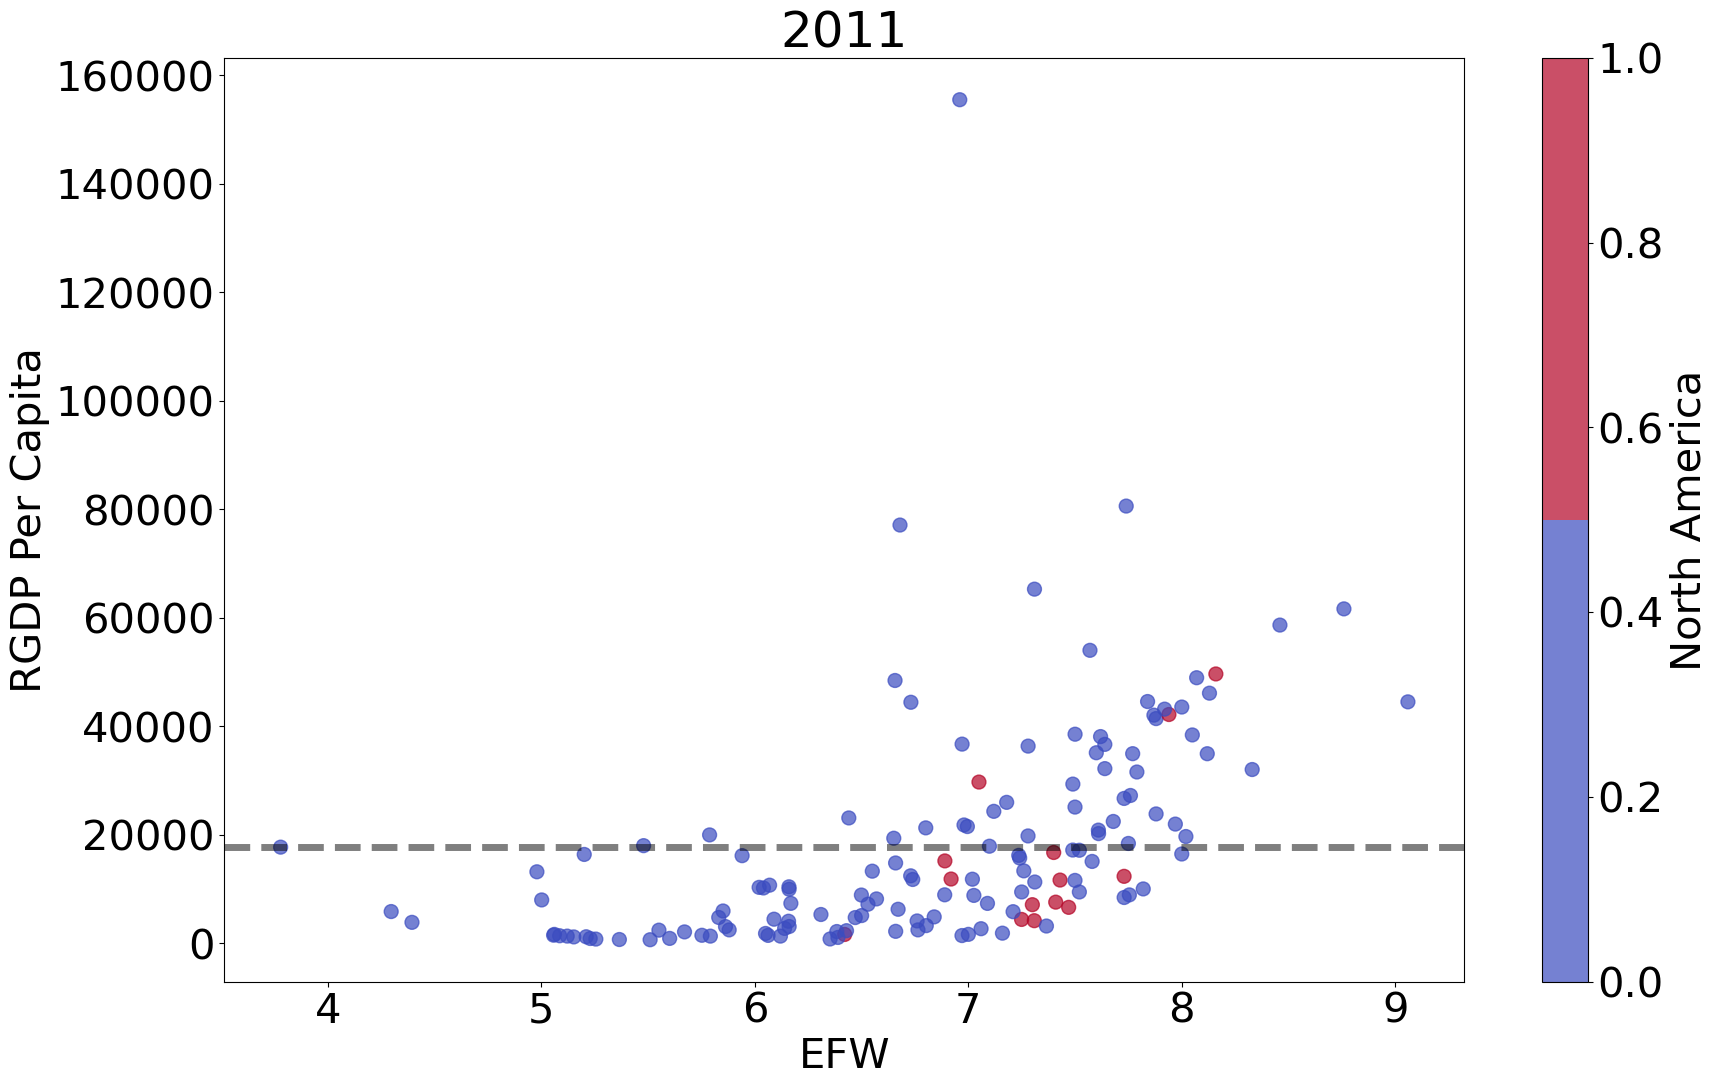

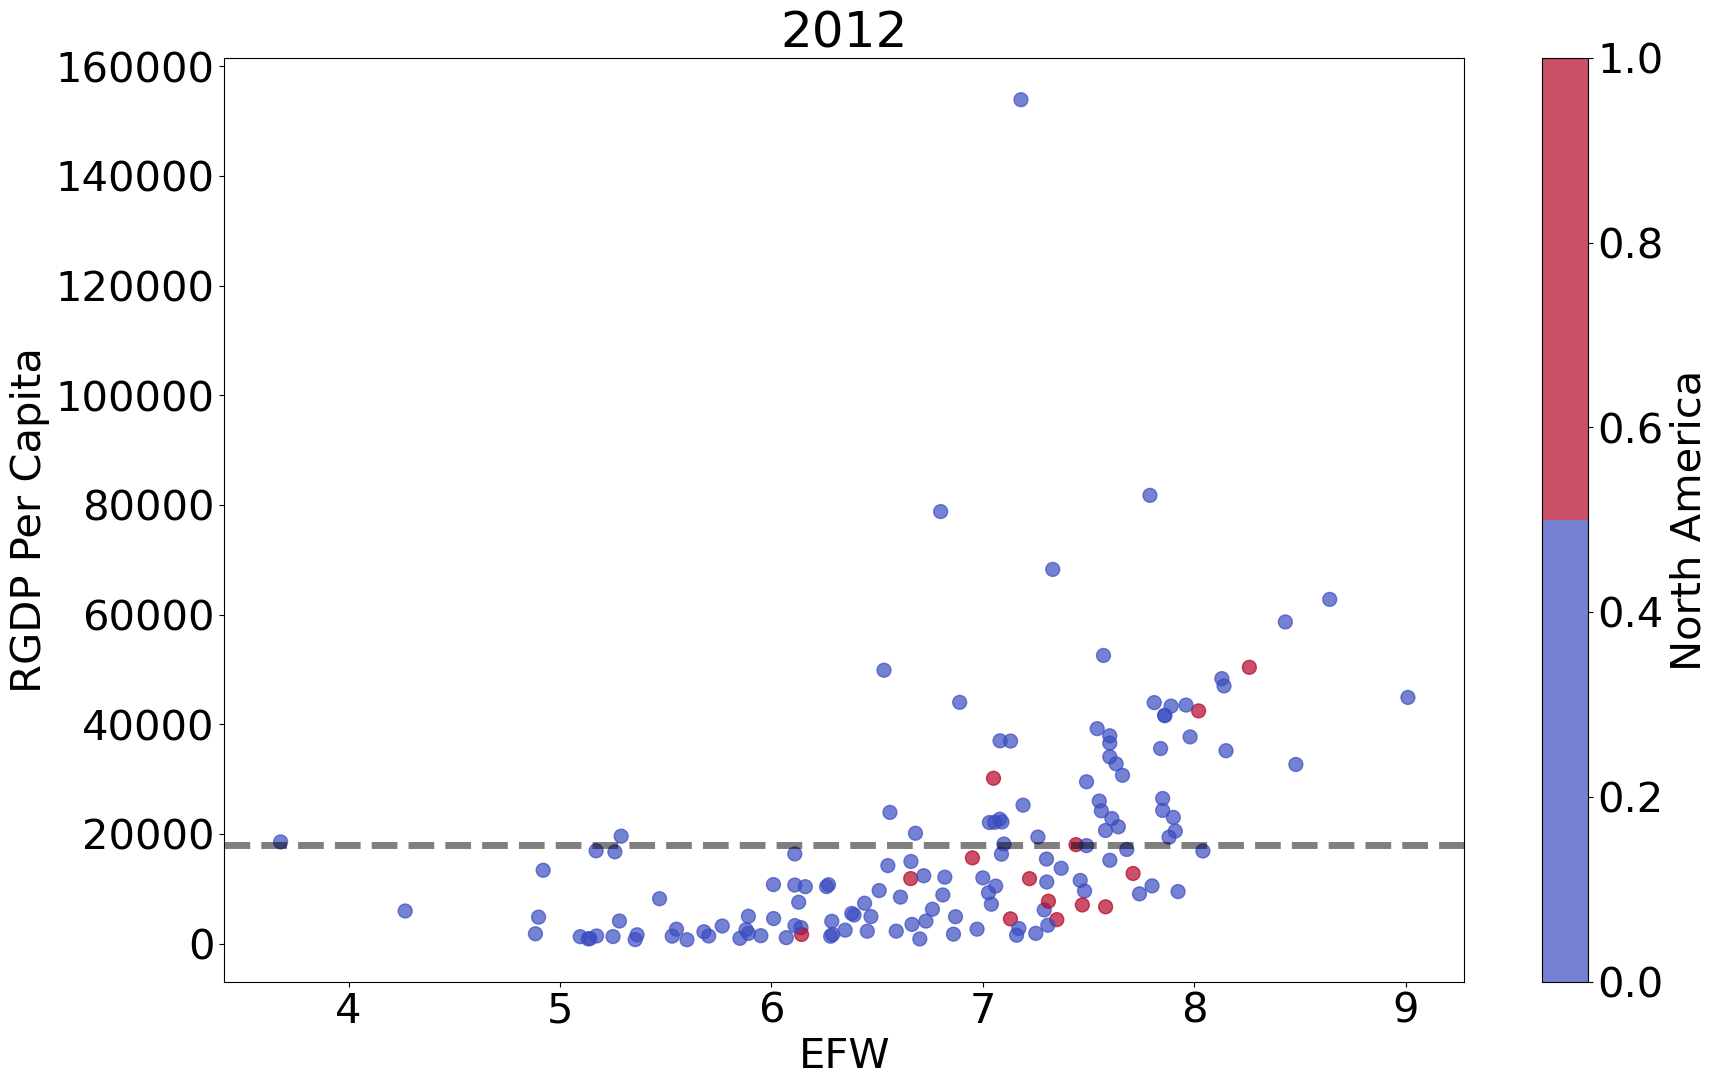

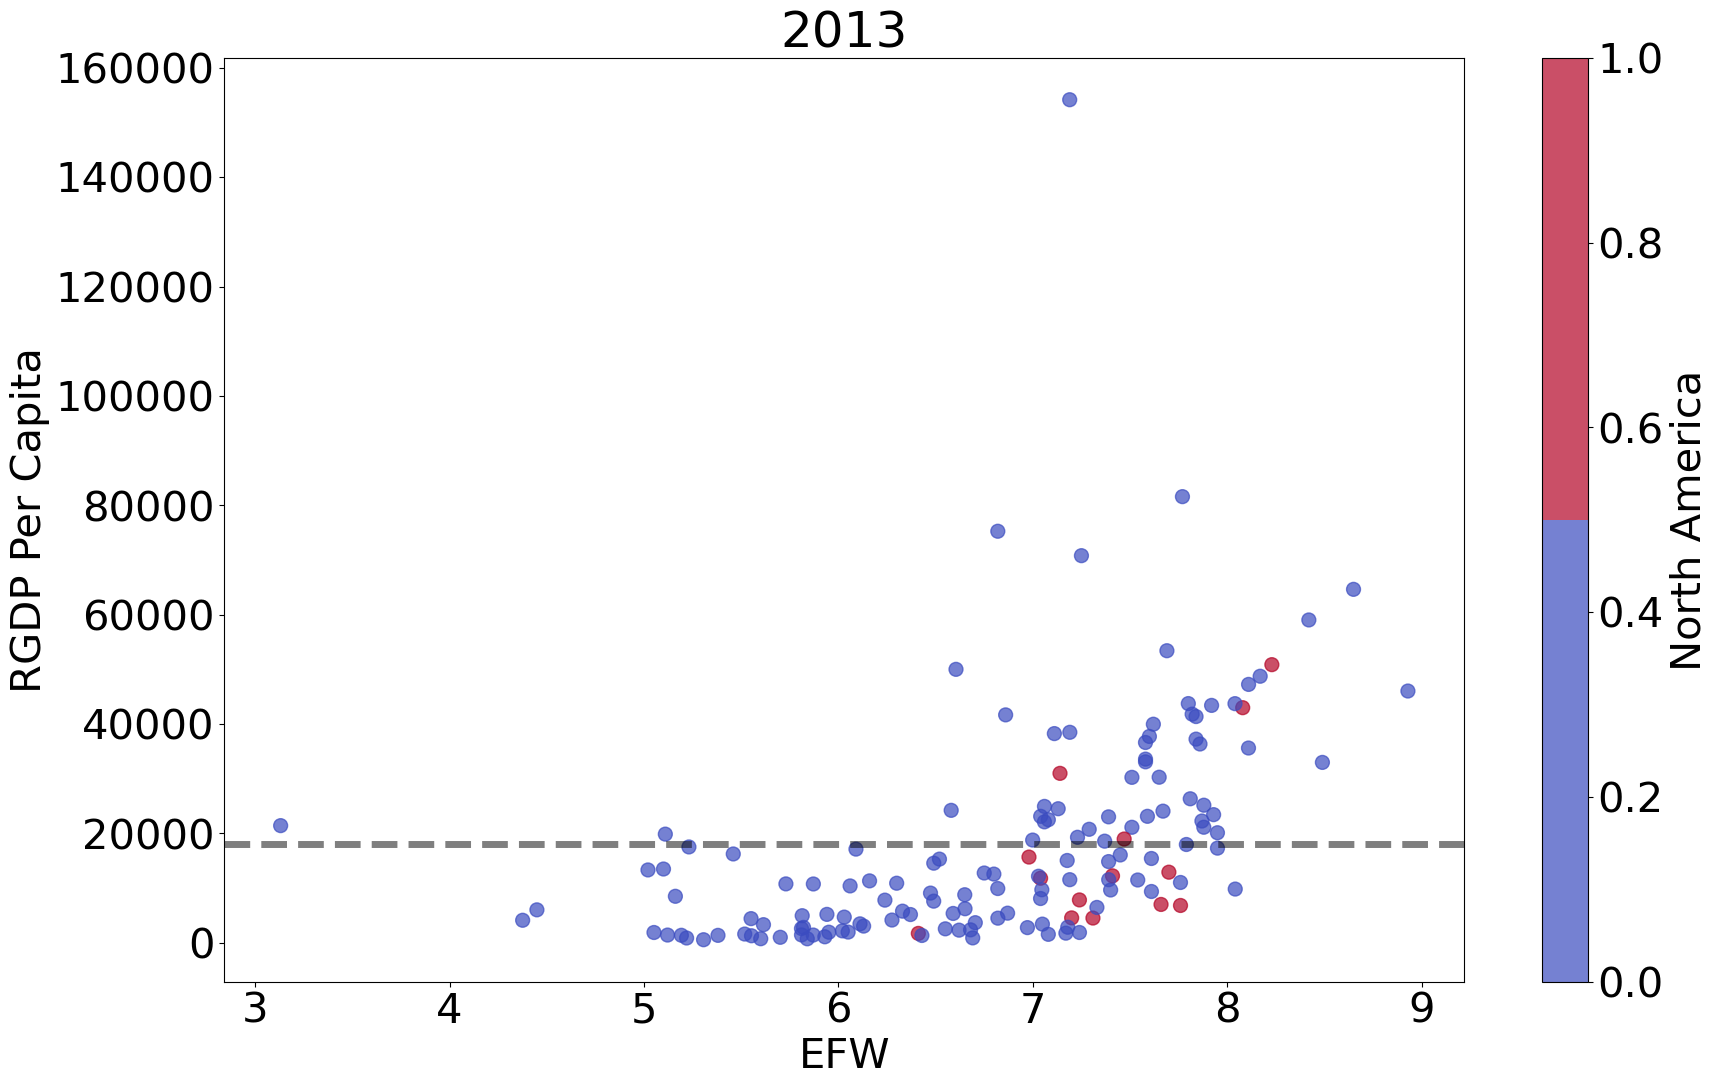

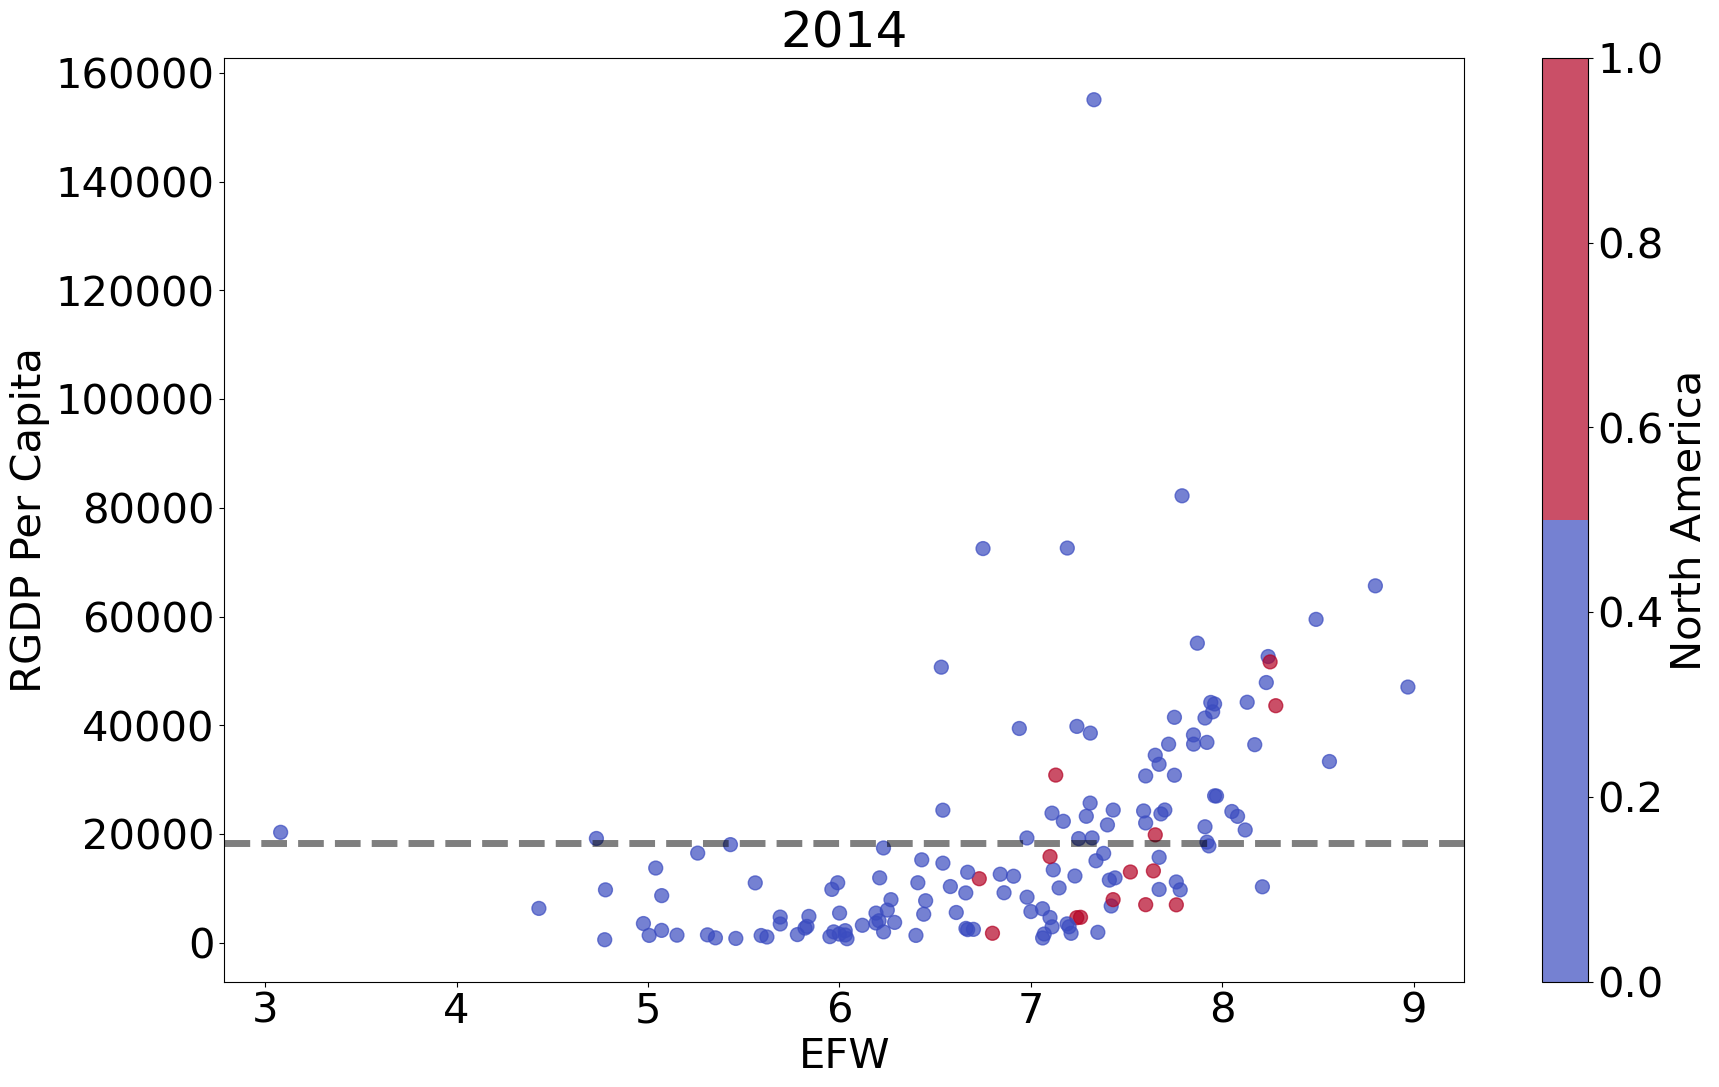

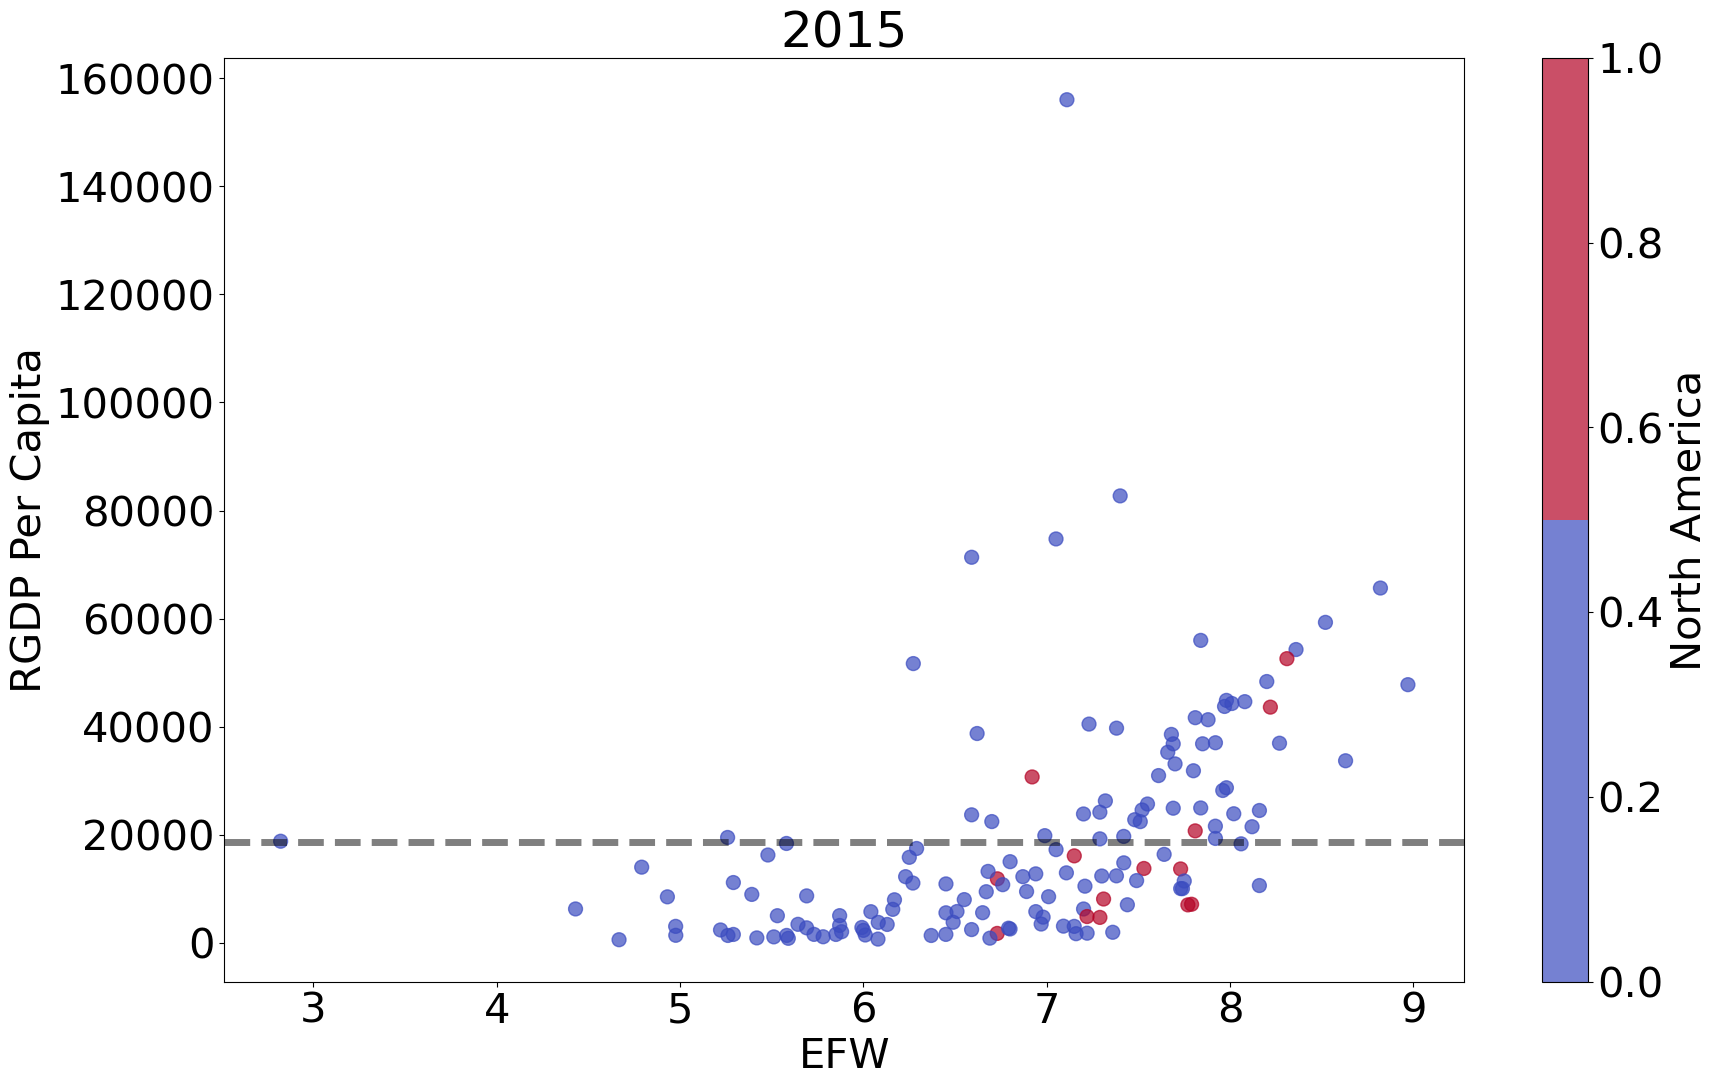

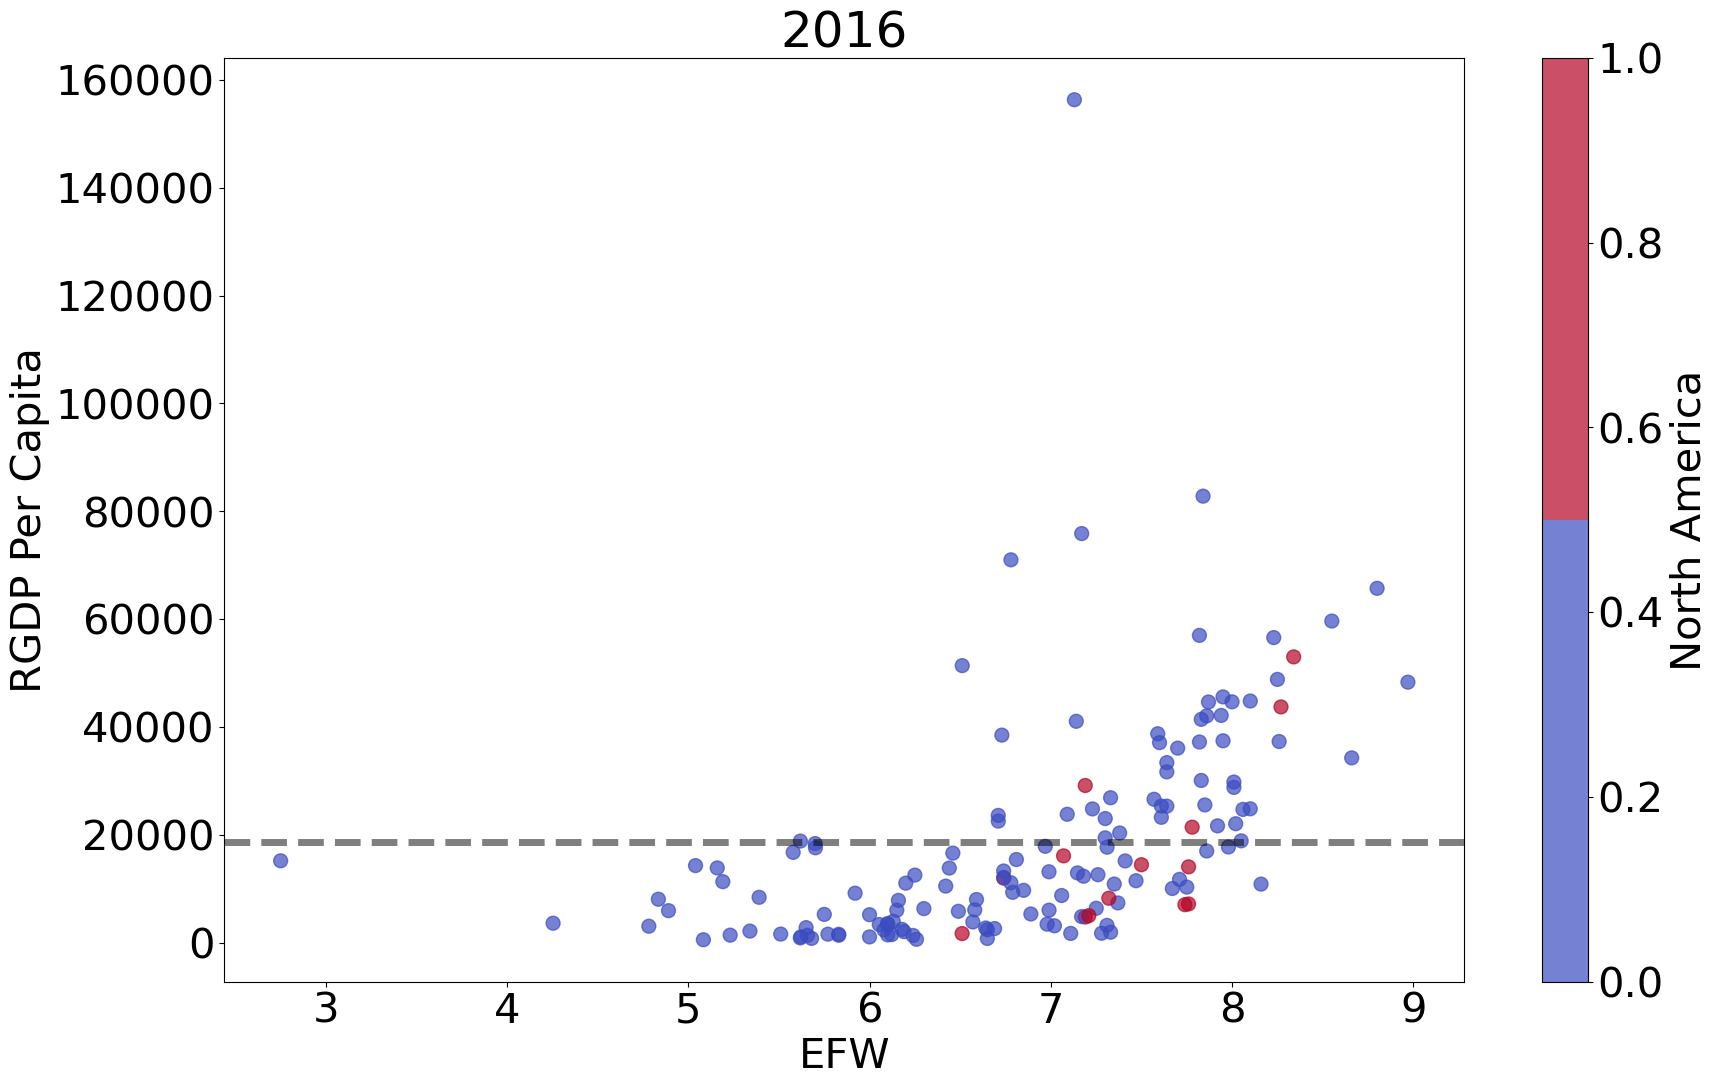

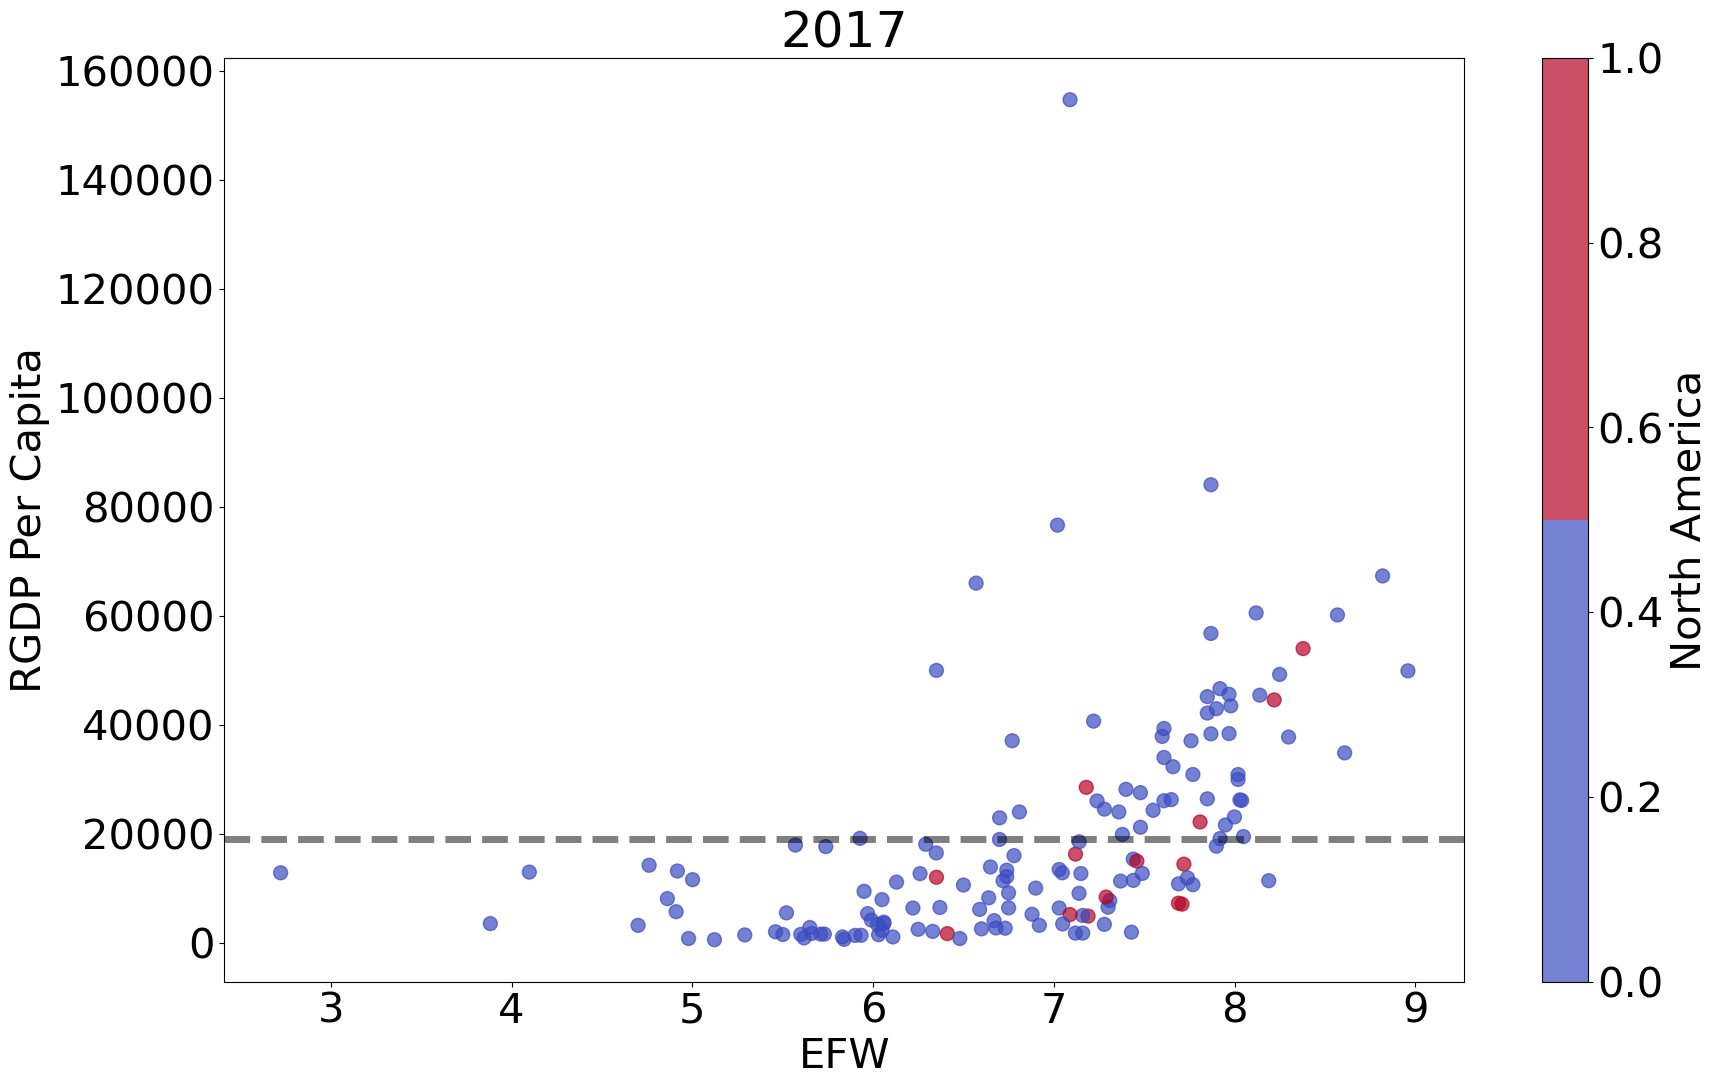

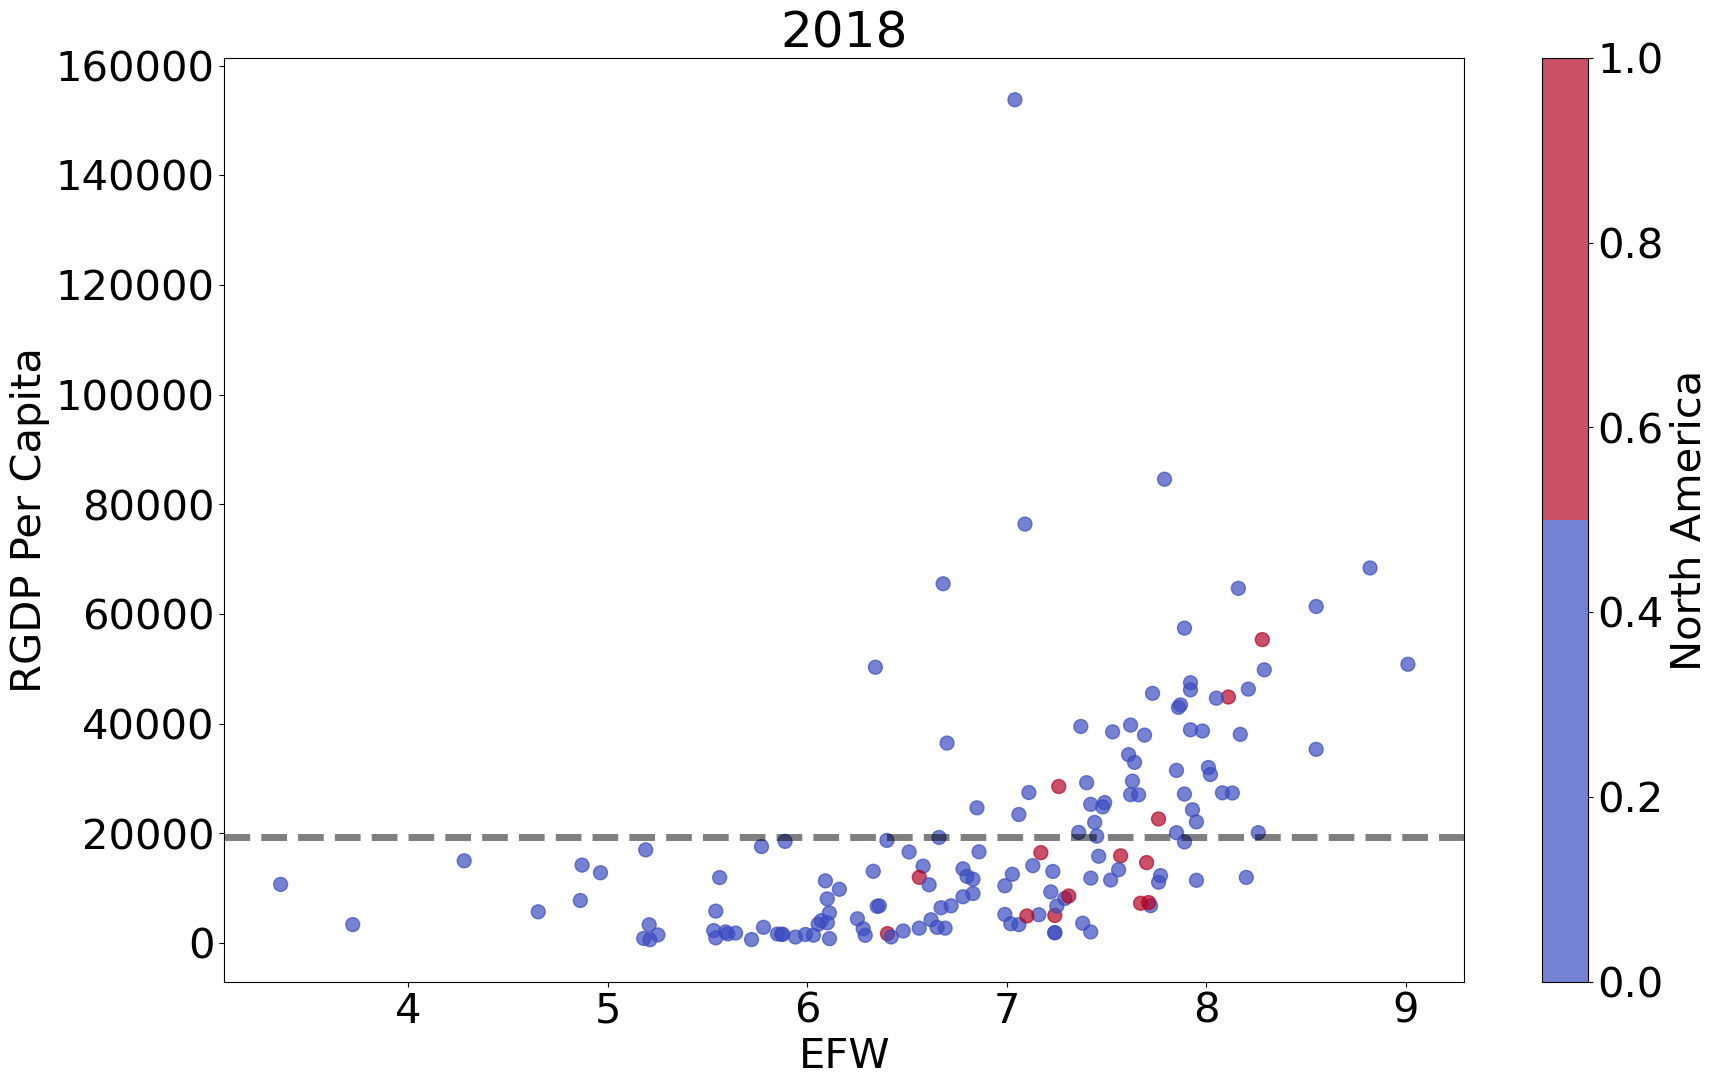

In [8]:
from matplotlib import cm
plt.rcParams.update({"font.size":30})
years = data.dropna(subset = ["RGDP Per Capita"]).index.get_level_values("Year").unique()

# this allows us to normalize the colors and define the color map as coolwarm, 
# but the 2 allows us to determine that 2 colors are used for the 
# difining of the right color bar, and ultimately datapoint colors
norm = cm.colors.Normalize()
cmap = cm.get_cmap('coolwarm', 2)

for year in years:

    plot_data = data[data.index.get_level_values("Year") == year]
    fig, ax = plt.subplots(figsize = (20,12))
    plot_data.plot.scatter(x = "EFW",
                          y = "RGDP Per Capita",
                          c = "North America",
                          cmap = cmap, 
                           s = 100,
                          alpha = .7,
                          ax = ax)

    ax.set_title(str(year)[:4])
    # mean RGDP Per Capita shown below with line
    ax.axhline(plot_data["RGDP Per Capita"].mean(), ls = "--", color = "k", alpha = .5, linewidth = 5)


In [9]:
# quantile function simple
n = 5
quantile_var = "RGDP Per Capita"
quantile_name = quantile_var + " " + str(n) + "-tile"
data[quantile_name] = np.nan


In [14]:
# here we create a quantile function that finds the quantile of our given
# data and given the number of bins and variable name. Below is displaying
# the quantile wealth of countries with 5 bins
# 



# this is not indexed by Growth rate like our in-class project since I am using
# raw number data.

def create_quantile(n,
                   data,
                   year,
                   quantile_var,
                   quantile_name):
    # index that is identifies countries for a given year
    year_index = data.index.get_level_values("Year") == year
    quantile_values_dict = {
        i:data[year_index][quantile_var].quantile(i/n) for i in range(1, n+1)}
    for index in data[year_index].index:
        # identify value of the variable of interest
        val = data.loc[index][quantile_var]
        # cycle through data to check if it's less than each value and
        # bin accordingly using above 
        for i in range(1, n+1):
            if val <= quantile_values_dict[i]:
                data.loc[index,[quantile_name]] = int((n+1) - i)
                break
        else:
            continue

years = data.groupby("Year").mean().index            
for year in years:            
    create_quantile(n, data, year, quantile_var, quantile_name)
data

ISO_Code_2   World Bank Region  \
ISO_Code_3 Year                                        
AGO        1970-01-01         AO  Sub-Saharan Africa   
           1975-01-01         AO  Sub-Saharan Africa   
           1980-01-01         AO  Sub-Saharan Africa   
           1985-01-01         AO  Sub-Saharan Africa   
           1990-01-01         AO  Sub-Saharan Africa   
...                          ...                 ...   
ZWE        2016-01-01         ZW  Sub-Saharan Africa   
           2017-01-01         ZW  Sub-Saharan Africa   
           2018-01-01         ZW  Sub-Saharan Africa   
           2019-01-01         ZW  Sub-Saharan Africa   
           2020-01-01         ZW  Sub-Saharan Africa   

                      World Bank Current Income Classification, 1990-present (L=Low income, LM=Lower middle income, UM=Upper middle income, H=High income)  \
ISO_Code_3 Year                                                                                                                                              
AGO        1970-01-01                                                NaN                                                                                     
           1975-01-01                                                NaN                                                                                     
           1980-01-01                                                NaN                                                                                     
           1985-01-01                                                NaN                                                                                     
           1990-01-01                                                 LM                                                                                     
...                                                                  ...                                                                                     
ZWE        2016-01-01                                                  L                                                                                     
           2017-01-01                                                  L                                                                                     
           2018-01-01                                                 LM                                                                                     
           2019-01-01                                                 LM                                                                                     
           2020-01-01                                                 LM                                                                                     

                      Countries       EFW  Size of Government  \
ISO_Code_3 Year                                                 
AGO        1970-01-01    Angola       NaN                 NaN   
           1975-01-01    Angola       NaN                 NaN   
           1980-01-01    Angola       NaN                 NaN   
           1985-01-01    Angola       NaN                 NaN   
           1990-01-01    Angola       NaN                 NaN   
...                         ...       ...                 ...   
ZWE        2016-01-01  Zimbabwe  6.121996            5.332597   
           2017-01-01  Zimbabwe  5.599886            4.699843   
           2018-01-01  Zimbabwe  5.876298            5.170946   
           2019-01-01  Zimbabwe  4.719465            5.628359   
           2020-01-01  Zimbabwe  4.480000            5.562008   

                       Legal System and Property Rights  Sound Money  \
ISO_Code_3 Year                                                        
AGO        1970-01-01                               NaN          NaN   
           1975-01-01                               NaN          NaN   
           1980-01-01                               NaN          NaN   
           1985-01-01           

<AxesSubplot:xlabel='EFW', ylabel='RGDP Per Capita'>

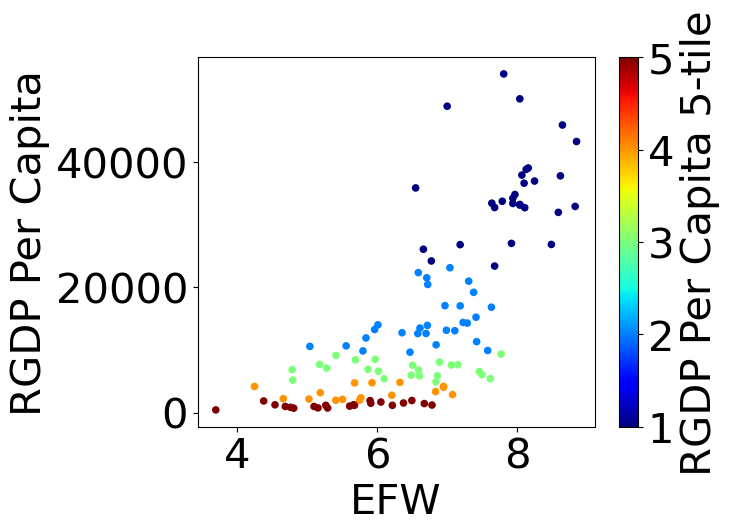

In [19]:
year = "2000"
plot_data = data[data.index.get_level_values("Year") == year]
plot_data.plot.scatter(x = "EFW",
                      y = "RGDP Per Capita",
                      c = "RGDP Per Capita " + str(n) + "-tile",
                      cmap = "jet")